ROOT: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration
OOS: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/data/processed/scored/oos_scored.parquet
bucket_stats: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/model_from_binned/bucket_stats.json
OUTDIR: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures


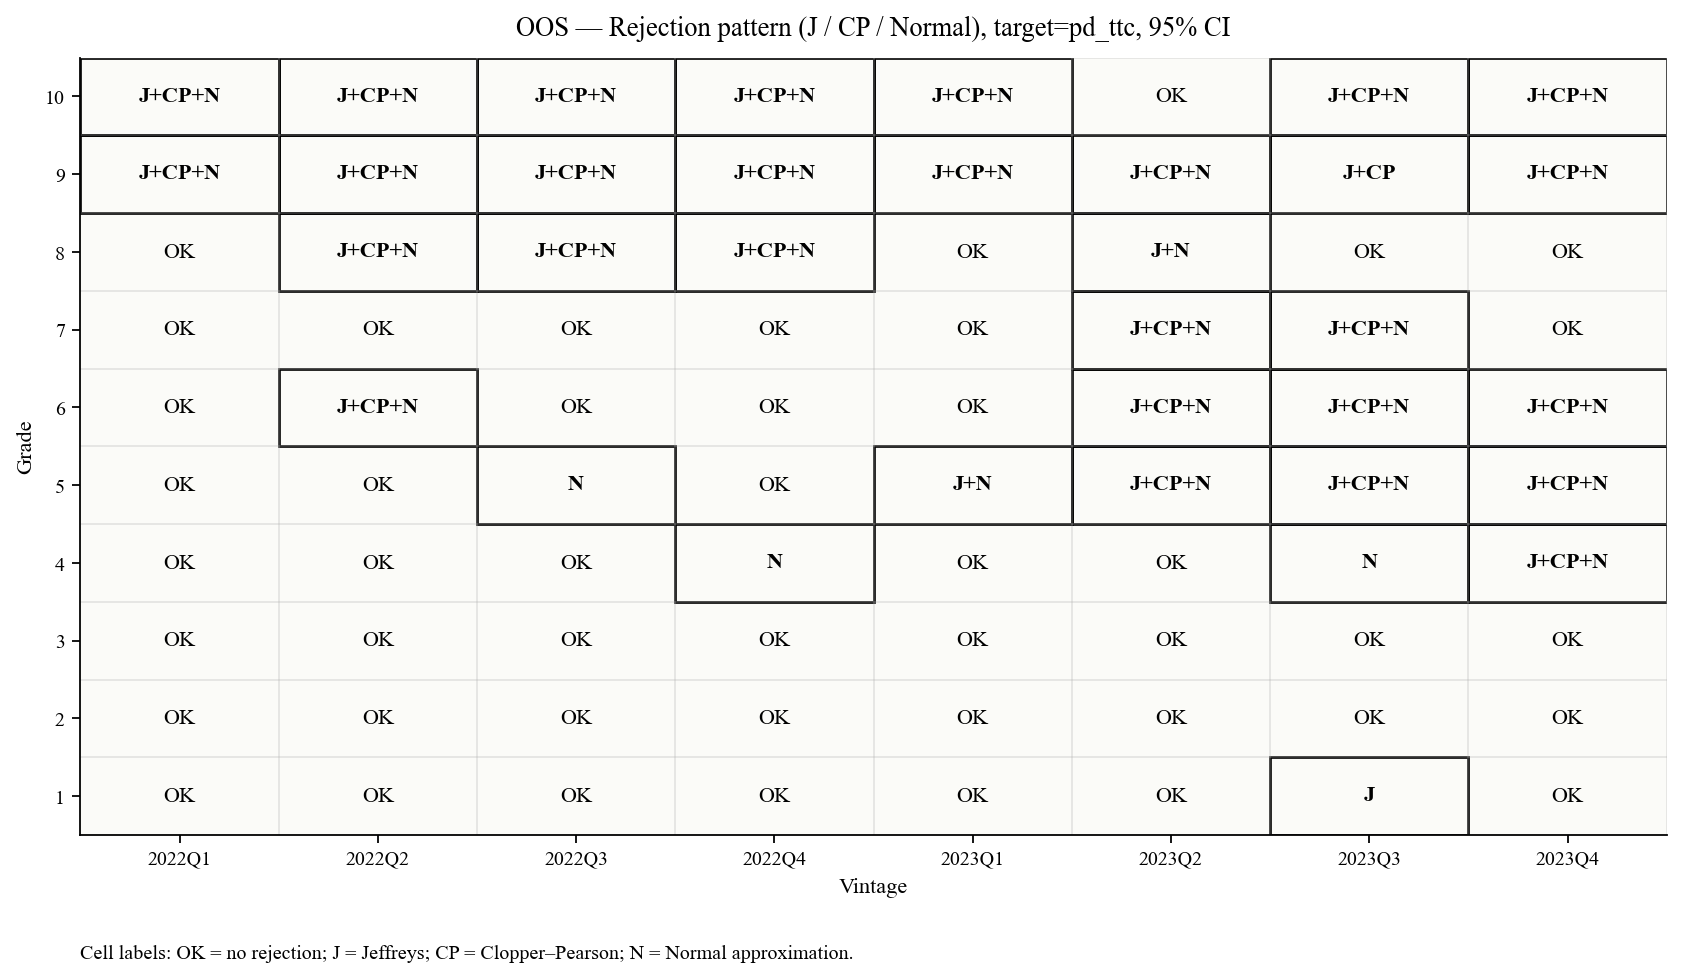

Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig1_combined_text_heatmap_pub.pdf


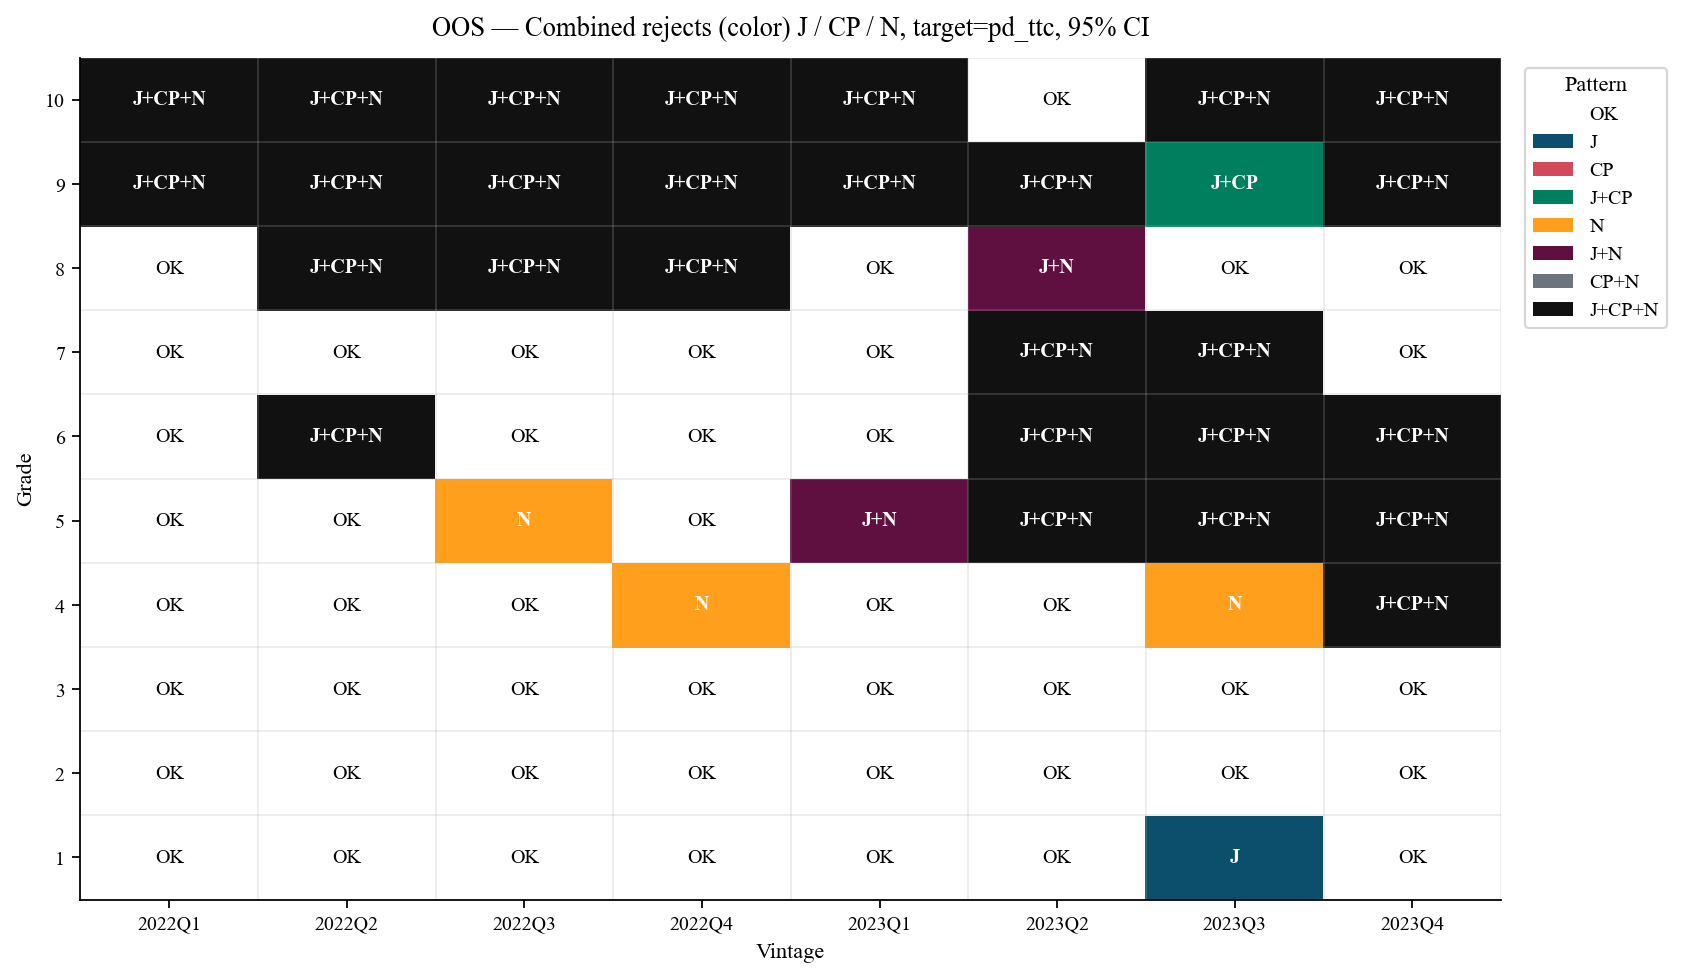

Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig2_combined_color_heatmap_pub.pdf


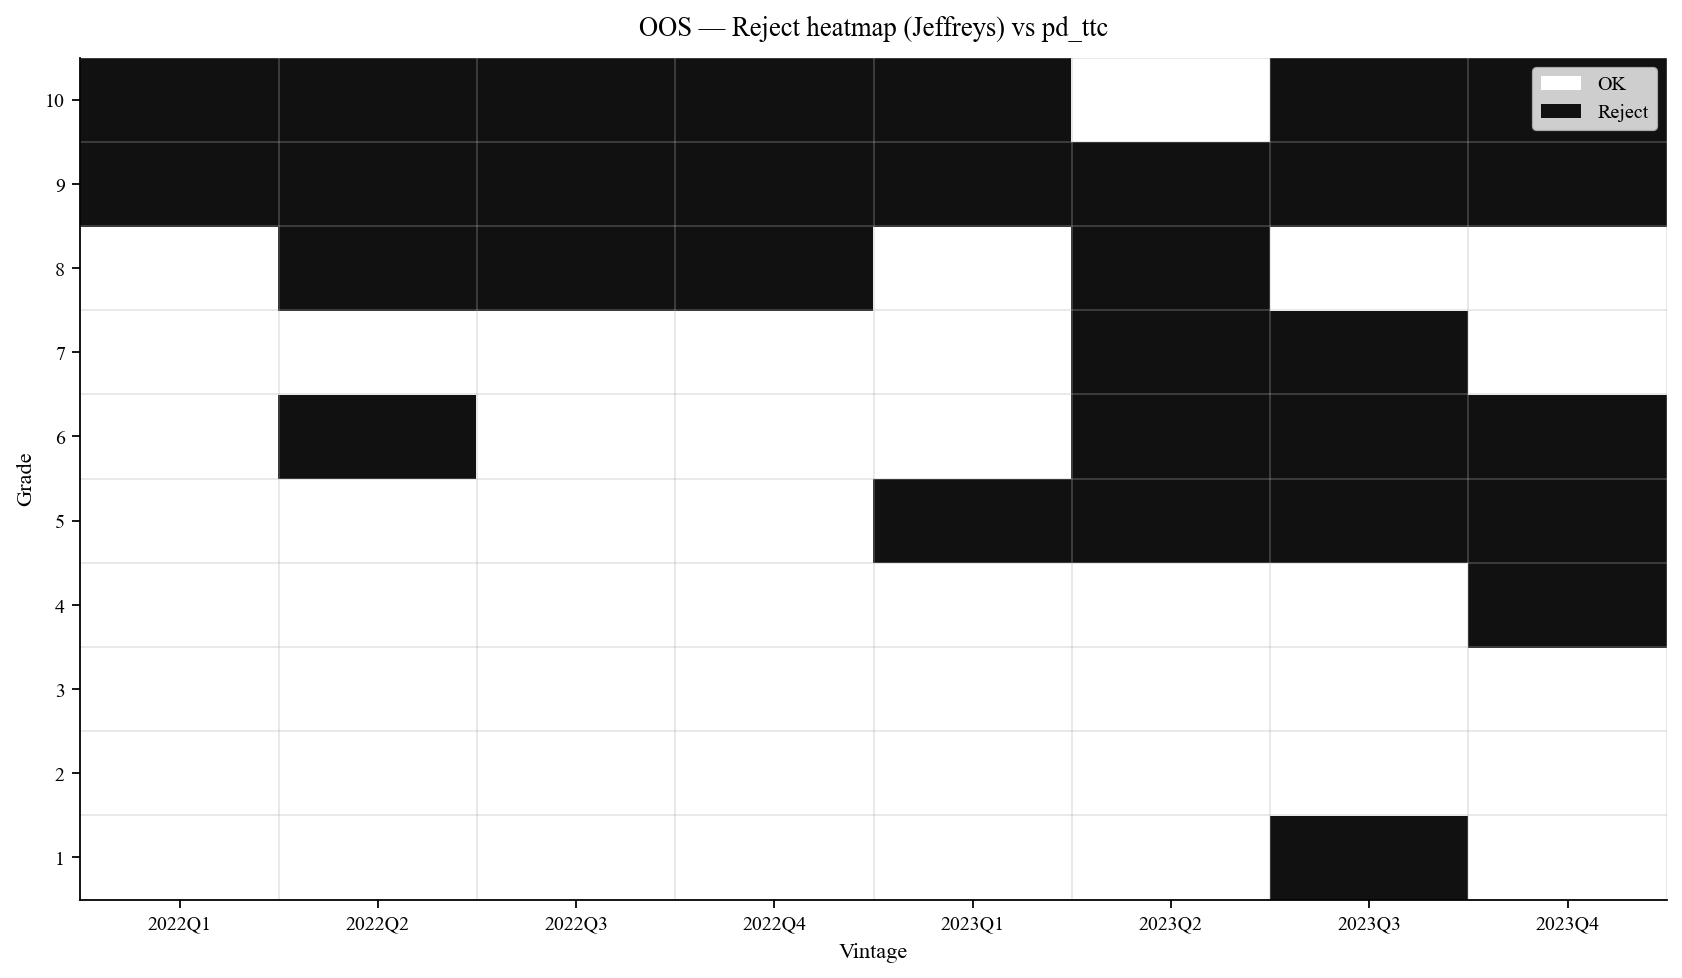

Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig3_reject_jeffreys_pub.pdf


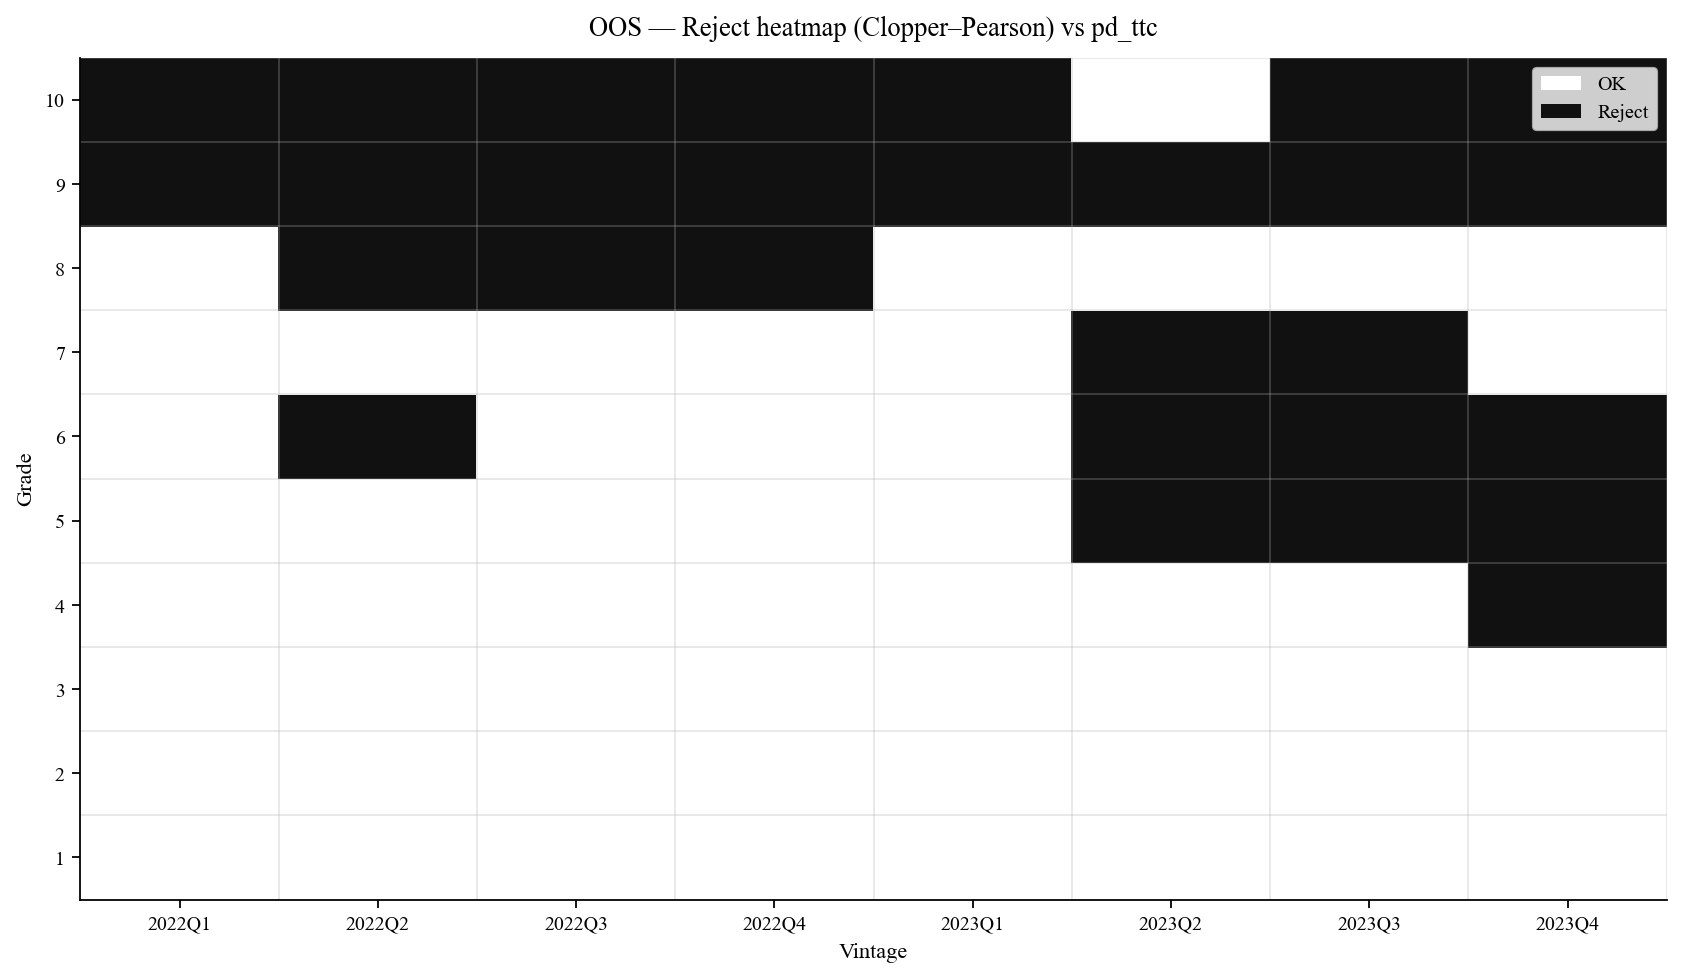

Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig4_reject_cp_pub.pdf


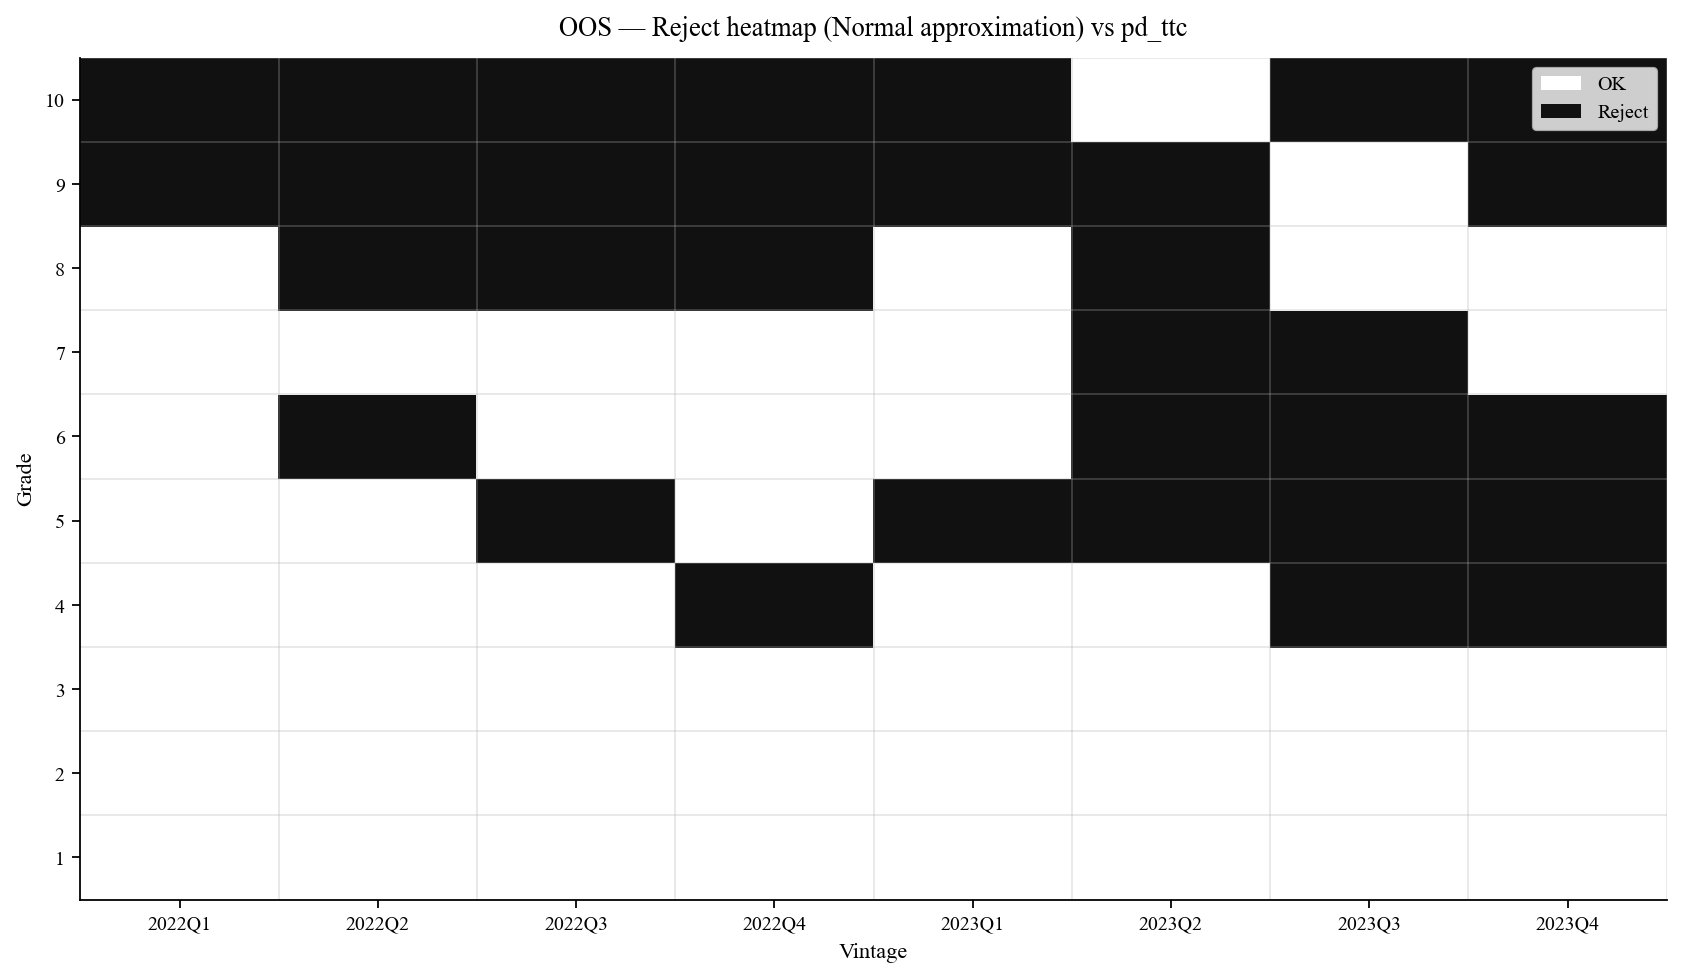

Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig5_reject_normal_pub.pdf

✔ Done. 5 publication-grade figures saved in: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures


In [3]:
# ============================================================
# 5 FIGURES — PUBLICATION-GRADE (SELF-CONTAINED)
# 1) Combined TEXT heatmap (OK / J / CP / N / combos) + subtle emphasis
# 2) Combined COLOR heatmap (high contrast) + text overlay (no ambiguity)
# 3) Jeffreys reject heatmap (binary, pretty)
# 4) Clopper–Pearson reject heatmap (binary, pretty)
# 5) Normal approx reject heatmap (binary, pretty)
# Loads OOS + bucket_stats, computes rejects, plots all 5, saves PDFs.
# ============================================================

from __future__ import annotations

import sys, json
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch, Rectangle

# -------------------------
# 0) Root + publication style
# -------------------------
def find_project_root(start: Path | None = None) -> Path:
    start = (start or Path.cwd()).resolve()
    markers = {"pyproject.toml", "Makefile", ".git"}
    for p in [start] + list(start.parents):
        if any((p / m).exists() for m in markers):
            return p
    return start

ROOT = find_project_root()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# Publication-grade defaults (LaTeX-friendly PDFs)
mpl.rcParams.update({
    "figure.dpi": 160,
    "savefig.dpi": 300,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "mathtext.fontset": "cm",
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 0.8,
    "axes.grid": False,
    "figure.constrained_layout.use": True,
})

# -------------------------
# 1) Project intervals (needed for J / CP / Normal comparison)
# -------------------------
from experiments.stats.intervals import jeffreys_alpha2, exact_cp, approx_normal

# -------------------------
# 2) CONFIG
# -------------------------
CONF_LEVEL = 0.95

OOS_PATH = ROOT / "data" / "processed" / "scored" / "oos_scored.parquet"
BUCKET_STATS_PATH = ROOT / "artifacts" / "model_from_binned" / "bucket_stats.json"
BUCKET_SECTION = "train"

VINTAGE_COL = "vintage"
GRADE_COL = "grade"
DEFAULT_COL = "default_12m"
PD_LOAN_COL = "pd"

TEST_TARGET = "pd_ttc"      # "pd_ttc" or "pd_hat"

# You said: 8 quarters x 10 grades → text can be big & clear
SHOW_OK_TEXT = True         # show "OK" in non-reject cells
TEXT_FONTSIZE = 10
TEXT_FONTSIZE_COLOR = 9

# Output
OUTDIR = ROOT / "artifacts" / "paper_figures"
OUTDIR.mkdir(parents=True, exist_ok=True)

# Filenames
FN1 = "fig1_combined_text_heatmap_pub.pdf"
FN2 = "fig2_combined_color_heatmap_pub.pdf"
FN3 = "fig3_reject_jeffreys_pub.pdf"
FN4 = "fig4_reject_cp_pub.pdf"
FN5 = "fig5_reject_normal_pub.pdf"

assert OOS_PATH.exists(), f"OOS file not found: {OOS_PATH}"
assert BUCKET_STATS_PATH.exists(), f"bucket_stats.json not found: {BUCKET_STATS_PATH}"

print("ROOT:", ROOT)
print("OOS:", OOS_PATH)
print("bucket_stats:", BUCKET_STATS_PATH)
print("OUTDIR:", OUTDIR)

# -------------------------
# 3) Helpers
# -------------------------
def _safe_int_grade(x) -> int:
    try:
        return int(float(x))
    except Exception:
        return int(x)

def parse_vintage_to_period(s: pd.Series) -> pd.PeriodIndex:
    s_str = s.astype(str).str.strip()
    m = s_str.str.upper().str.replace(" ", "", regex=False).str.match(r"^\d{4}-?Q[1-4]$")
    if m.all():
        cleaned = s_str.str.upper().str.replace(" ", "", regex=False).str.replace("-", "", regex=False)
        return pd.PeriodIndex(cleaned, freq="Q")
    dt = pd.to_datetime(s_str, errors="coerce")
    if float(dt.notna().mean()) < 0.95:
        bad = s_str[dt.isna()].head(10).tolist()
        raise ValueError(f"Cannot parse vintage. Examples: {bad}")
    return dt.dt.to_period("Q")

def load_bucket_pd_map(path: Path, section: str) -> dict[int, float]:
    data = json.loads(path.read_text(encoding="utf-8"))
    if section not in data:
        raise KeyError(f"'{section}' not in bucket_stats.json. Keys: {list(data.keys())}")
    return {int(e["bucket"]): float(e["pd"]) for e in data[section]}

def build_vintage_grade_table(df: pd.DataFrame, pd_ttc_map: dict[int, float]) -> pd.DataFrame:
    cols = [VINTAGE_COL, GRADE_COL, DEFAULT_COL]
    use_pd = PD_LOAN_COL in df.columns
    if use_pd:
        cols.append(PD_LOAN_COL)

    x = df[cols].copy()
    x[GRADE_COL] = x[GRADE_COL].map(_safe_int_grade)

    if use_pd:
        agg = x.groupby([VINTAGE_COL, GRADE_COL], as_index=False).agg(
            n=(DEFAULT_COL, "count"),
            d=(DEFAULT_COL, "sum"),
            pd_hat=(PD_LOAN_COL, "mean"),
        )
    else:
        agg = x.groupby([VINTAGE_COL, GRADE_COL], as_index=False).agg(
            n=(DEFAULT_COL, "count"),
            d=(DEFAULT_COL, "sum"),
        )
        agg["pd_hat"] = np.nan

    agg["pd_obs"] = agg["d"] / agg["n"]
    agg["pd_ttc"] = agg[GRADE_COL].map(pd_ttc_map).astype(float)

    per = parse_vintage_to_period(agg[VINTAGE_COL])
    agg["_per"] = per
    agg = agg.sort_values(["_per", GRADE_COL]).drop(columns=["_per"]).reset_index(drop=True)
    return agg

def compute_rejects(df_vg: pd.DataFrame, test_target: str, conf: float) -> pd.DataFrame:
    out = df_vg.copy()
    out["p0"] = out[test_target].astype(float)

    n_arr = out["n"].to_numpy(int)
    d_arr = out["d"].to_numpy(int)
    p0_arr = out["p0"].to_numpy(float)

    ok = np.isfinite(p0_arr) & (n_arr > 0)

    rej_j = np.full(len(out), np.nan)
    rej_cp = np.full(len(out), np.nan)
    rej_n = np.full(len(out), np.nan)

    for i, (n, d) in enumerate(zip(n_arr, d_arr)):
        if not ok[i]:
            continue

        lb, ub = jeffreys_alpha2(n, d, conf)
        if np.isfinite(lb) and np.isfinite(ub):
            rej_j[i] = float(not (p0_arr[i] >= lb and p0_arr[i] <= ub))

        lb, ub = exact_cp(n, d, conf)
        if np.isfinite(lb) and np.isfinite(ub):
            rej_cp[i] = float(not (p0_arr[i] >= lb and p0_arr[i] <= ub))

        lb, ub = approx_normal(n, d, conf)
        lb = max(0.0, float(lb)); ub = min(1.0, float(ub))
        if np.isfinite(lb) and np.isfinite(ub):
            rej_n[i] = float(not (p0_arr[i] >= lb and p0_arr[i] <= ub))

    out["reject_jeffreys"] = rej_j
    out["reject_cp"] = rej_cp
    out["reject_normal"] = rej_n
    return out

def combo_label(j, cp, n, show_ok=True):
    parts = []
    if j:  parts.append("J")
    if cp: parts.append("CP")
    if n:  parts.append("N")
    if len(parts) == 0:
        return "OK" if show_ok else ""
    return "+".join(parts)

def prep_pivots(df_long: pd.DataFrame):
    tmp = df_long.copy()
    tmp[VINTAGE_COL] = tmp[VINTAGE_COL].astype(str)
    tmp[GRADE_COL] = tmp[GRADE_COL].astype(int)

    per = parse_vintage_to_period(tmp[VINTAGE_COL])
    order = (
        tmp[[VINTAGE_COL]].assign(_per=per).drop_duplicates()
        .sort_values("_per")[VINTAGE_COL].astype(str).tolist()
    )
    tmp[VINTAGE_COL] = pd.Categorical(tmp[VINTAGE_COL], categories=order, ordered=True)

    matJ  = tmp.pivot(index=GRADE_COL, columns=VINTAGE_COL, values="reject_jeffreys").sort_index()
    matCP = tmp.pivot(index=GRADE_COL, columns=VINTAGE_COL, values="reject_cp").sort_index()
    matN  = tmp.pivot(index=GRADE_COL, columns=VINTAGE_COL, values="reject_normal").sort_index()

    A = matJ.to_numpy(float)
    B = matCP.to_numpy(float)
    C = matN.to_numpy(float)
    computable = np.isfinite(A) & np.isfinite(B) & np.isfinite(C)

    return matJ, matCP, matN, A, B, C, computable

def draw_table_grid(ax, nrows, ncols, lw=0.65, alpha=0.35):
    ax.set_xticks(np.arange(-0.5, ncols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, nrows, 1), minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=lw, alpha=alpha)
    ax.tick_params(which="minor", bottom=False, left=False)

def save_and_show(fig, filename: str):
    path = OUTDIR / filename
    fig.savefig(path, bbox_inches="tight")
    plt.show()
    print("Saved:", path)

def choose_text_color(code_val: float) -> str:
    # white text on darker blocks; black on light/white
    if not np.isfinite(code_val):
        return "black"
    return "white" if int(code_val) in {1,2,3,4,5,6,7} else "black"

# -------------------------
# 4) Load + compute
# -------------------------
df_oos = pd.read_parquet(OOS_PATH)
pd_ttc_map = load_bucket_pd_map(BUCKET_STATS_PATH, BUCKET_SECTION)

df_vg = build_vintage_grade_table(df_oos, pd_ttc_map=pd_ttc_map)

test_target = TEST_TARGET
if test_target not in df_vg.columns or df_vg[test_target].isna().all():
    test_target = "pd_ttc"
    print("[WARN] TEST_TARGET unavailable, fallback to pd_ttc")

df_long = compute_rejects(df_vg, test_target=test_target, conf=CONF_LEVEL)

matJ, matCP, matN, A, B, C, computable = prep_pivots(df_long)

# Build labels matrix
labels = np.empty(A.shape, dtype=object)
labels[:] = ""
for i in range(A.shape[0]):
    for k in range(A.shape[1]):
        if computable[i, k]:
            labels[i, k] = combo_label(int(A[i, k]), int(B[i, k]), int(C[i, k]), show_ok=SHOW_OK_TEXT)
        else:
            labels[i, k] = ""


# ============================================================
# FIGURE 1 — Combined TEXT heatmap (main paper figure)
# - subtle ivory background
# - bold + thin rectangle around reject cells (less "empty")
# ============================================================
fig, ax = plt.subplots(figsize=(10.4, 6.0))

# ivory background for "density"
bg = np.zeros(A.shape)
cmap_bg = ListedColormap(["#fbfbf8"])
ax.imshow(bg, origin="lower", aspect="auto", cmap=cmap_bg, interpolation="none")

ax.set_title(f"OOS — Rejection pattern (J / CP / Normal), target={test_target}, {int(CONF_LEVEL*100)}% CI", pad=10)
ax.set_xlabel("Vintage")
ax.set_ylabel("Grade")

ax.set_xticks(np.arange(matJ.shape[1]))
ax.set_xticklabels(matJ.columns.astype(str).tolist(), rotation=0)
ax.set_yticks(np.arange(matJ.shape[0]))
ax.set_yticklabels(matJ.index.tolist())

draw_table_grid(ax, matJ.shape[0], matJ.shape[1], lw=0.7, alpha=0.35)

# annotate + emphasize reject cells
for i in range(labels.shape[0]):
    for k in range(labels.shape[1]):
        txt = labels[i, k]
        if txt == "":
            continue

        is_reject = (txt != "OK")
        if is_reject:
            ax.add_patch(Rectangle((k - 0.5, i - 0.5), 1, 1, fill=False, linewidth=1.2, edgecolor="black"))

        ax.text(
            k, i, txt,
            ha="center", va="center",
            fontsize=TEXT_FONTSIZE,
            fontweight="bold" if is_reject else "normal",
            color="black",
        )

ax.text(
    0.0, -0.14,
    "Cell labels: OK = no rejection; J = Jeffreys; CP = Clopper–Pearson; N = Normal approximation.",
    transform=ax.transAxes, ha="left", va="top", fontsize=9
)

save_and_show(fig, FN1)


# ============================================================
# FIGURE 2 — Combined COLOR heatmap (high contrast) + label overlay
# code = 1*J + 2*CP + 4*N in {0..7}
# ============================================================
code = np.full(A.shape, np.nan)
for i in range(A.shape[0]):
    for k in range(A.shape[1]):
        if computable[i, k]:
            j, cp, n = int(A[i, k]), int(B[i, k]), int(C[i, k])
            code[i, k] = (1*j + 2*cp + 4*n)

# High-contrast palette (still "academic"; avoids washed-out mid tones)
cmap = ListedColormap([
    "#ffffff",  # 0: OK
    "#0b4f6c",  # 1: J
    "#d1495b",  # 2: CP
    "#007f5f",  # 3: J+CP
    "#ff9f1c",  # 4: N
    "#5f0f40",  # 5: J+N
    "#6c757d",  # 6: CP+N
    "#111111",  # 7: J+CP+N
])
cmap.set_bad("#f1f3f5")
norm = BoundaryNorm(np.arange(-0.5, 8.5, 1), cmap.N)

fig, ax = plt.subplots(figsize=(10.4, 6.0))
ax.imshow(code, origin="lower", aspect="auto", cmap=cmap, norm=norm, interpolation="none")

ax.set_title(f"OOS — Combined rejects (color) J / CP / N, target={test_target}, {int(CONF_LEVEL*100)}% CI", pad=10)
ax.set_xlabel("Vintage")
ax.set_ylabel("Grade")

ax.set_xticks(np.arange(matJ.shape[1]))
ax.set_xticklabels(matJ.columns.astype(str).tolist(), rotation=0)
ax.set_yticks(np.arange(matJ.shape[0]))
ax.set_yticklabels(matJ.index.tolist())

draw_table_grid(ax, matJ.shape[0], matJ.shape[1], lw=0.7, alpha=0.28)

# overlay labels (removes ambiguity)
for i in range(labels.shape[0]):
    for k in range(labels.shape[1]):
        txt = labels[i, k]
        if txt == "":
            continue
        ax.text(
            k, i, txt,
            ha="center", va="center",
            fontsize=TEXT_FONTSIZE_COLOR,
            fontweight="bold" if txt != "OK" else "normal",
            color=choose_text_color(code[i, k]),
        )

legend_labels = {
    0: "OK",
    1: "J",
    2: "CP",
    3: "J+CP",
    4: "N",
    5: "J+N",
    6: "CP+N",
    7: "J+CP+N",
}
handles = [Patch(facecolor=cmap(i), edgecolor="none", label=legend_labels[i]) for i in range(8)]
ax.legend(handles=handles, loc="upper left", bbox_to_anchor=(1.01, 1.0), frameon=True, title="Pattern")

save_and_show(fig, FN2)


# ============================================================
# FIGURE 3–5 — Individual binary reject heatmaps (pretty)
# - soft background for NaN (no legend entry for NaN)
# - strong "Reject" vs "OK"
# ============================================================
def plot_binary_reject_heatmap(mat, title, filename):
    Z = mat.to_numpy(float)

    # Two-level map: OK light / Reject dark; NaN grey
    cm = ListedColormap(["#ffffff", "#111111"])
    cm.set_bad("#f1f3f5")
    norm = BoundaryNorm([-0.5, 0.5, 1.5], cm.N)

    fig, ax = plt.subplots(figsize=(10.4, 6.0))
    ax.imshow(Z, origin="lower", aspect="auto", cmap=cm, norm=norm, interpolation="none")

    ax.set_title(title, pad=10)
    ax.set_xlabel("Vintage")
    ax.set_ylabel("Grade")

    ax.set_xticks(np.arange(mat.shape[1]))
    ax.set_xticklabels(mat.columns.astype(str).tolist(), rotation=0)
    ax.set_yticks(np.arange(mat.shape[0]))
    ax.set_yticklabels(mat.index.tolist())

    draw_table_grid(ax, mat.shape[0], mat.shape[1], lw=0.7, alpha=0.35)

    handles = [
        Patch(facecolor="#ffffff", edgecolor="none", label="OK"),
        Patch(facecolor="#111111", edgecolor="none", label="Reject"),
    ]
    ax.legend(handles=handles, loc="upper right", frameon=True)

    save_and_show(fig, filename)

plot_binary_reject_heatmap(
    matJ,
    title=f"OOS — Reject heatmap (Jeffreys) vs {test_target}",
    filename=FN3,
)

plot_binary_reject_heatmap(
    matCP,
    title=f"OOS — Reject heatmap (Clopper–Pearson) vs {test_target}",
    filename=FN4,
)

plot_binary_reject_heatmap(
    matN,
    title=f"OOS — Reject heatmap (Normal approximation) vs {test_target}",
    filename=FN5,
)

print("\n✔ Done. 5 publication-grade figures saved in:", OUTDIR)


Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig1_combined_text_rounded.pdf
Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig1_combined_text_rounded.png


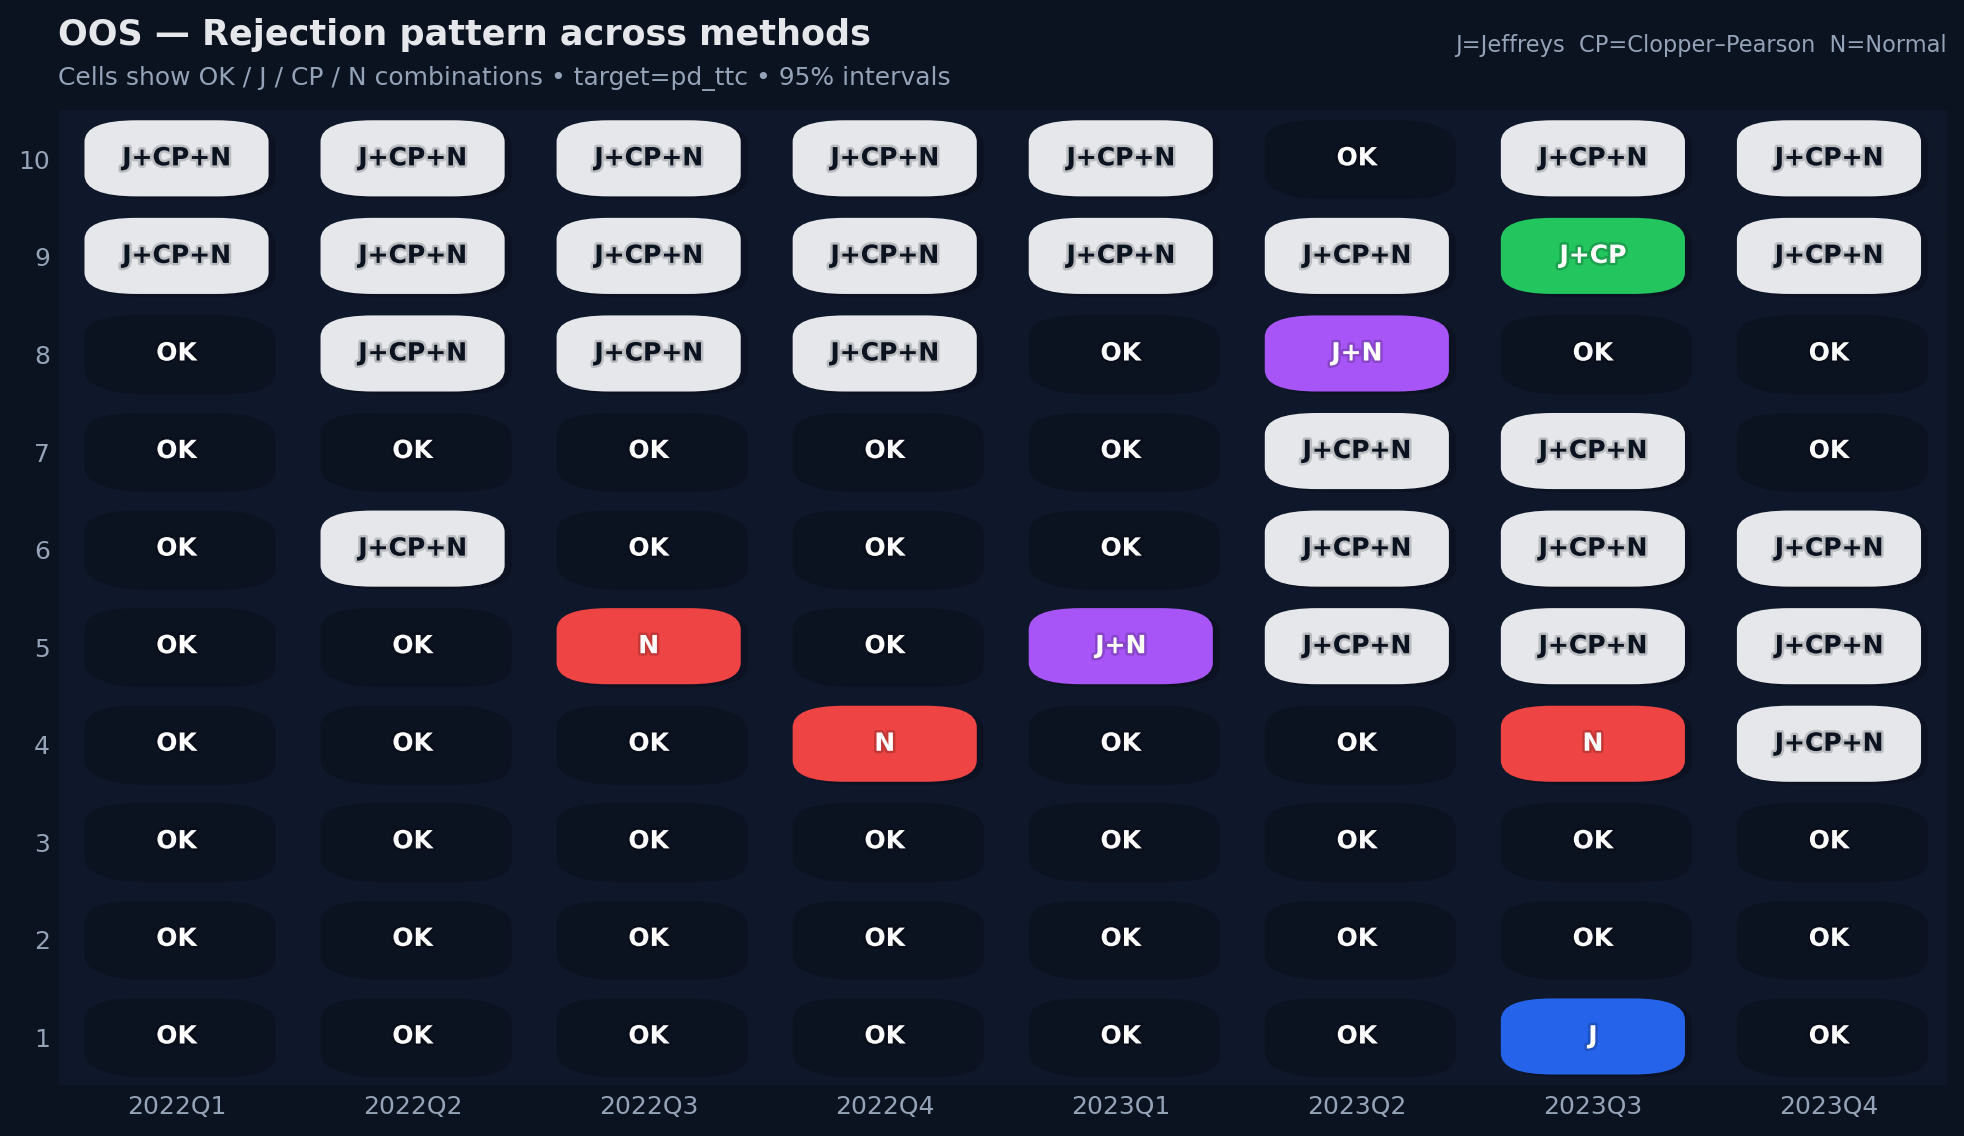

Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig2_combined_color_rounded.pdf
Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig2_combined_color_rounded.png


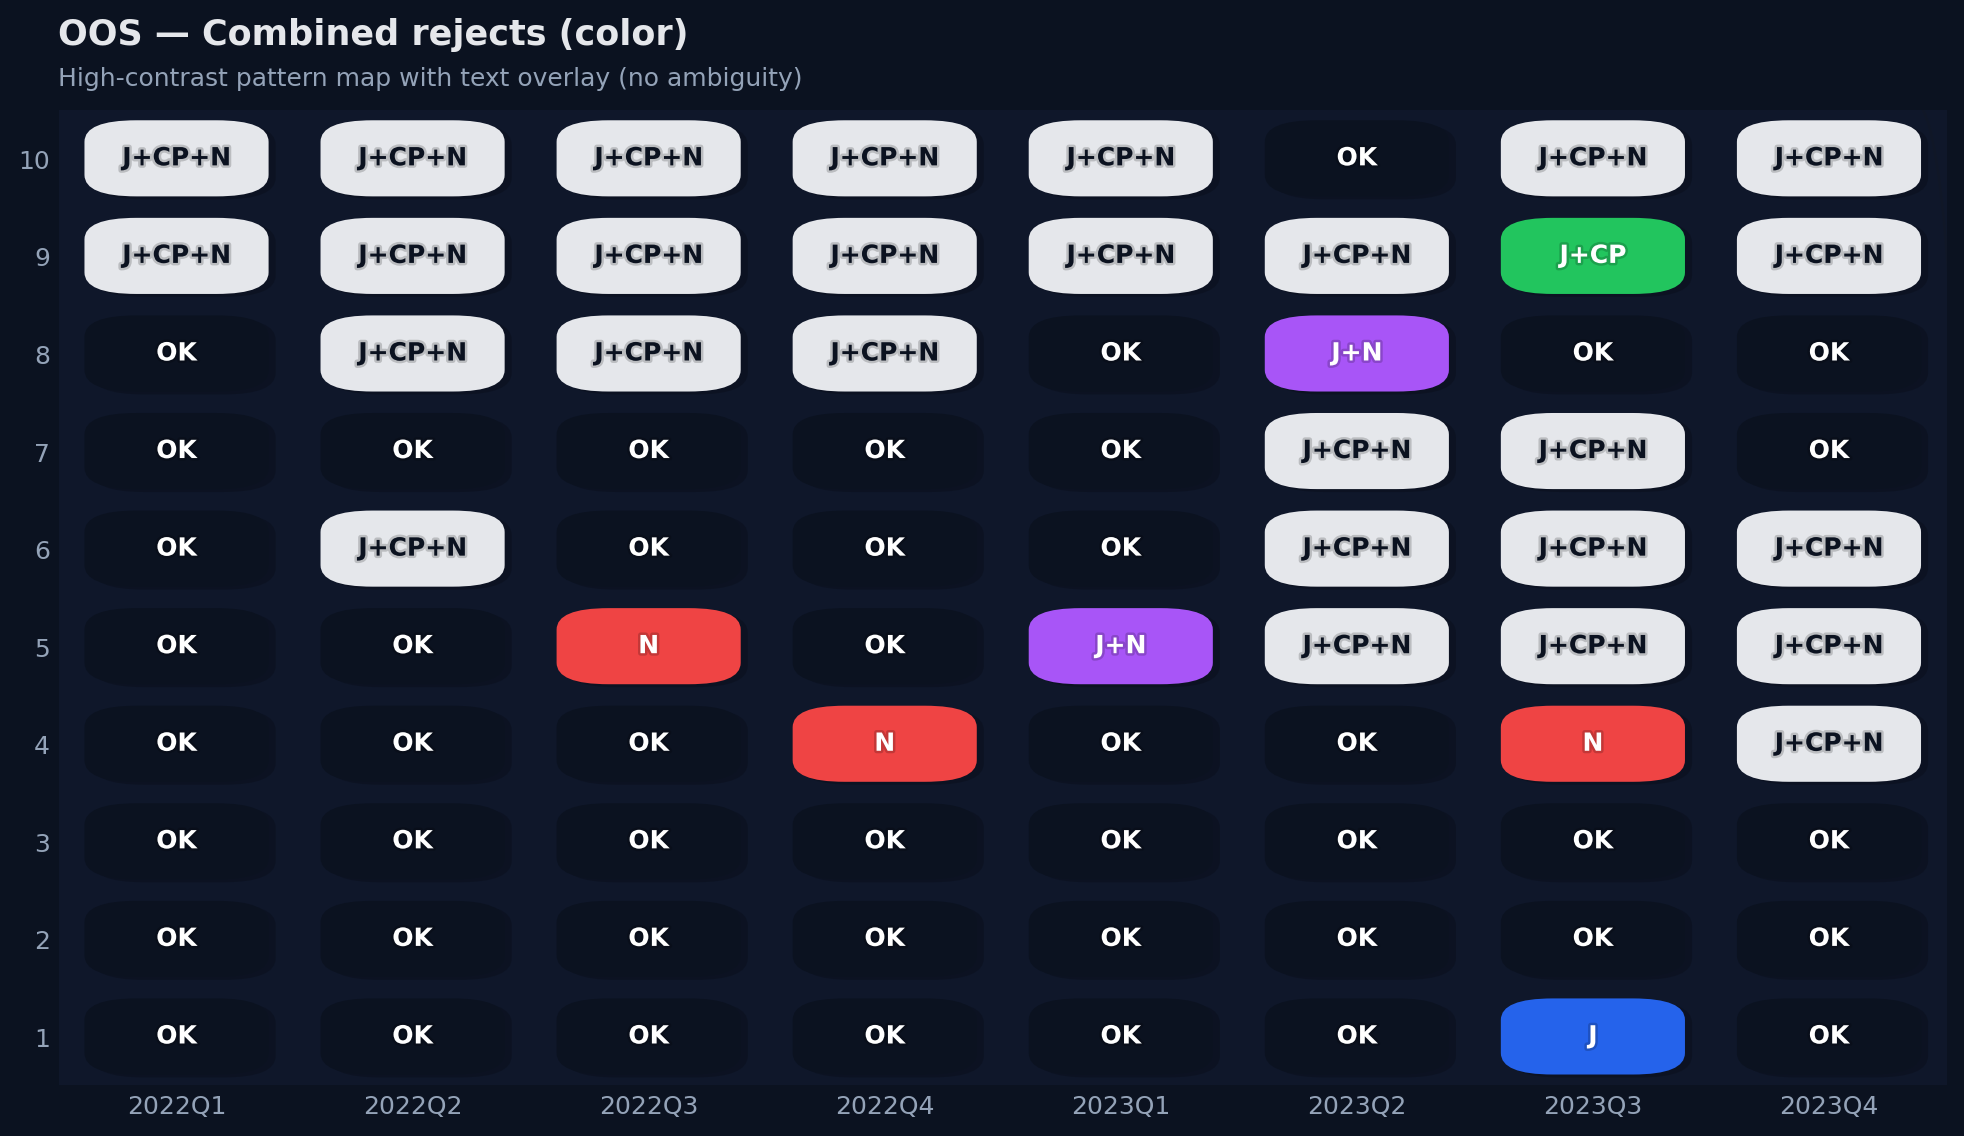

Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig3_jeffreys_binary_rounded.pdf
Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig3_jeffreys_binary_rounded.png


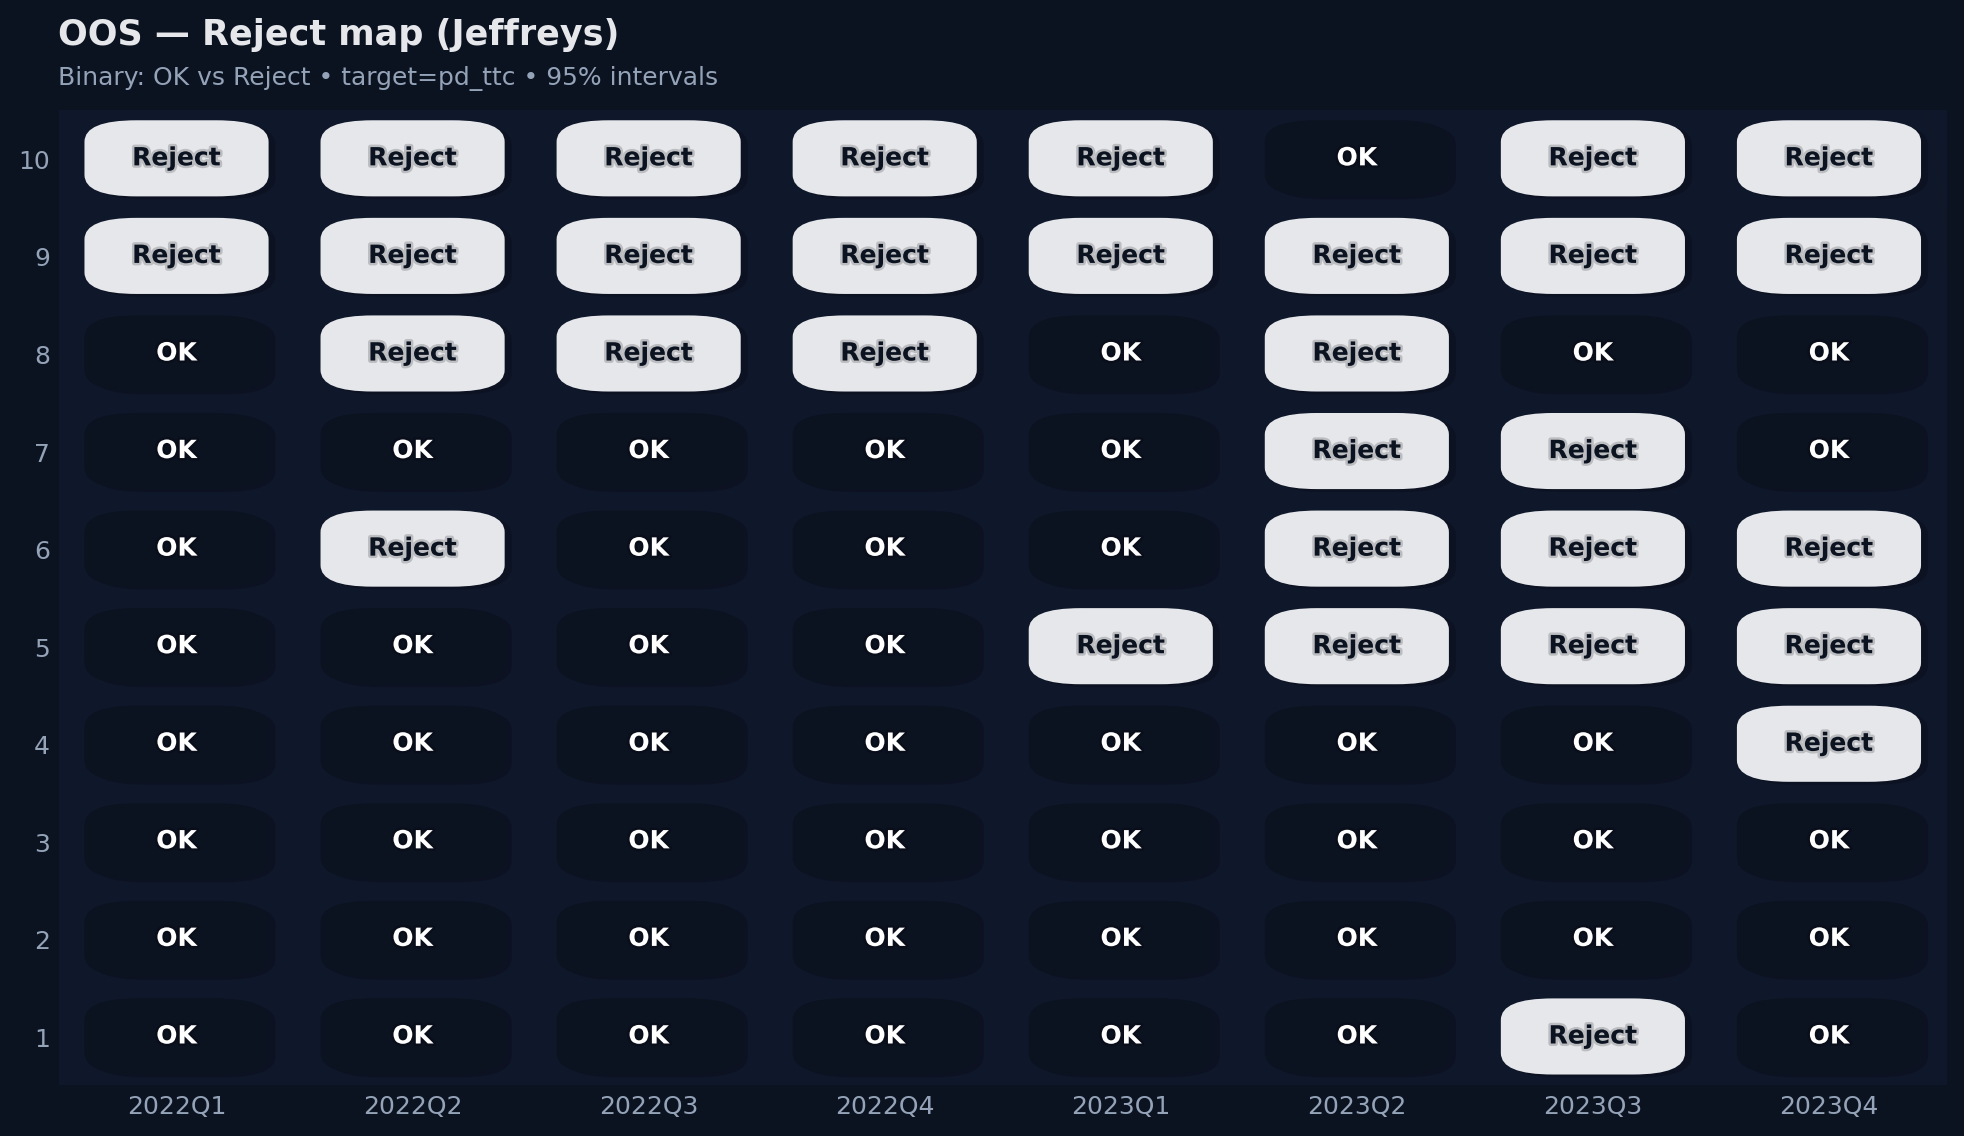

Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig4_cp_binary_rounded.pdf
Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig4_cp_binary_rounded.png


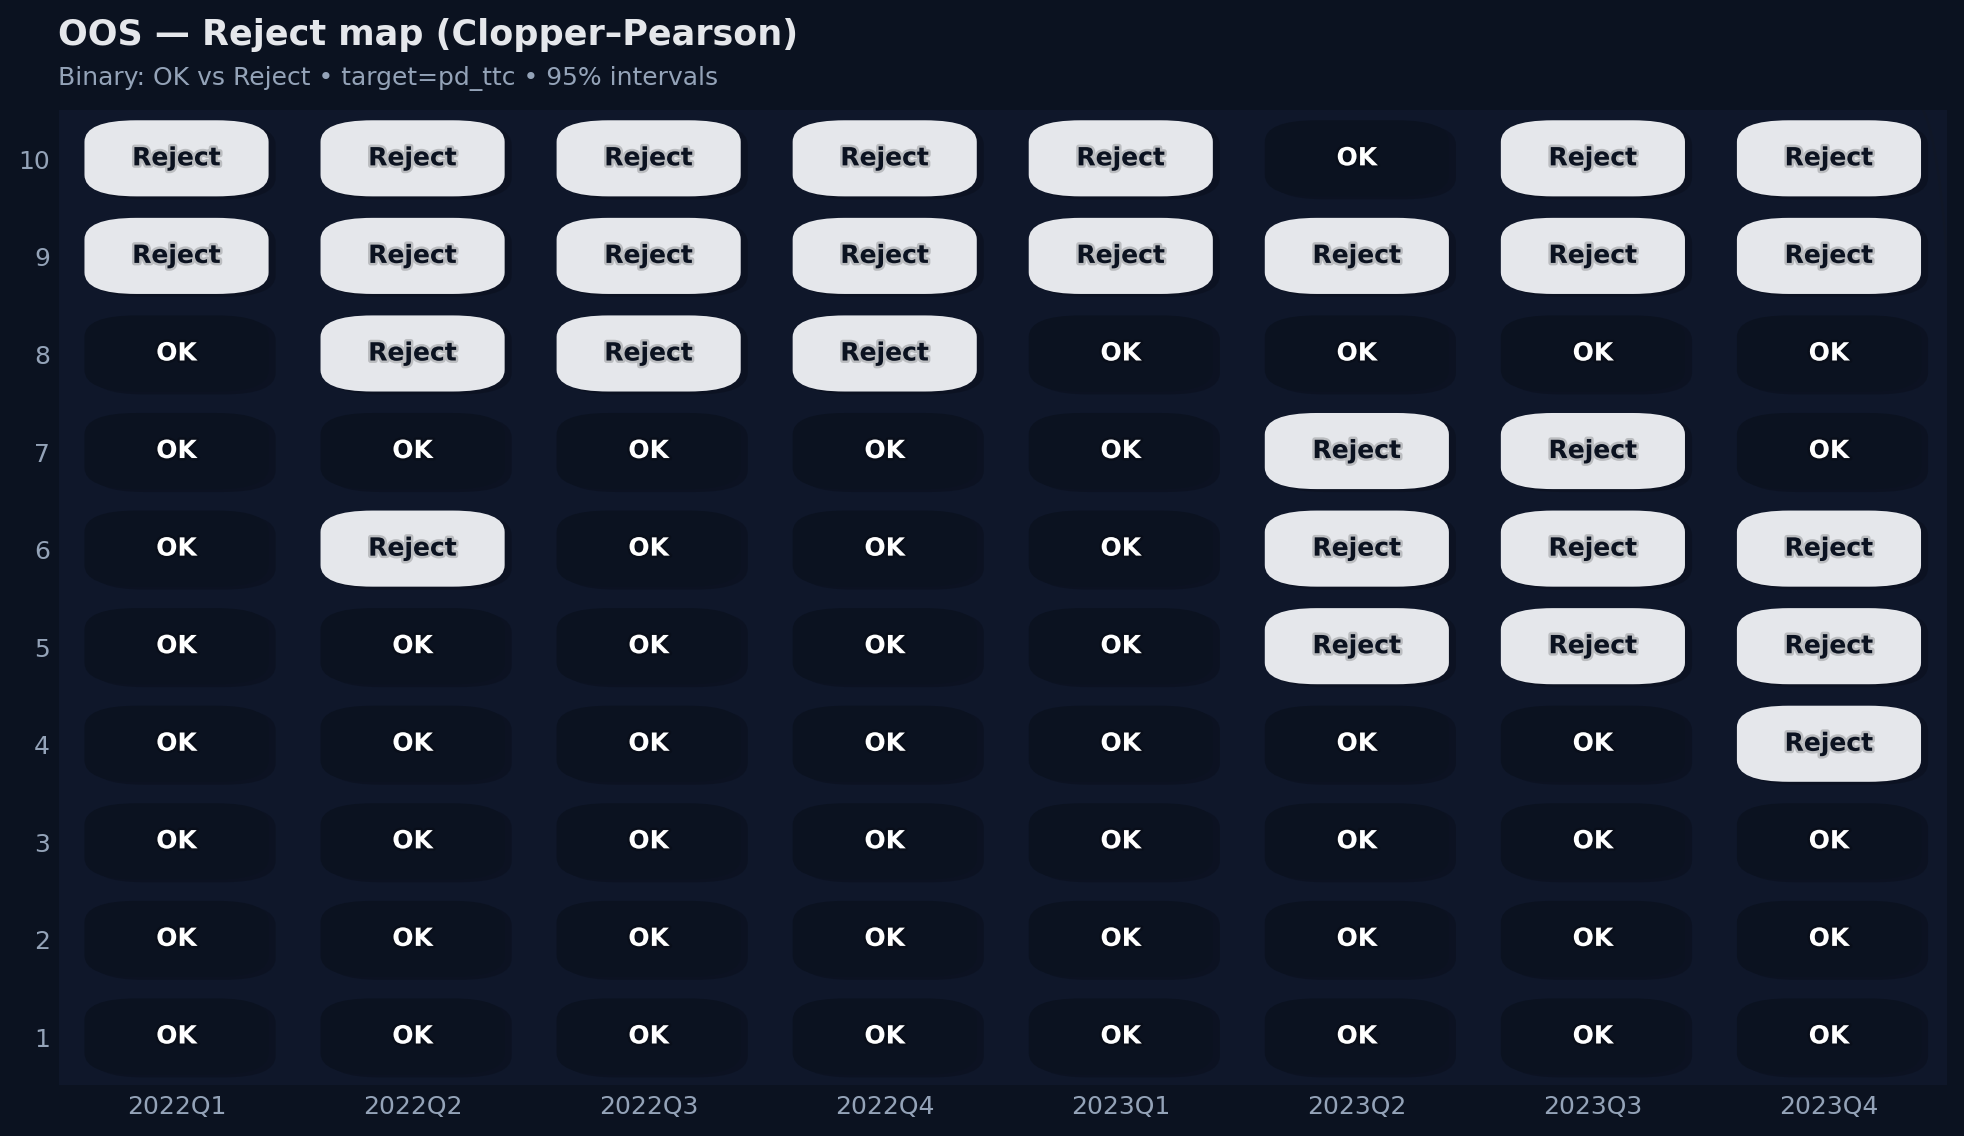

Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig5_normal_binary_rounded.pdf
Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig5_normal_binary_rounded.png


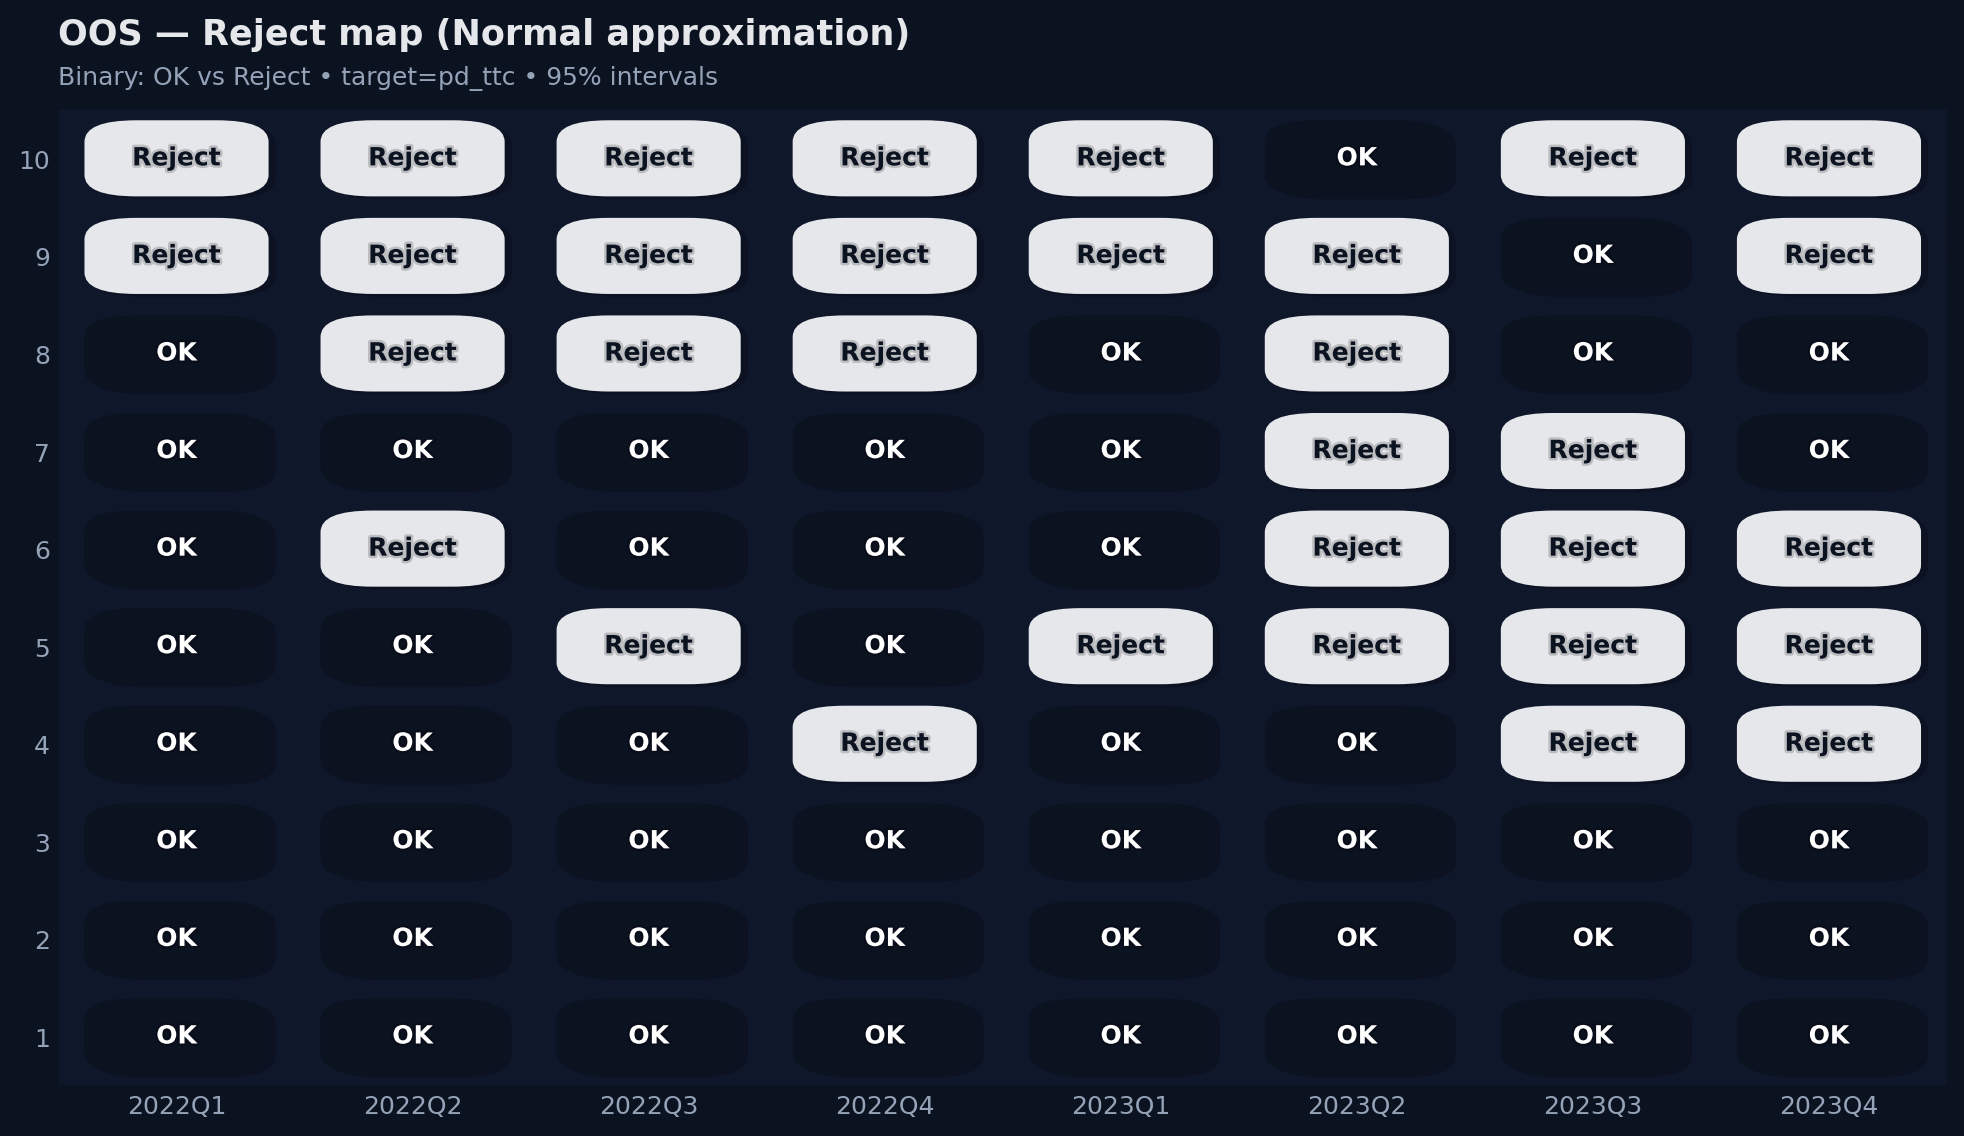


✔ Done. 5 smooth figures saved in: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures


In [5]:
# ============================================================
# 5 FIGURES — "SMOOTH PRO" (Figma-like) WITH ROUNDED CELLS
# - No "imshow" pixels: we draw each cell as a rounded rectangle + subtle shadow
# - Looks like a graphic software export
# - 8 quarters x 10 grades is PERFECT for this (only 80 cells)
#
# Outputs (PDF + PNG):
#   fig1_combined_text_rounded.*
#   fig2_combined_color_rounded.*
#   fig3_jeffreys_binary_rounded.*
#   fig4_cp_binary_rounded.*
#   fig5_normal_binary_rounded.*
# ============================================================

from __future__ import annotations

import sys, json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.patches import FancyBboxPatch
from matplotlib import patheffects

# -------------------------
# 0) Root detection
# -------------------------
def find_project_root(start: Path | None = None) -> Path:
    start = (start or Path.cwd()).resolve()
    markers = {"pyproject.toml", "Makefile", ".git"}
    for p in [start] + list(start.parents):
        if any((p / m).exists() for m in markers):
            return p
    return start

ROOT = find_project_root()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# -------------------------
# 1) Modern typography + rendering
# -------------------------
mpl.rcParams.update({
    "figure.dpi": 180,
    "savefig.dpi": 360,
    "font.family": "DejaVu Sans",
    "font.size": 10,
    "axes.titlesize": 14,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": False,
    "axes.spines.bottom": False,
})

# -------------------------
# 2) Project intervals (needed for J / CP / Normal comparison)
# -------------------------
from experiments.stats.intervals import jeffreys_alpha2, exact_cp, approx_normal

# -------------------------
# 3) CONFIG
# -------------------------
CONF_LEVEL = 0.95

OOS_PATH = ROOT / "data" / "processed" / "scored" / "oos_scored.parquet"
BUCKET_STATS_PATH = ROOT / "artifacts" / "model_from_binned" / "bucket_stats.json"
BUCKET_SECTION = "train"

VINTAGE_COL = "vintage"
GRADE_COL = "grade"
DEFAULT_COL = "default_12m"
PD_LOAN_COL = "pd"

TEST_TARGET = "pd_ttc"      # or "pd_hat"

# text in combined figures
SHOW_OK_TEXT = True
TEXT_FONTSIZE = 10

# where to save
OUTDIR = ROOT / "artifacts" / "paper_figures"
OUTDIR.mkdir(parents=True, exist_ok=True)

assert OOS_PATH.exists(), f"OOS file not found: {OOS_PATH}"
assert BUCKET_STATS_PATH.exists(), f"bucket_stats.json not found: {BUCKET_STATS_PATH}"

# -------------------------
# 4) Helpers (data)
# -------------------------
def _safe_int_grade(x) -> int:
    try:
        return int(float(x))
    except Exception:
        return int(x)

def parse_vintage_to_period(s: pd.Series) -> pd.PeriodIndex:
    s_str = s.astype(str).str.strip()
    m = s_str.str.upper().str.replace(" ", "", regex=False).str.match(r"^\d{4}-?Q[1-4]$")
    if m.all():
        cleaned = s_str.str.upper().str.replace(" ", "", regex=False).str.replace("-", "", regex=False)
        return pd.PeriodIndex(cleaned, freq="Q")
    dt = pd.to_datetime(s_str, errors="coerce")
    if float(dt.notna().mean()) < 0.95:
        bad = s_str[dt.isna()].head(10).tolist()
        raise ValueError(f"Cannot parse vintage. Examples: {bad}")
    return dt.dt.to_period("Q")

def load_bucket_pd_map(path: Path, section: str) -> dict[int, float]:
    data = json.loads(path.read_text(encoding="utf-8"))
    if section not in data:
        raise KeyError(f"'{section}' not in bucket_stats.json. Keys: {list(data.keys())}")
    return {int(e["bucket"]): float(e["pd"]) for e in data[section]}

def build_vintage_grade_table(df: pd.DataFrame, pd_ttc_map: dict[int, float]) -> pd.DataFrame:
    cols = [VINTAGE_COL, GRADE_COL, DEFAULT_COL]
    use_pd = PD_LOAN_COL in df.columns
    if use_pd:
        cols.append(PD_LOAN_COL)

    x = df[cols].copy()
    x[GRADE_COL] = x[GRADE_COL].map(_safe_int_grade)

    if use_pd:
        agg = x.groupby([VINTAGE_COL, GRADE_COL], as_index=False).agg(
            n=(DEFAULT_COL, "count"),
            d=(DEFAULT_COL, "sum"),
            pd_hat=(PD_LOAN_COL, "mean"),
        )
    else:
        agg = x.groupby([VINTAGE_COL, GRADE_COL], as_index=False).agg(
            n=(DEFAULT_COL, "count"),
            d=(DEFAULT_COL, "sum"),
        )
        agg["pd_hat"] = np.nan

    agg["pd_obs"] = agg["d"] / agg["n"]
    agg["pd_ttc"] = agg[GRADE_COL].map(pd_ttc_map).astype(float)

    per = parse_vintage_to_period(agg[VINTAGE_COL])
    agg["_per"] = per
    agg = agg.sort_values(["_per", GRADE_COL]).drop(columns=["_per"]).reset_index(drop=True)
    return agg

def compute_rejects(df_vg: pd.DataFrame, test_target: str, conf: float) -> pd.DataFrame:
    out = df_vg.copy()
    out["p0"] = out[test_target].astype(float)

    n_arr = out["n"].to_numpy(int)
    d_arr = out["d"].to_numpy(int)
    p0_arr = out["p0"].to_numpy(float)
    ok = np.isfinite(p0_arr) & (n_arr > 0)

    rej_j = np.full(len(out), np.nan)
    rej_cp = np.full(len(out), np.nan)
    rej_n = np.full(len(out), np.nan)

    for i, (n, d) in enumerate(zip(n_arr, d_arr)):
        if not ok[i]:
            continue

        lb, ub = jeffreys_alpha2(n, d, conf)
        if np.isfinite(lb) and np.isfinite(ub):
            rej_j[i] = float(not (p0_arr[i] >= lb and p0_arr[i] <= ub))

        lb, ub = exact_cp(n, d, conf)
        if np.isfinite(lb) and np.isfinite(ub):
            rej_cp[i] = float(not (p0_arr[i] >= lb and p0_arr[i] <= ub))

        lb, ub = approx_normal(n, d, conf)
        lb = max(0.0, float(lb)); ub = min(1.0, float(ub))
        if np.isfinite(lb) and np.isfinite(ub):
            rej_n[i] = float(not (p0_arr[i] >= lb and p0_arr[i] <= ub))

    out["reject_jeffreys"] = rej_j
    out["reject_cp"] = rej_cp
    out["reject_normal"] = rej_n
    return out

def prep_pivots(df_long: pd.DataFrame):
    tmp = df_long.copy()
    tmp[VINTAGE_COL] = tmp[VINTAGE_COL].astype(str)
    tmp[GRADE_COL] = tmp[GRADE_COL].astype(int)

    per = parse_vintage_to_period(tmp[VINTAGE_COL])
    order = (
        tmp[[VINTAGE_COL]].assign(_per=per).drop_duplicates()
        .sort_values("_per")[VINTAGE_COL].astype(str).tolist()
    )
    tmp[VINTAGE_COL] = pd.Categorical(tmp[VINTAGE_COL], categories=order, ordered=True)

    matJ  = tmp.pivot(index=GRADE_COL, columns=VINTAGE_COL, values="reject_jeffreys").sort_index()
    matCP = tmp.pivot(index=GRADE_COL, columns=VINTAGE_COL, values="reject_cp").sort_index()
    matN  = tmp.pivot(index=GRADE_COL, columns=VINTAGE_COL, values="reject_normal").sort_index()

    A = matJ.to_numpy(float)
    B = matCP.to_numpy(float)
    C = matN.to_numpy(float)
    computable = np.isfinite(A) & np.isfinite(B) & np.isfinite(C)

    return matJ, matCP, matN, A, B, C, computable

def combo_label(j, cp, n, show_ok=True):
    parts = []
    if j:  parts.append("J")
    if cp: parts.append("CP")
    if n:  parts.append("N")
    if len(parts) == 0:
        return "OK" if show_ok else ""
    return "+".join(parts)

# -------------------------
# 5) Smooth renderer (rounded-cell heatmap)
# -------------------------
THEME = {
    "canvas": "#0b1220",     # dark background like pro dashboards
    "panel":  "#0f172a",     # slightly lighter
    "grid":   "#1f2937",
    "muted":  "#94a3b8",
    "text":   "#e5e7eb",
    "white":  "#ffffff",
}

def _rounded_cell(ax, x, y, w, h, fc, ec=None, lw=0.0, alpha=1.0, rounding=0.18, shadow=True):
    # subtle shadow (looks like Figma)
    if shadow:
        sh = FancyBboxPatch(
            (x + 0.03, y - 0.03), w, h,
            boxstyle=f"round,pad=0.01,rounding_size={rounding}",
            linewidth=0.0, facecolor="black", alpha=0.18, zorder=1
        )
        ax.add_patch(sh)

    patch = FancyBboxPatch(
        (x, y), w, h,
        boxstyle=f"round,pad=0.01,rounding_size={rounding}",
        linewidth=lw, edgecolor=ec if ec else "none",
        facecolor=fc, alpha=alpha, zorder=2
    )
    ax.add_patch(patch)

def draw_smooth_grid(ax, nrows, ncols, xlabels, ylabels, title, subtitle=None):
    ax.set_facecolor(THEME["panel"])
    ax.figure.set_facecolor(THEME["canvas"])

    # coordinate system: cell (c,r) occupies [c, c+1] x [r, r+1]
    ax.set_xlim(0, ncols)
    ax.set_ylim(0, nrows)

    ax.set_xticks(np.arange(ncols) + 0.5)
    ax.set_yticks(np.arange(nrows) + 0.5)
    ax.set_xticklabels(xlabels, color=THEME["muted"])
    ax.set_yticklabels(ylabels, color=THEME["muted"])
    ax.tick_params(length=0)

    # remove spines
    for sp in ax.spines.values():
        sp.set_visible(False)

    # title / subtitle
    ax.text(0.0, 1.06, title, transform=ax.transAxes, ha="left", va="bottom",
            color=THEME["text"], fontsize=14, fontweight=700)
    if subtitle:
        ax.text(0.0, 1.02, subtitle, transform=ax.transAxes, ha="left", va="bottom",
                color=THEME["muted"], fontsize=10)

    # outer rounded panel outline (very subtle)
    outer = FancyBboxPatch(
        (-0.08, -0.08), ncols + 0.16, nrows + 0.16,
        boxstyle="round,pad=0.00,rounding_size=0.22",
        linewidth=1.0, edgecolor="#111827", facecolor="none", alpha=0.9, zorder=0
    )
    ax.add_patch(outer)

def render_matrix_rounded(
    ax, Z, *,
    palette_fn,
    label_fn=None,
    label_color_fn=None,
    nan_color="#111827",
    cell_pad=0.10,
    rounding=0.20
):
    nrows, ncols = Z.shape
    for r in range(nrows):
        for c in range(ncols):
            v = Z[r, c]
            fc = nan_color if not np.isfinite(v) else palette_fn(v)
            x = c + cell_pad
            y = r + cell_pad
            w = 1 - 2 * cell_pad
            h = 1 - 2 * cell_pad
            _rounded_cell(ax, x, y, w, h, fc=fc, rounding=rounding, shadow=True)

            if label_fn is not None:
                t = label_fn(r, c, v)
                if t:
                    col = label_color_fn(r, c, v, fc) if label_color_fn else THEME["text"]
                    ax.text(
                        c + 0.5, r + 0.5, t,
                        ha="center", va="center",
                        color=col, fontsize=TEXT_FONTSIZE, fontweight=700, zorder=3,
                        path_effects=[patheffects.withStroke(linewidth=2, foreground="black", alpha=0.18)]
                    )

def save_fig(fig, name):
    pdf = OUTDIR / f"{name}.pdf"
    png = OUTDIR / f"{name}.png"
    fig.savefig(pdf, bbox_inches="tight")
    fig.savefig(png, bbox_inches="tight")
    print("Saved:", pdf)
    print("Saved:", png)

# -------------------------
# 6) Load + compute matrices
# -------------------------
df_oos = pd.read_parquet(OOS_PATH)
pd_ttc_map = load_bucket_pd_map(BUCKET_STATS_PATH, BUCKET_SECTION)

df_vg = build_vintage_grade_table(df_oos, pd_ttc_map=pd_ttc_map)

test_target = TEST_TARGET
if test_target not in df_vg.columns or df_vg[test_target].isna().all():
    test_target = "pd_ttc"
    print("[WARN] TEST_TARGET unavailable, fallback to pd_ttc")

df_long = compute_rejects(df_vg, test_target=test_target, conf=CONF_LEVEL)
matJ, matCP, matN, A, B, C, computable = prep_pivots(df_long)

xlabels = matJ.columns.astype(str).tolist()
ylabels = matJ.index.tolist()
nrows, ncols = A.shape

# Labels for combined plots
labels = np.empty(A.shape, dtype=object)
labels[:] = ""
for r in range(nrows):
    for c in range(ncols):
        if computable[r, c]:
            labels[r, c] = combo_label(int(A[r, c]), int(B[r, c]), int(C[r, c]), show_ok=SHOW_OK_TEXT)

# Code matrix for combined COLOR (0..7)
CODE = np.full(A.shape, np.nan)
for r in range(nrows):
    for c in range(ncols):
        if computable[r, c]:
            j, cp, n = int(A[r, c]), int(B[r, c]), int(C[r, c])
            CODE[r, c] = (1*j + 2*cp + 4*n)

# -------------------------
# 7) Palettes (smooth + professional)
# -------------------------
# Combined patterns (0..7) — modern, balanced saturation
PATTERN_COLORS = {
    0: "#0b1220",  # OK: blend with panel (almost invisible, but not empty due to rounded tile)
    1: "#2563eb",  # J (blue)
    2: "#f97316",  # CP (orange)
    3: "#22c55e",  # J+CP (green)
    4: "#ef4444",  # N (red)
    5: "#a855f7",  # J+N (purple)
    6: "#64748b",  # CP+N (slate)
    7: "#e5e7eb",  # all (near-white tile, stands out)
}

def palette_combined(code):
    i = int(code)
    return PATTERN_COLORS.get(i, "#111827")

def label_color_combined(r, c, v, fc):
    # ensure readability: dark tiles -> white text, bright tiles -> dark text
    if not np.isfinite(v):
        return THEME["muted"]
    i = int(v)
    return "#0b1220" if i == 7 else "#ffffff"

# Binary palette (OK vs Reject)
BIN_OK = "#0b1220"
BIN_REJ = "#e5e7eb"
def palette_binary(v):
    if not np.isfinite(v):
        return "#111827"
    return BIN_REJ if int(v) == 1 else BIN_OK

def label_color_binary(r, c, v, fc):
    if not np.isfinite(v):
        return THEME["muted"]
    return "#0b1220" if int(v) == 1 else "#ffffff"

# -------------------------
# 8) FIGURE 1 — Combined TEXT (smooth tiles + labels)
# -------------------------
fig, ax = plt.subplots(figsize=(10.8, 6.2))
draw_smooth_grid(
    ax, nrows, ncols, xlabels, ylabels,
    title="OOS — Rejection pattern across methods",
    subtitle=f"Cells show OK / J / CP / N combinations • target={test_target} • {int(CONF_LEVEL*100)}% intervals"
)

render_matrix_rounded(
    ax, CODE,
    palette_fn=palette_combined,
    label_fn=lambda r, c, v: labels[r, c] if labels[r, c] else "",
    label_color_fn=label_color_combined,
    nan_color="#111827",
    cell_pad=0.12,
    rounding=0.22,
)

# small key (top-right, minimalist)
ax.text(1.0, 1.055, "J=Jeffreys  CP=Clopper–Pearson  N=Normal",
        transform=ax.transAxes, ha="right", va="bottom",
        color=THEME["muted"], fontsize=9)

save_fig(fig, "fig1_combined_text_rounded")
plt.show()

# -------------------------
# 9) FIGURE 2 — Combined COLOR (same, but emphasize color w/ labels)
# -------------------------
fig, ax = plt.subplots(figsize=(10.8, 6.2))
draw_smooth_grid(
    ax, nrows, ncols, xlabels, ylabels,
    title="OOS — Combined rejects (color)",
    subtitle="High-contrast pattern map with text overlay (no ambiguity)"
)

render_matrix_rounded(
    ax, CODE,
    palette_fn=palette_combined,
    label_fn=lambda r, c, v: labels[r, c] if labels[r, c] else "",
    label_color_fn=label_color_combined,
    nan_color="#111827",
    cell_pad=0.12,
    rounding=0.22,
)

save_fig(fig, "fig2_combined_color_rounded")
plt.show()

# -------------------------
# 10) FIGURE 3–5 — Binary per method (smooth tiles)
# -------------------------
def plot_binary_rounded(Z, method_name, filename):
    fig, ax = plt.subplots(figsize=(10.8, 6.2))
    draw_smooth_grid(
        ax, nrows, ncols, xlabels, ylabels,
        title=f"OOS — Reject map ({method_name})",
        subtitle=f"Binary: OK vs Reject • target={test_target} • {int(CONF_LEVEL*100)}% intervals"
    )
    render_matrix_rounded(
        ax, Z,
        palette_fn=palette_binary,
        label_fn=lambda r, c, v: ("Reject" if np.isfinite(v) and int(v) == 1 else "OK") if np.isfinite(v) else "",
        label_color_fn=label_color_binary,
        nan_color="#111827",
        cell_pad=0.12,
        rounding=0.22,
    )
    save_fig(fig, filename)
    plt.show()

plot_binary_rounded(A, "Jeffreys", "fig3_jeffreys_binary_rounded")
plot_binary_rounded(B, "Clopper–Pearson", "fig4_cp_binary_rounded")
plot_binary_rounded(C, "Normal approximation", "fig5_normal_binary_rounded")

print("\n✔ Done. 5 smooth figures saved in:", OUTDIR)


Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig1_combined_text_white.pdf
Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig1_combined_text_white.png


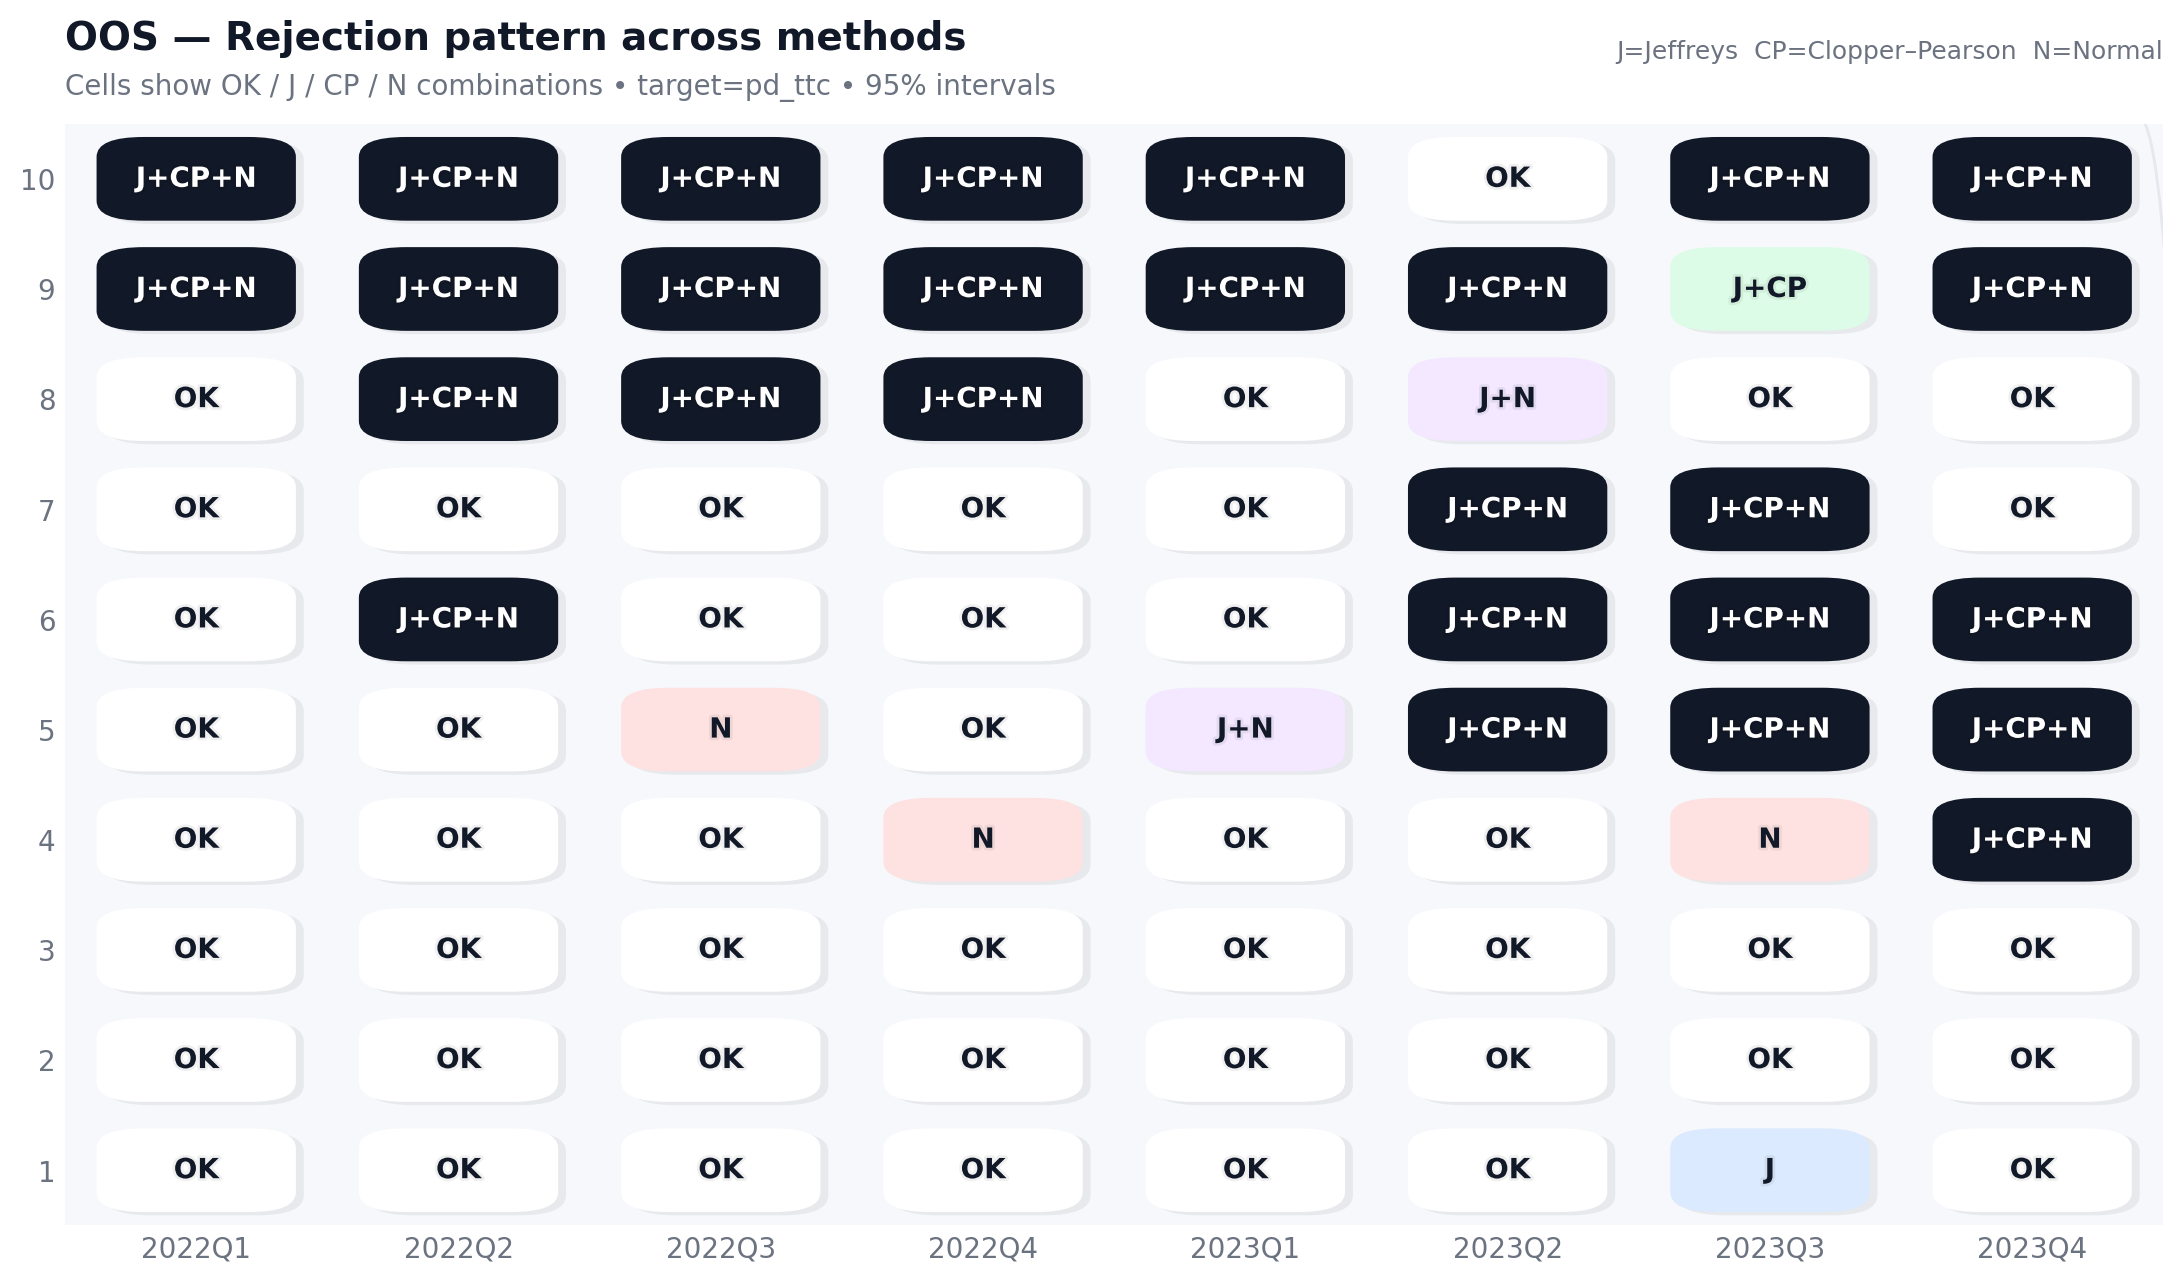

Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig2_combined_color_white.pdf
Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig2_combined_color_white.png


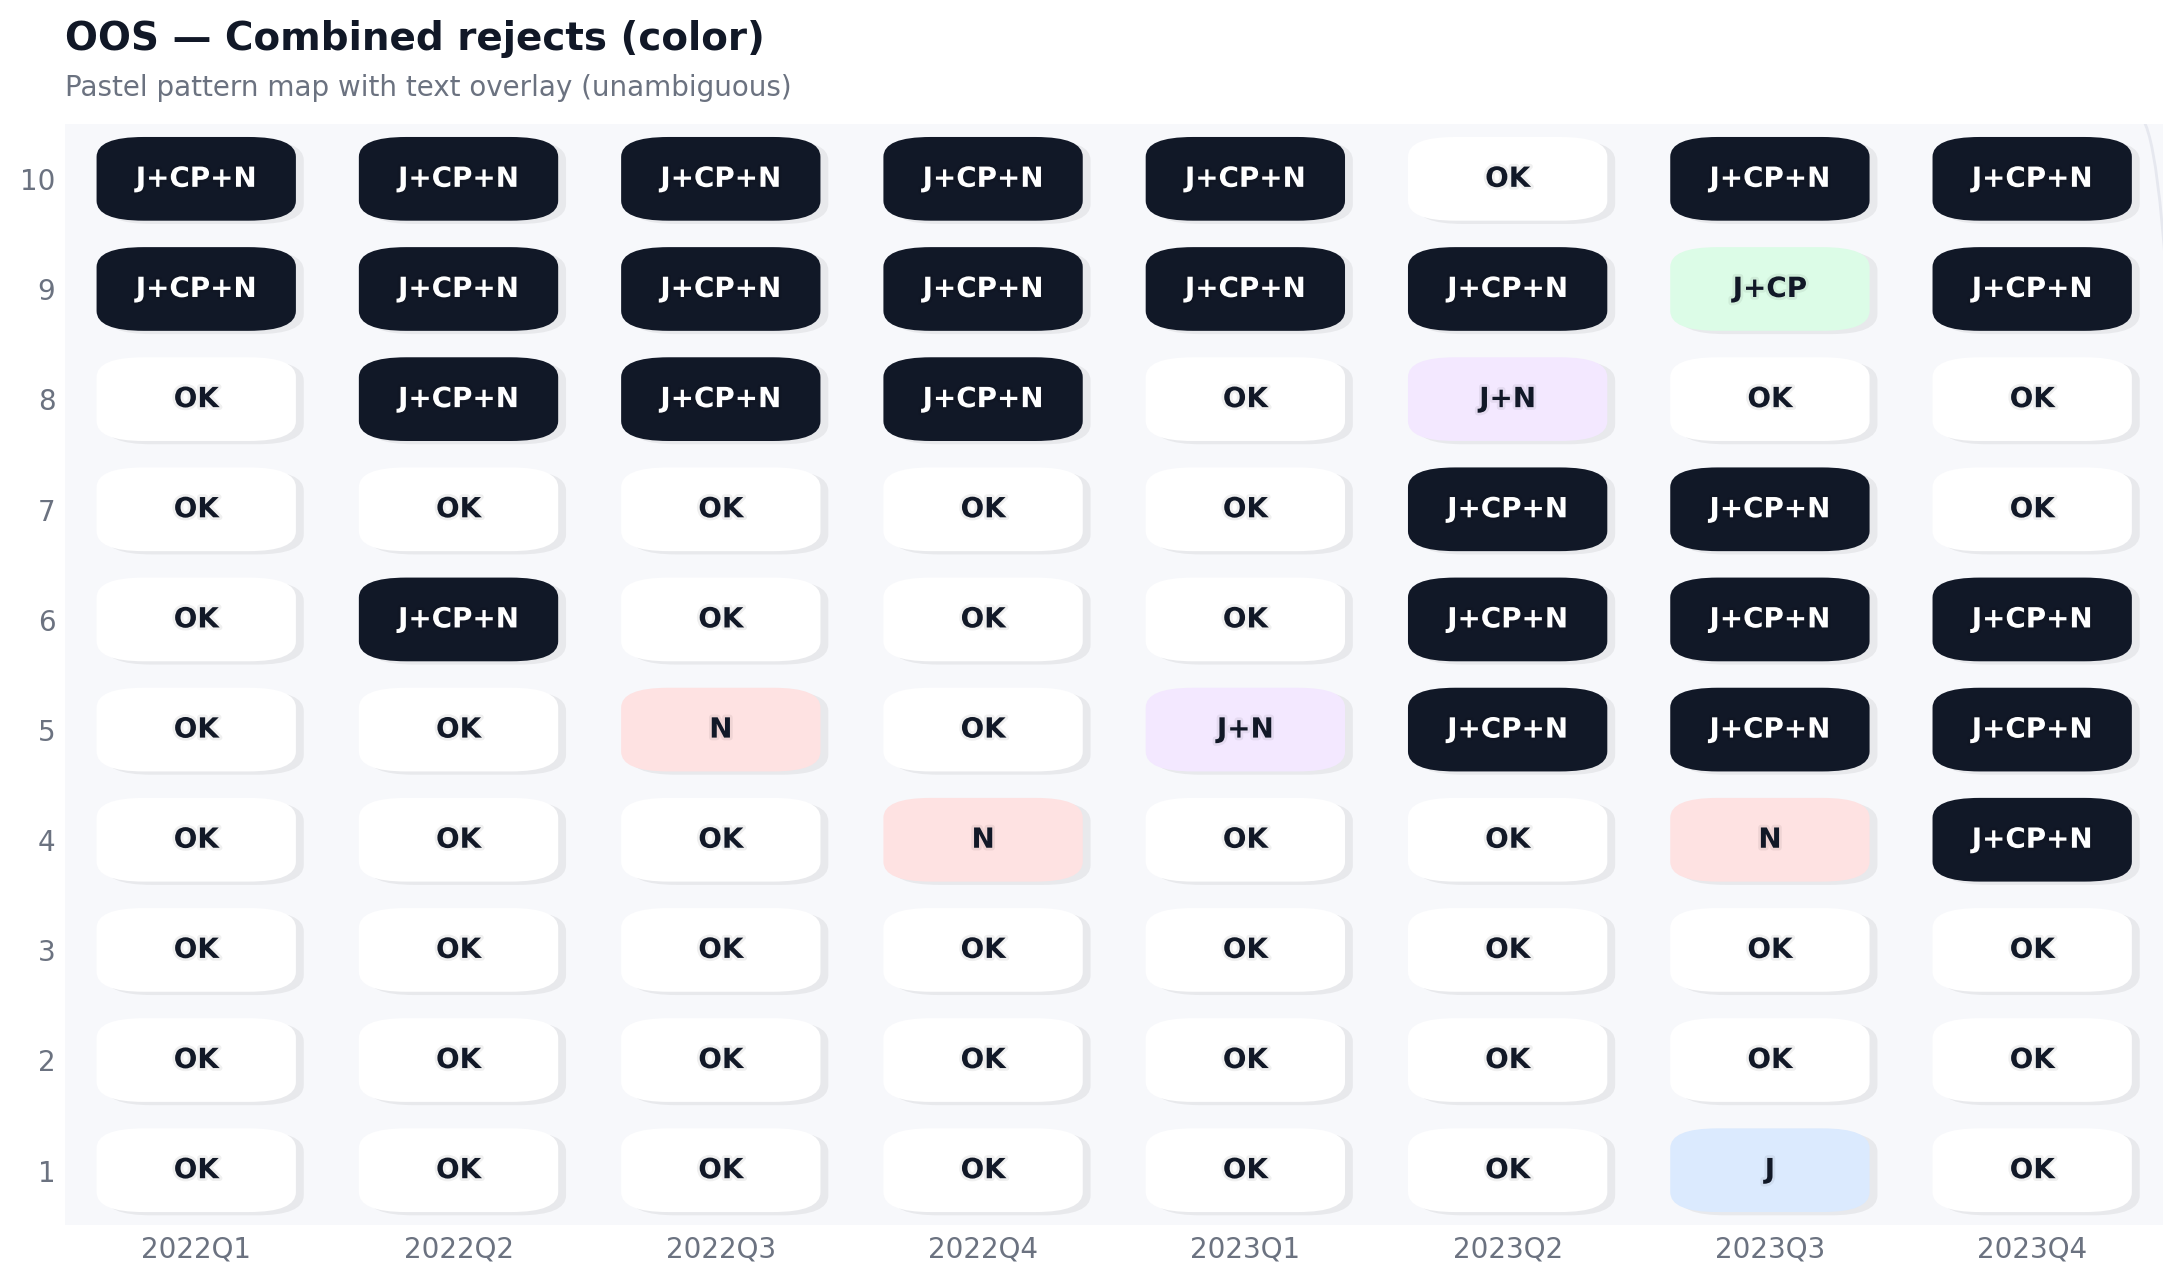

Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig3_jeffreys_binary_white.pdf
Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig3_jeffreys_binary_white.png


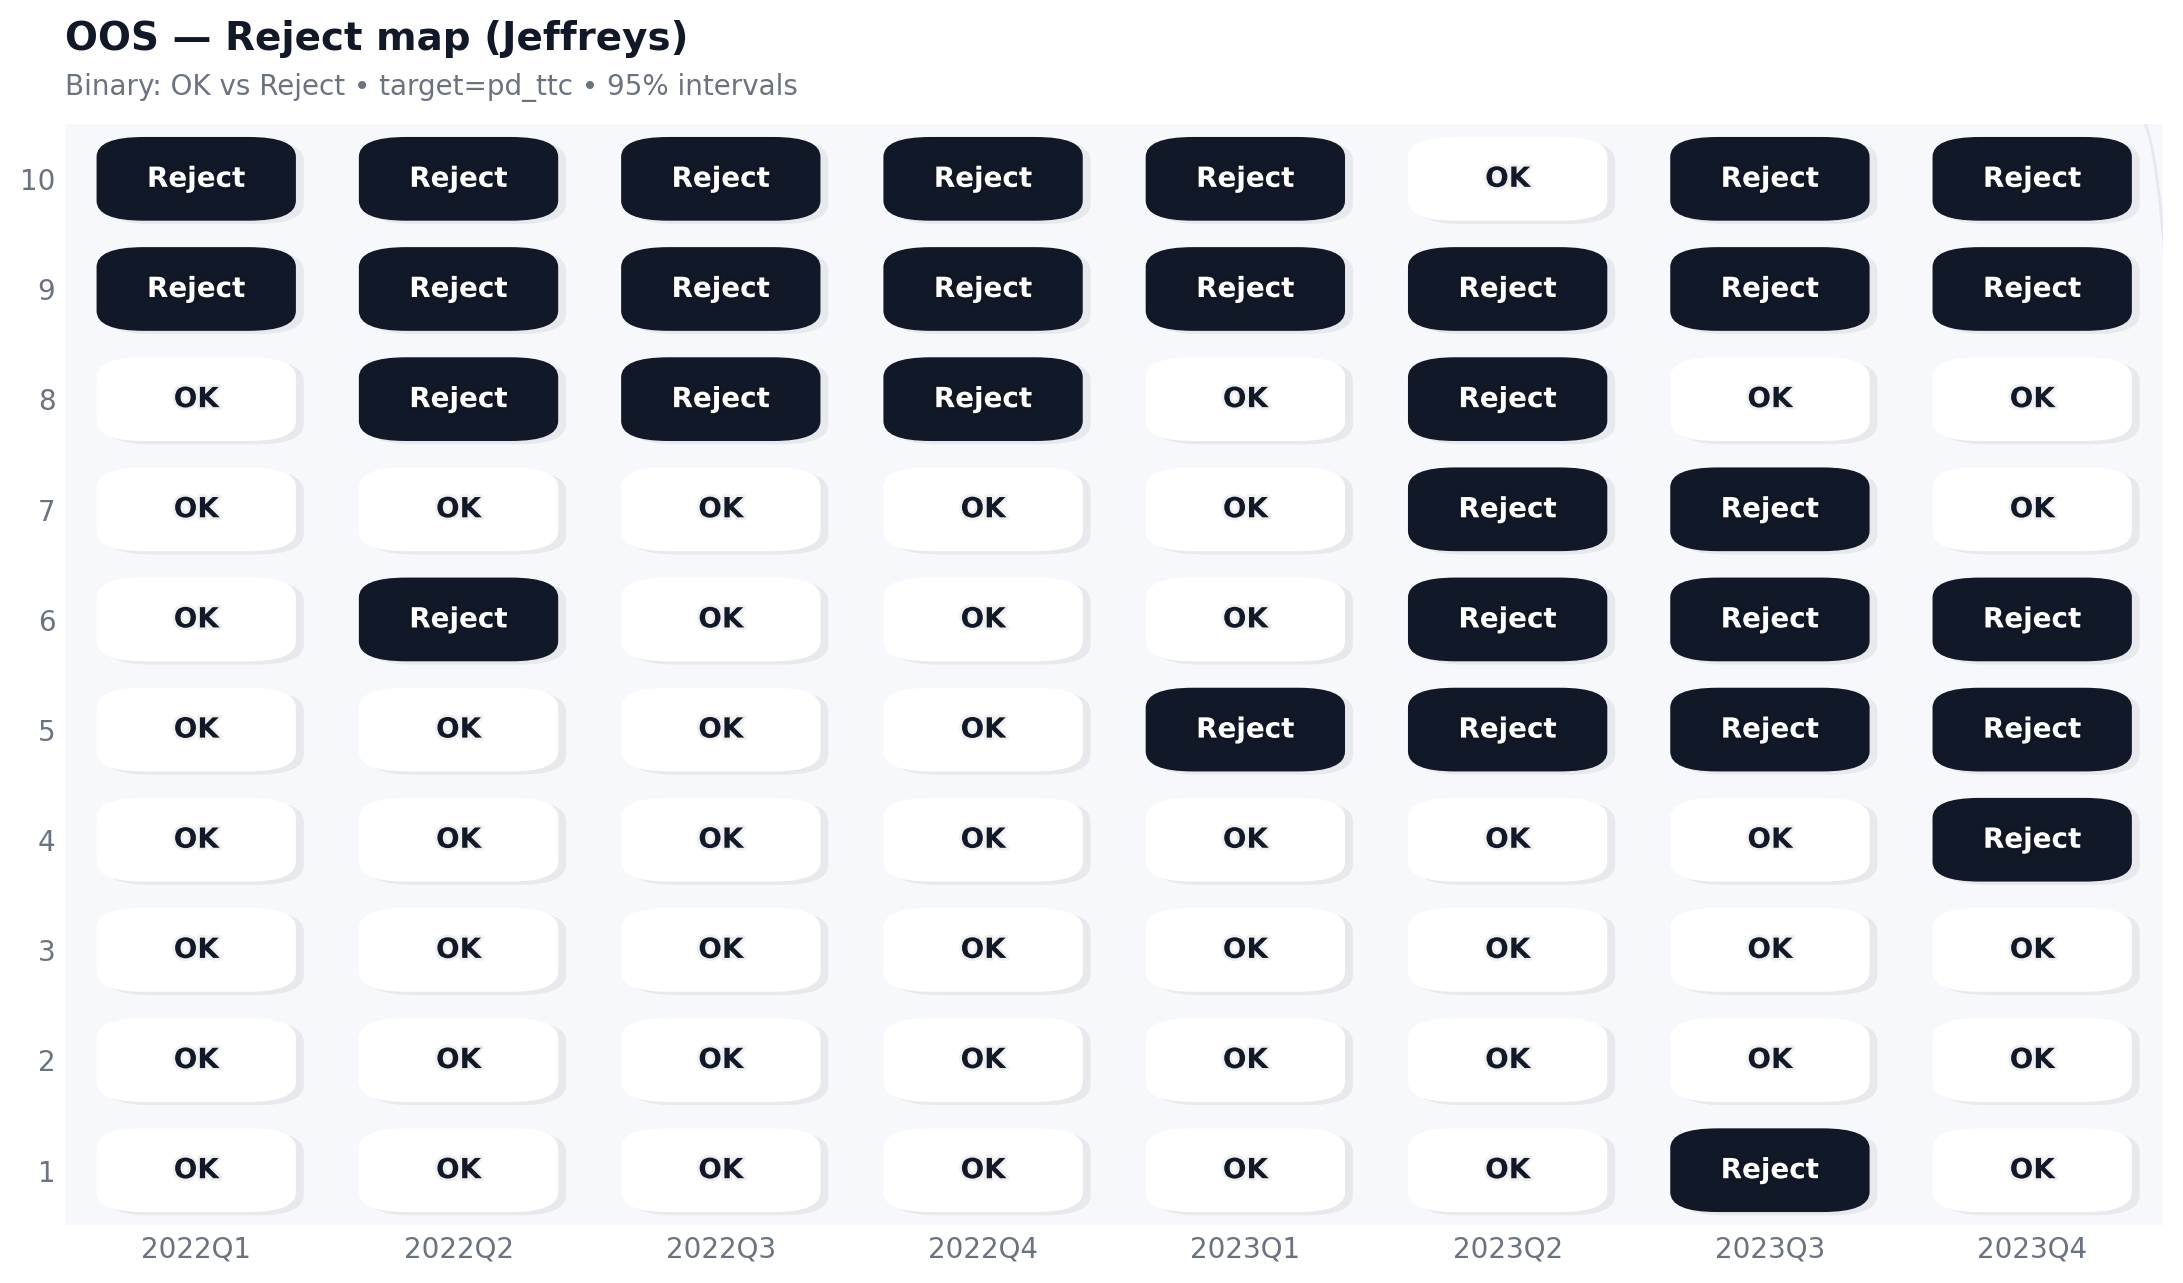

Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig4_cp_binary_white.pdf
Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig4_cp_binary_white.png


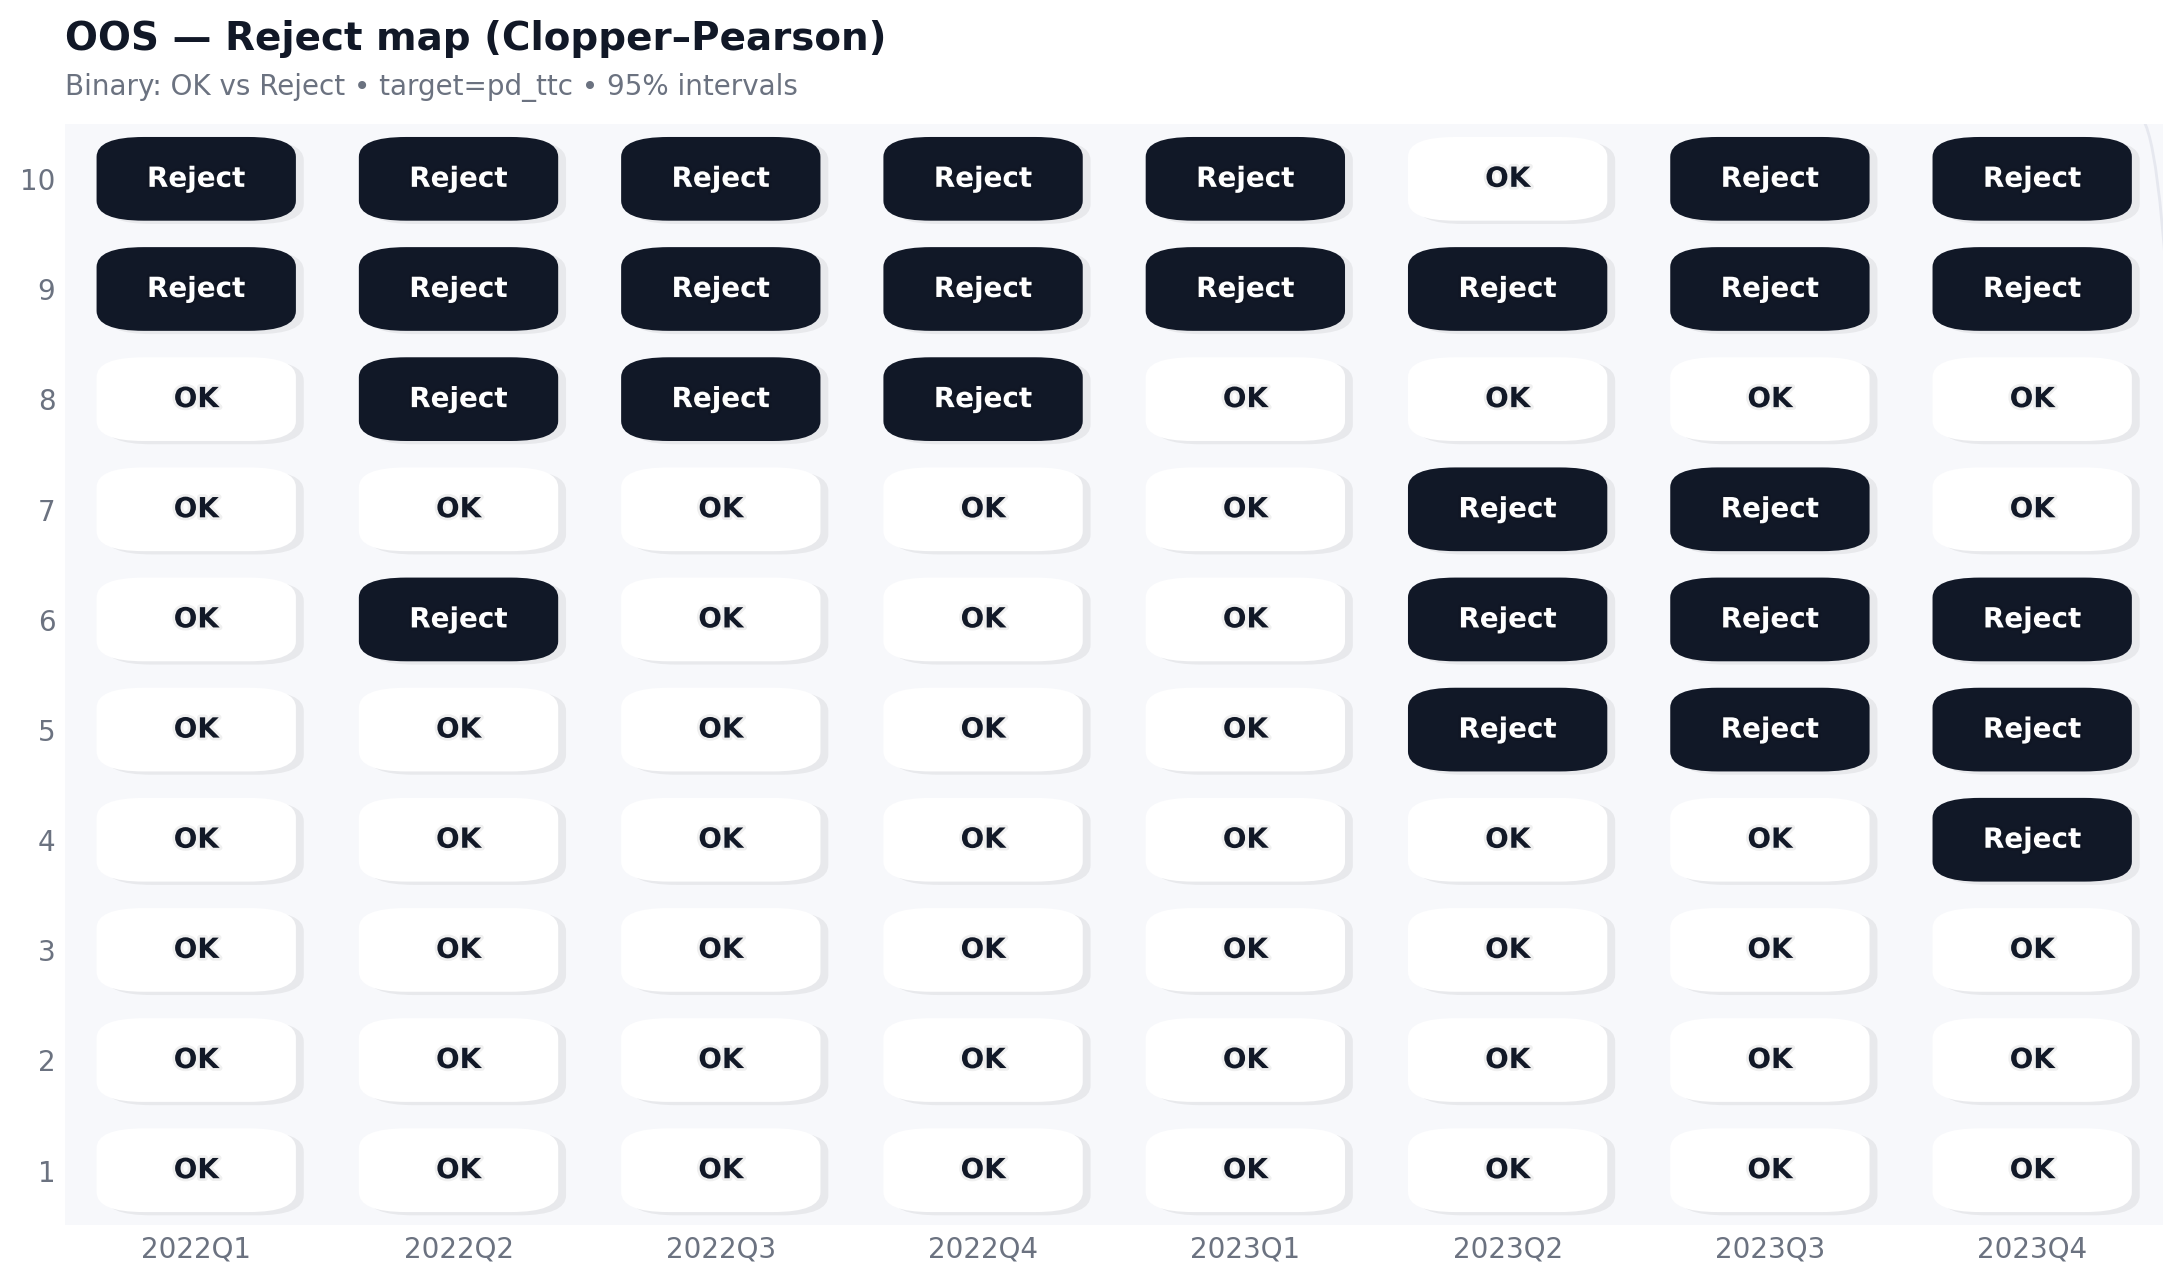

Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig5_normal_binary_white.pdf
Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig5_normal_binary_white.png


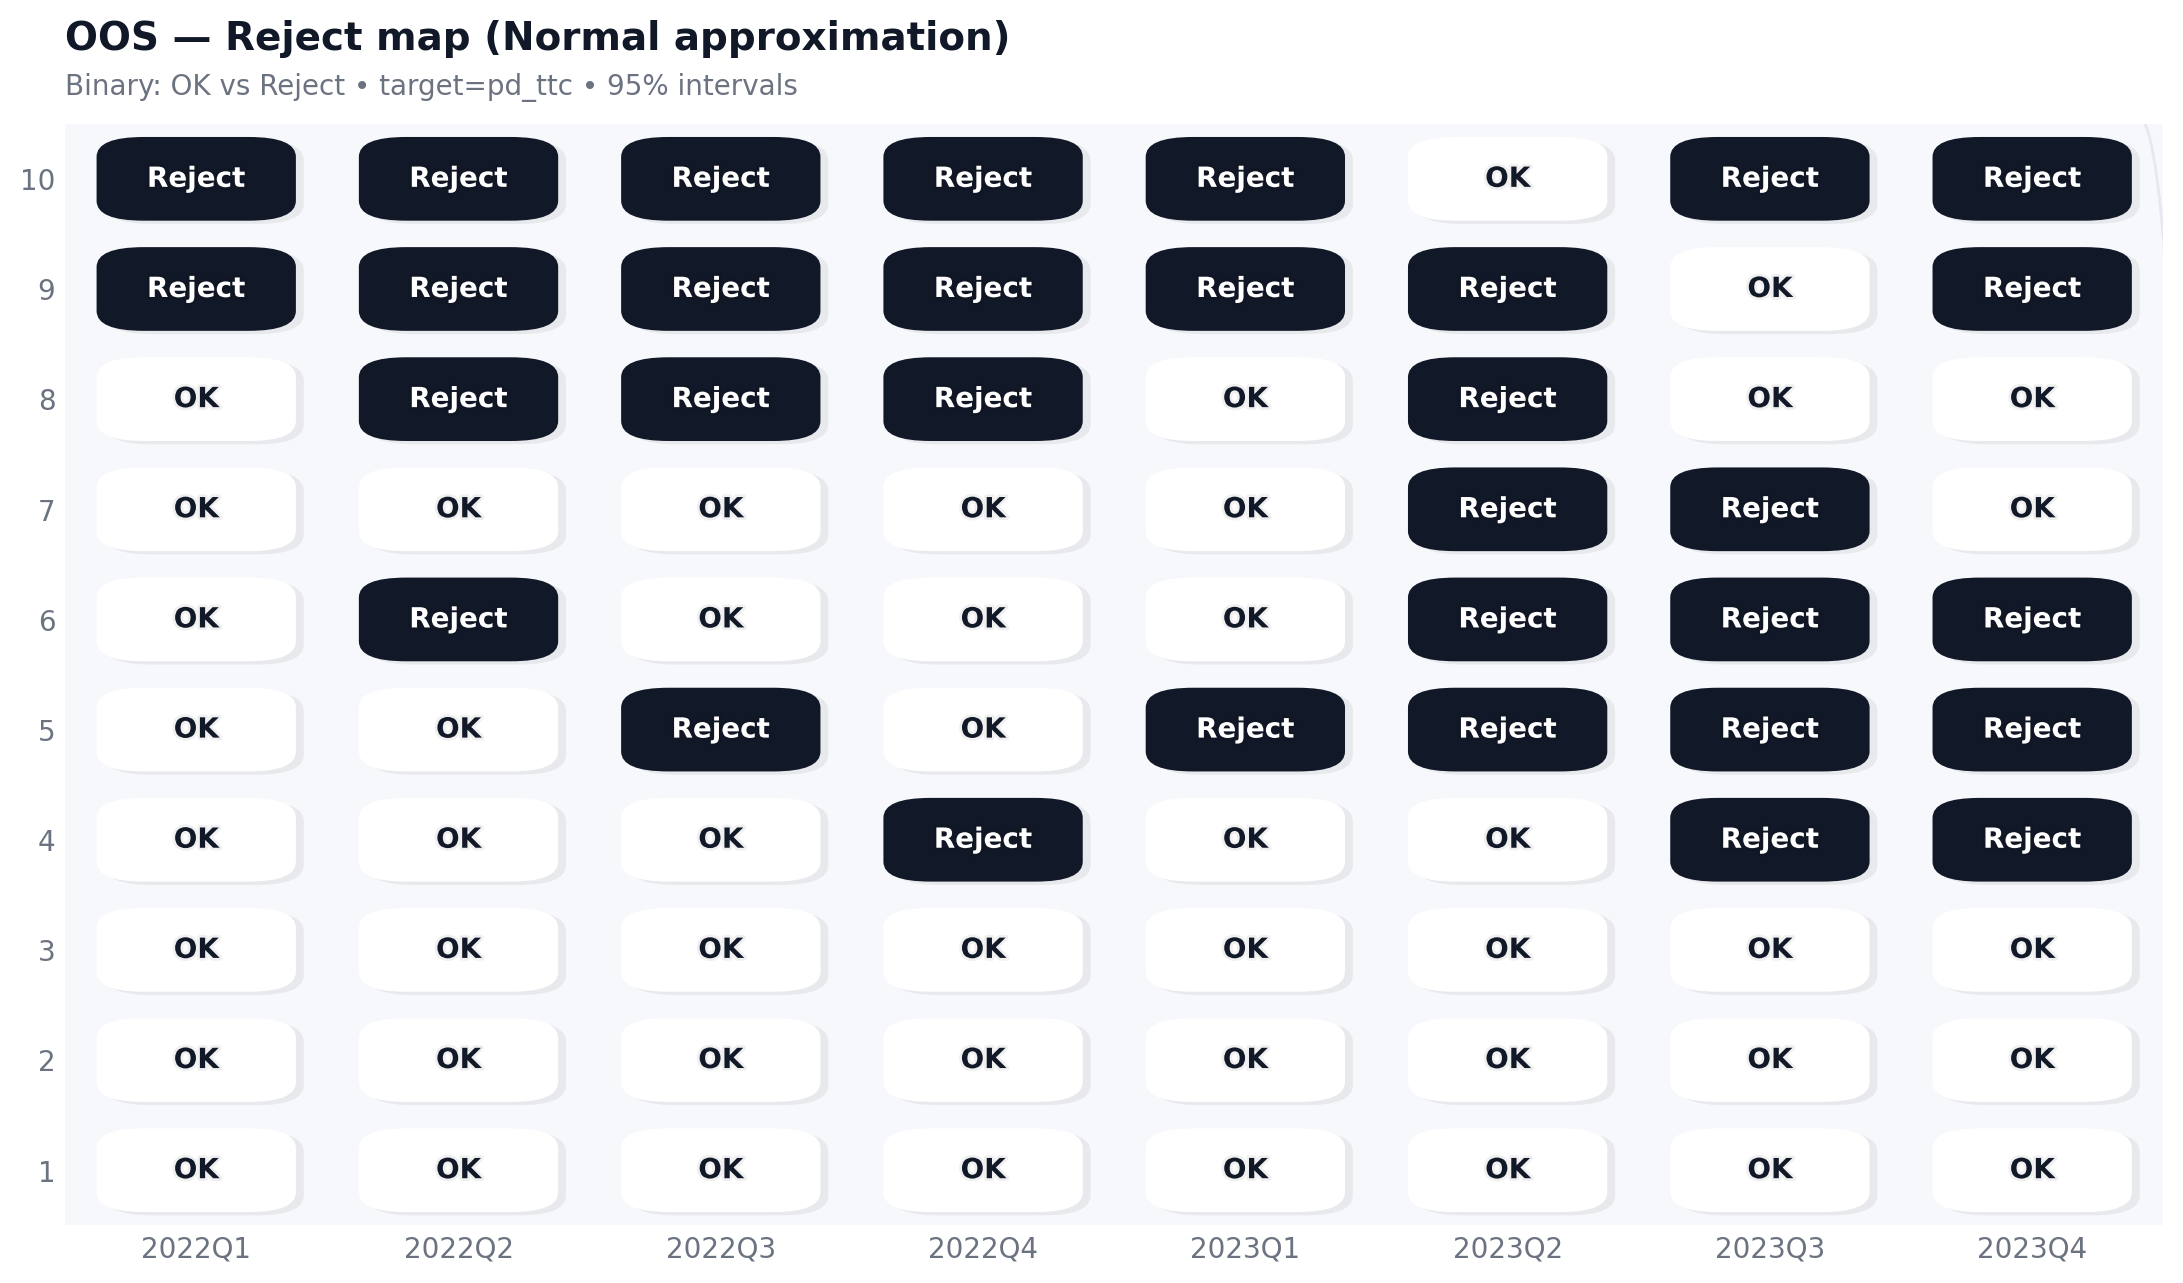


✔ Done. 5 smooth white figures saved in: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures


In [6]:
# ============================================================
# 5 FIGURES — "SMOOTH PRO" (Figma-like) ON WHITE BACKGROUND
# - Rounded tiles + subtle shadow (graphic-software feel)
# - White canvas + light card panel -> perfect for academic articles
# - 8 quarters x 10 grades is ideal (80 tiles)
#
# Outputs (PDF + PNG) in artifacts/paper_figures/:
#   fig1_combined_text_white.*
#   fig2_combined_color_white.*
#   fig3_jeffreys_binary_white.*
#   fig4_cp_binary_white.*
#   fig5_normal_binary_white.*
# ============================================================

from __future__ import annotations

import sys, json
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from matplotlib import patheffects

# -------------------------
# 0) Root detection
# -------------------------
def find_project_root(start: Path | None = None) -> Path:
    start = (start or Path.cwd()).resolve()
    markers = {"pyproject.toml", "Makefile", ".git"}
    for p in [start] + list(start.parents):
        if any((p / m).exists() for m in markers):
            return p
    return start

ROOT = find_project_root()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# -------------------------
# 1) Smooth white theme typography
# -------------------------
mpl.rcParams.update({
    "figure.dpi": 200,
    "savefig.dpi": 360,
    "font.family": "DejaVu Sans",
    "font.size": 10,
    "axes.titlesize": 14,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": False,
    "axes.spines.bottom": False,
})

# -------------------------
# 2) Project intervals
# -------------------------
from experiments.stats.intervals import jeffreys_alpha2, exact_cp, approx_normal

# -------------------------
# 3) CONFIG
# -------------------------
CONF_LEVEL = 0.95

OOS_PATH = ROOT / "data" / "processed" / "scored" / "oos_scored.parquet"
BUCKET_STATS_PATH = ROOT / "artifacts" / "model_from_binned" / "bucket_stats.json"
BUCKET_SECTION = "train"

VINTAGE_COL = "vintage"
GRADE_COL = "grade"
DEFAULT_COL = "default_12m"
PD_LOAN_COL = "pd"

TEST_TARGET = "pd_ttc"      # or "pd_hat"

SHOW_OK_TEXT = True
TEXT_FONTSIZE = 10

OUTDIR = ROOT / "artifacts" / "paper_figures"
OUTDIR.mkdir(parents=True, exist_ok=True)

assert OOS_PATH.exists(), f"OOS file not found: {OOS_PATH}"
assert BUCKET_STATS_PATH.exists(), f"bucket_stats.json not found: {BUCKET_STATS_PATH}"

# -------------------------
# 4) Helpers (data)
# -------------------------
def _safe_int_grade(x) -> int:
    try:
        return int(float(x))
    except Exception:
        return int(x)

def parse_vintage_to_period(s: pd.Series) -> pd.PeriodIndex:
    s_str = s.astype(str).str.strip()
    m = s_str.str.upper().str.replace(" ", "", regex=False).str.match(r"^\d{4}-?Q[1-4]$")
    if m.all():
        cleaned = s_str.str.upper().str.replace(" ", "", regex=False).str.replace("-", "", regex=False)
        return pd.PeriodIndex(cleaned, freq="Q")
    dt = pd.to_datetime(s_str, errors="coerce")
    if float(dt.notna().mean()) < 0.95:
        bad = s_str[dt.isna()].head(10).tolist()
        raise ValueError(f"Cannot parse vintage. Examples: {bad}")
    return dt.dt.to_period("Q")

def load_bucket_pd_map(path: Path, section: str) -> dict[int, float]:
    data = json.loads(path.read_text(encoding="utf-8"))
    if section not in data:
        raise KeyError(f"'{section}' not in bucket_stats.json. Keys: {list(data.keys())}")
    return {int(e["bucket"]): float(e["pd"]) for e in data[section]}

def build_vintage_grade_table(df: pd.DataFrame, pd_ttc_map: dict[int, float]) -> pd.DataFrame:
    cols = [VINTAGE_COL, GRADE_COL, DEFAULT_COL]
    use_pd = PD_LOAN_COL in df.columns
    if use_pd:
        cols.append(PD_LOAN_COL)

    x = df[cols].copy()
    x[GRADE_COL] = x[GRADE_COL].map(_safe_int_grade)

    if use_pd:
        agg = x.groupby([VINTAGE_COL, GRADE_COL], as_index=False).agg(
            n=(DEFAULT_COL, "count"),
            d=(DEFAULT_COL, "sum"),
            pd_hat=(PD_LOAN_COL, "mean"),
        )
    else:
        agg = x.groupby([VINTAGE_COL, GRADE_COL], as_index=False).agg(
            n=(DEFAULT_COL, "count"),
            d=(DEFAULT_COL, "sum"),
        )
        agg["pd_hat"] = np.nan

    agg["pd_obs"] = agg["d"] / agg["n"]
    agg["pd_ttc"] = agg[GRADE_COL].map(pd_ttc_map).astype(float)

    per = parse_vintage_to_period(agg[VINTAGE_COL])
    agg["_per"] = per
    agg = agg.sort_values(["_per", GRADE_COL]).drop(columns=["_per"]).reset_index(drop=True)
    return agg

def compute_rejects(df_vg: pd.DataFrame, test_target: str, conf: float) -> pd.DataFrame:
    out = df_vg.copy()
    out["p0"] = out[test_target].astype(float)

    n_arr = out["n"].to_numpy(int)
    d_arr = out["d"].to_numpy(int)
    p0_arr = out["p0"].to_numpy(float)
    ok = np.isfinite(p0_arr) & (n_arr > 0)

    rej_j = np.full(len(out), np.nan)
    rej_cp = np.full(len(out), np.nan)
    rej_n = np.full(len(out), np.nan)

    for i, (n, d) in enumerate(zip(n_arr, d_arr)):
        if not ok[i]:
            continue

        lb, ub = jeffreys_alpha2(n, d, conf)
        if np.isfinite(lb) and np.isfinite(ub):
            rej_j[i] = float(not (p0_arr[i] >= lb and p0_arr[i] <= ub))

        lb, ub = exact_cp(n, d, conf)
        if np.isfinite(lb) and np.isfinite(ub):
            rej_cp[i] = float(not (p0_arr[i] >= lb and p0_arr[i] <= ub))

        lb, ub = approx_normal(n, d, conf)
        lb = max(0.0, float(lb)); ub = min(1.0, float(ub))
        if np.isfinite(lb) and np.isfinite(ub):
            rej_n[i] = float(not (p0_arr[i] >= lb and p0_arr[i] <= ub))

    out["reject_jeffreys"] = rej_j
    out["reject_cp"] = rej_cp
    out["reject_normal"] = rej_n
    return out

def prep_pivots(df_long: pd.DataFrame):
    tmp = df_long.copy()
    tmp[VINTAGE_COL] = tmp[VINTAGE_COL].astype(str)
    tmp[GRADE_COL] = tmp[GRADE_COL].astype(int)

    per = parse_vintage_to_period(tmp[VINTAGE_COL])
    order = (
        tmp[[VINTAGE_COL]].assign(_per=per).drop_duplicates()
        .sort_values("_per")[VINTAGE_COL].astype(str).tolist()
    )
    tmp[VINTAGE_COL] = pd.Categorical(tmp[VINTAGE_COL], categories=order, ordered=True)

    matJ  = tmp.pivot(index=GRADE_COL, columns=VINTAGE_COL, values="reject_jeffreys").sort_index()
    matCP = tmp.pivot(index=GRADE_COL, columns=VINTAGE_COL, values="reject_cp").sort_index()
    matN  = tmp.pivot(index=GRADE_COL, columns=VINTAGE_COL, values="reject_normal").sort_index()

    A = matJ.to_numpy(float)
    B = matCP.to_numpy(float)
    C = matN.to_numpy(float)
    computable = np.isfinite(A) & np.isfinite(B) & np.isfinite(C)

    return matJ, matCP, matN, A, B, C, computable

def combo_label(j, cp, n, show_ok=True):
    parts = []
    if j:  parts.append("J")
    if cp: parts.append("CP")
    if n:  parts.append("N")
    if len(parts) == 0:
        return "OK" if show_ok else ""
    return "+".join(parts)

# -------------------------
# 5) Smooth white renderer (rounded tiles + subtle shadow)
# -------------------------
THEME = {
    "canvas": "#ffffff",
    "panel":  "#f7f8fb",   # light card background
    "border": "#e6e8ef",
    "muted":  "#6b7280",
    "text":   "#111827",
    "nan":    "#f0f2f7",
}

def _rounded_tile(ax, x, y, w, h, fc, rounding=0.16, shadow=True, ec=None, lw=0.0):
    if shadow:
        sh = FancyBboxPatch(
            (x + 0.03, y - 0.03), w, h,
            boxstyle=f"round,pad=0.01,rounding_size={rounding}",
            linewidth=0.0, facecolor="black", alpha=0.06, zorder=1
        )
        ax.add_patch(sh)

    tile = FancyBboxPatch(
        (x, y), w, h,
        boxstyle=f"round,pad=0.01,rounding_size={rounding}",
        linewidth=lw, edgecolor=ec if ec else "none",
        facecolor=fc, zorder=2
    )
    ax.add_patch(tile)

def draw_panel(ax, nrows, ncols, xlabels, ylabels, title, subtitle=None):
    ax.set_facecolor(THEME["panel"])
    ax.figure.set_facecolor(THEME["canvas"])

    ax.set_xlim(0, ncols)
    ax.set_ylim(0, nrows)

    ax.set_xticks(np.arange(ncols) + 0.5)
    ax.set_yticks(np.arange(nrows) + 0.5)
    ax.set_xticklabels(xlabels, color=THEME["muted"])
    ax.set_yticklabels(ylabels, color=THEME["muted"])
    ax.tick_params(length=0)

    for sp in ax.spines.values():
        sp.set_visible(False)

    # Title + subtitle
    ax.text(0.0, 1.06, title, transform=ax.transAxes,
            ha="left", va="bottom", fontsize=14, fontweight=700, color=THEME["text"])
    if subtitle:
        ax.text(0.0, 1.02, subtitle, transform=ax.transAxes,
                ha="left", va="bottom", fontsize=10, color=THEME["muted"])

    # Rounded panel outline
    outer = FancyBboxPatch(
        (-0.08, -0.08), ncols + 0.16, nrows + 0.16,
        boxstyle="round,pad=0.00,rounding_size=0.18",
        linewidth=1.0, edgecolor=THEME["border"],
        facecolor="none", zorder=0
    )
    ax.add_patch(outer)

def render_rounded_matrix(ax, Z, palette_fn, label_fn=None, label_color_fn=None, cell_pad=0.12, rounding=0.18):
    nrows, ncols = Z.shape
    for r in range(nrows):
        for c in range(ncols):
            v = Z[r, c]
            fc = THEME["nan"] if not np.isfinite(v) else palette_fn(v)
            x = c + cell_pad
            y = r + cell_pad
            w = 1 - 2 * cell_pad
            h = 1 - 2 * cell_pad

            _rounded_tile(ax, x, y, w, h, fc, rounding=rounding, shadow=True)

            if label_fn is not None:
                t = label_fn(r, c, v)
                if t:
                    col = label_color_fn(r, c, v, fc) if label_color_fn else THEME["text"]
                    ax.text(
                        c + 0.5, r + 0.5, t,
                        ha="center", va="center",
                        fontsize=TEXT_FONTSIZE, fontweight=700, color=col, zorder=3,
                        path_effects=[patheffects.withStroke(linewidth=2, foreground="black", alpha=0.06)]
                    )

def save_fig(fig, stem):
    pdf = OUTDIR / f"{stem}.pdf"
    png = OUTDIR / f"{stem}.png"
    fig.savefig(pdf, bbox_inches="tight")
    fig.savefig(png, bbox_inches="tight")
    print("Saved:", pdf)
    print("Saved:", png)

# -------------------------
# 6) Load + compute matrices
# -------------------------
df_oos = pd.read_parquet(OOS_PATH)
pd_ttc_map = load_bucket_pd_map(BUCKET_STATS_PATH, BUCKET_SECTION)

df_vg = build_vintage_grade_table(df_oos, pd_ttc_map=pd_ttc_map)

test_target = TEST_TARGET
if test_target not in df_vg.columns or df_vg[test_target].isna().all():
    test_target = "pd_ttc"
    print("[WARN] TEST_TARGET unavailable, fallback to pd_ttc")

df_long = compute_rejects(df_vg, test_target=test_target, conf=CONF_LEVEL)
matJ, matCP, matN, A, B, C, computable = prep_pivots(df_long)

xlabels = matJ.columns.astype(str).tolist()
ylabels = matJ.index.tolist()
nrows, ncols = A.shape

# labels for combined
labels = np.empty(A.shape, dtype=object)
labels[:] = ""
for r in range(nrows):
    for c in range(ncols):
        if computable[r, c]:
            labels[r, c] = combo_label(int(A[r, c]), int(B[r, c]), int(C[r, c]), show_ok=SHOW_OK_TEXT)

# combined code (0..7)
CODE = np.full(A.shape, np.nan)
for r in range(nrows):
    for c in range(ncols):
        if computable[r, c]:
            j, cp, n = int(A[r, c]), int(B[r, c]), int(C[r, c])
            CODE[r, c] = (1*j + 2*cp + 4*n)

# -------------------------
# 7) Color palettes (white-background friendly)
# -------------------------
# Soft-but-clear colors (not neon; keeps "smooth" feel)
PATTERN = {
    0: "#ffffff",  # OK
    1: "#dbeafe",  # J   (light blue)
    2: "#ffedd5",  # CP  (light orange)
    3: "#dcfce7",  # J+CP (light green)
    4: "#fee2e2",  # N   (light red)
    5: "#f3e8ff",  # J+N (light purple)
    6: "#e2e8f0",  # CP+N (light slate)
    7: "#111827",  # all (dark)
}

def palette_combined(v):
    return PATTERN.get(int(v), "#ffffff")

def label_color_combined(r, c, v, fc):
    if not np.isfinite(v):
        return THEME["muted"]
    return "#ffffff" if int(v) == 7 else THEME["text"]

# Binary palette
BIN = {0: "#ffffff", 1: "#111827"}
def palette_binary(v):
    if not np.isfinite(v):
        return THEME["nan"]
    return BIN[int(v)]

def label_color_binary(r, c, v, fc):
    if not np.isfinite(v):
        return THEME["muted"]
    return "#ffffff" if int(v) == 1 else THEME["text"]

# -------------------------
# 8) FIGURE 1 — Combined TEXT (white, smooth)
# Use neutral tiles but keep strong typography
# -------------------------
fig, ax = plt.subplots(figsize=(10.8, 6.3))
draw_panel(
    ax, nrows, ncols, xlabels, ylabels,
    title="OOS — Rejection pattern across methods",
    subtitle=f"Cells show OK / J / CP / N combinations • target={test_target} • {int(CONF_LEVEL*100)}% intervals"
)

# neutral palette for tiles: OK stays white; reject gets slightly tinted by pattern (still smooth)
render_rounded_matrix(
    ax, CODE,
    palette_fn=palette_combined,
    label_fn=lambda r, c, v: labels[r, c] if labels[r, c] else "",
    label_color_fn=label_color_combined,
    cell_pad=0.13, rounding=0.18
)

ax.text(1.0, 1.055, "J=Jeffreys  CP=Clopper–Pearson  N=Normal",
        transform=ax.transAxes, ha="right", va="bottom",
        color=THEME["muted"], fontsize=9)

save_fig(fig, "fig1_combined_text_white")
plt.show()

# -------------------------
# 9) FIGURE 2 — Combined COLOR (white, smooth, still readable)
# -------------------------
fig, ax = plt.subplots(figsize=(10.8, 6.3))
draw_panel(
    ax, nrows, ncols, xlabels, ylabels,
    title="OOS — Combined rejects (color)",
    subtitle="Pastel pattern map with text overlay (unambiguous)"
)

render_rounded_matrix(
    ax, CODE,
    palette_fn=palette_combined,
    label_fn=lambda r, c, v: labels[r, c] if labels[r, c] else "",
    label_color_fn=label_color_combined,
    cell_pad=0.13, rounding=0.18
)

save_fig(fig, "fig2_combined_color_white")
plt.show()

# -------------------------
# 10) FIGURE 3–5 — Binary per method (white, smooth)
# -------------------------
def plot_binary_rounded(Z, method_name, stem):
    fig, ax = plt.subplots(figsize=(10.8, 6.3))
    draw_panel(
        ax, nrows, ncols, xlabels, ylabels,
        title=f"OOS — Reject map ({method_name})",
        subtitle=f"Binary: OK vs Reject • target={test_target} • {int(CONF_LEVEL*100)}% intervals"
    )
    render_rounded_matrix(
        ax, Z,
        palette_fn=palette_binary,
        label_fn=lambda r, c, v: ("Reject" if np.isfinite(v) and int(v) == 1 else "OK") if np.isfinite(v) else "",
        label_color_fn=label_color_binary,
        cell_pad=0.13, rounding=0.18
    )
    save_fig(fig, stem)
    plt.show()

plot_binary_rounded(A, "Jeffreys", "fig3_jeffreys_binary_white")
plot_binary_rounded(B, "Clopper–Pearson", "fig4_cp_binary_white")
plot_binary_rounded(C, "Normal approximation", "fig5_normal_binary_white")

print("\n✔ Done. 5 smooth white figures saved in:", OUTDIR)


Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig1_combined_text_white_pictos.pdf
Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig1_combined_text_white_pictos.png


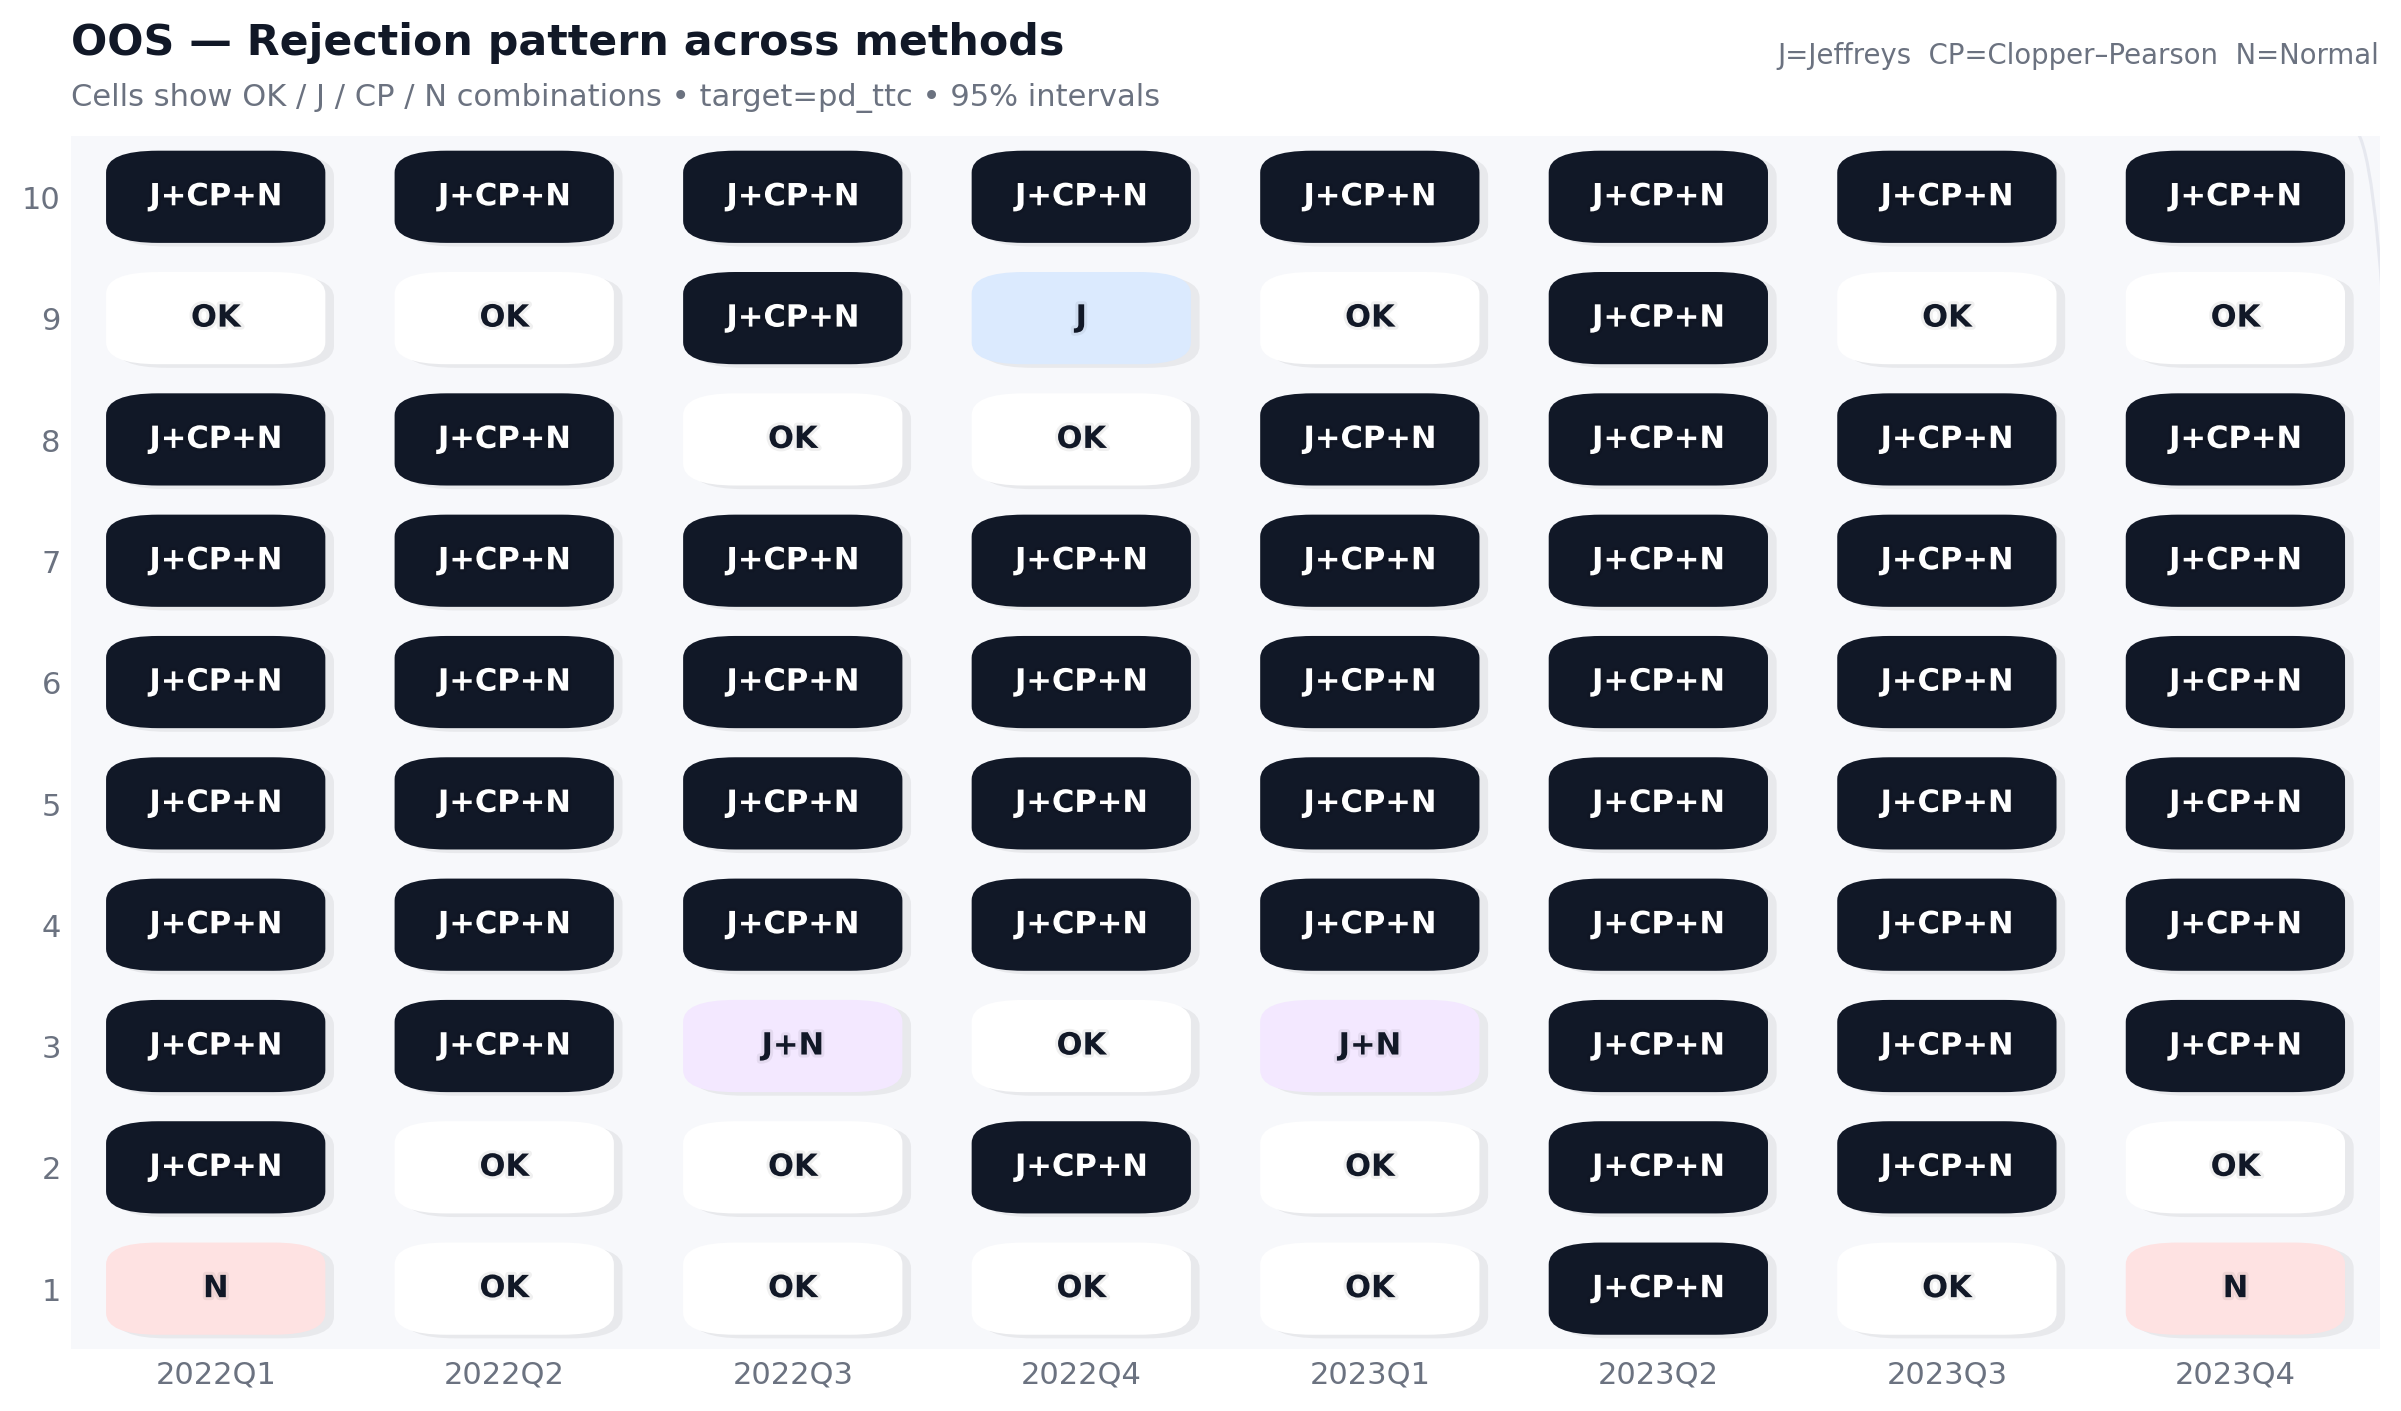

Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig2_combined_color_white_pictos.pdf
Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig2_combined_color_white_pictos.png


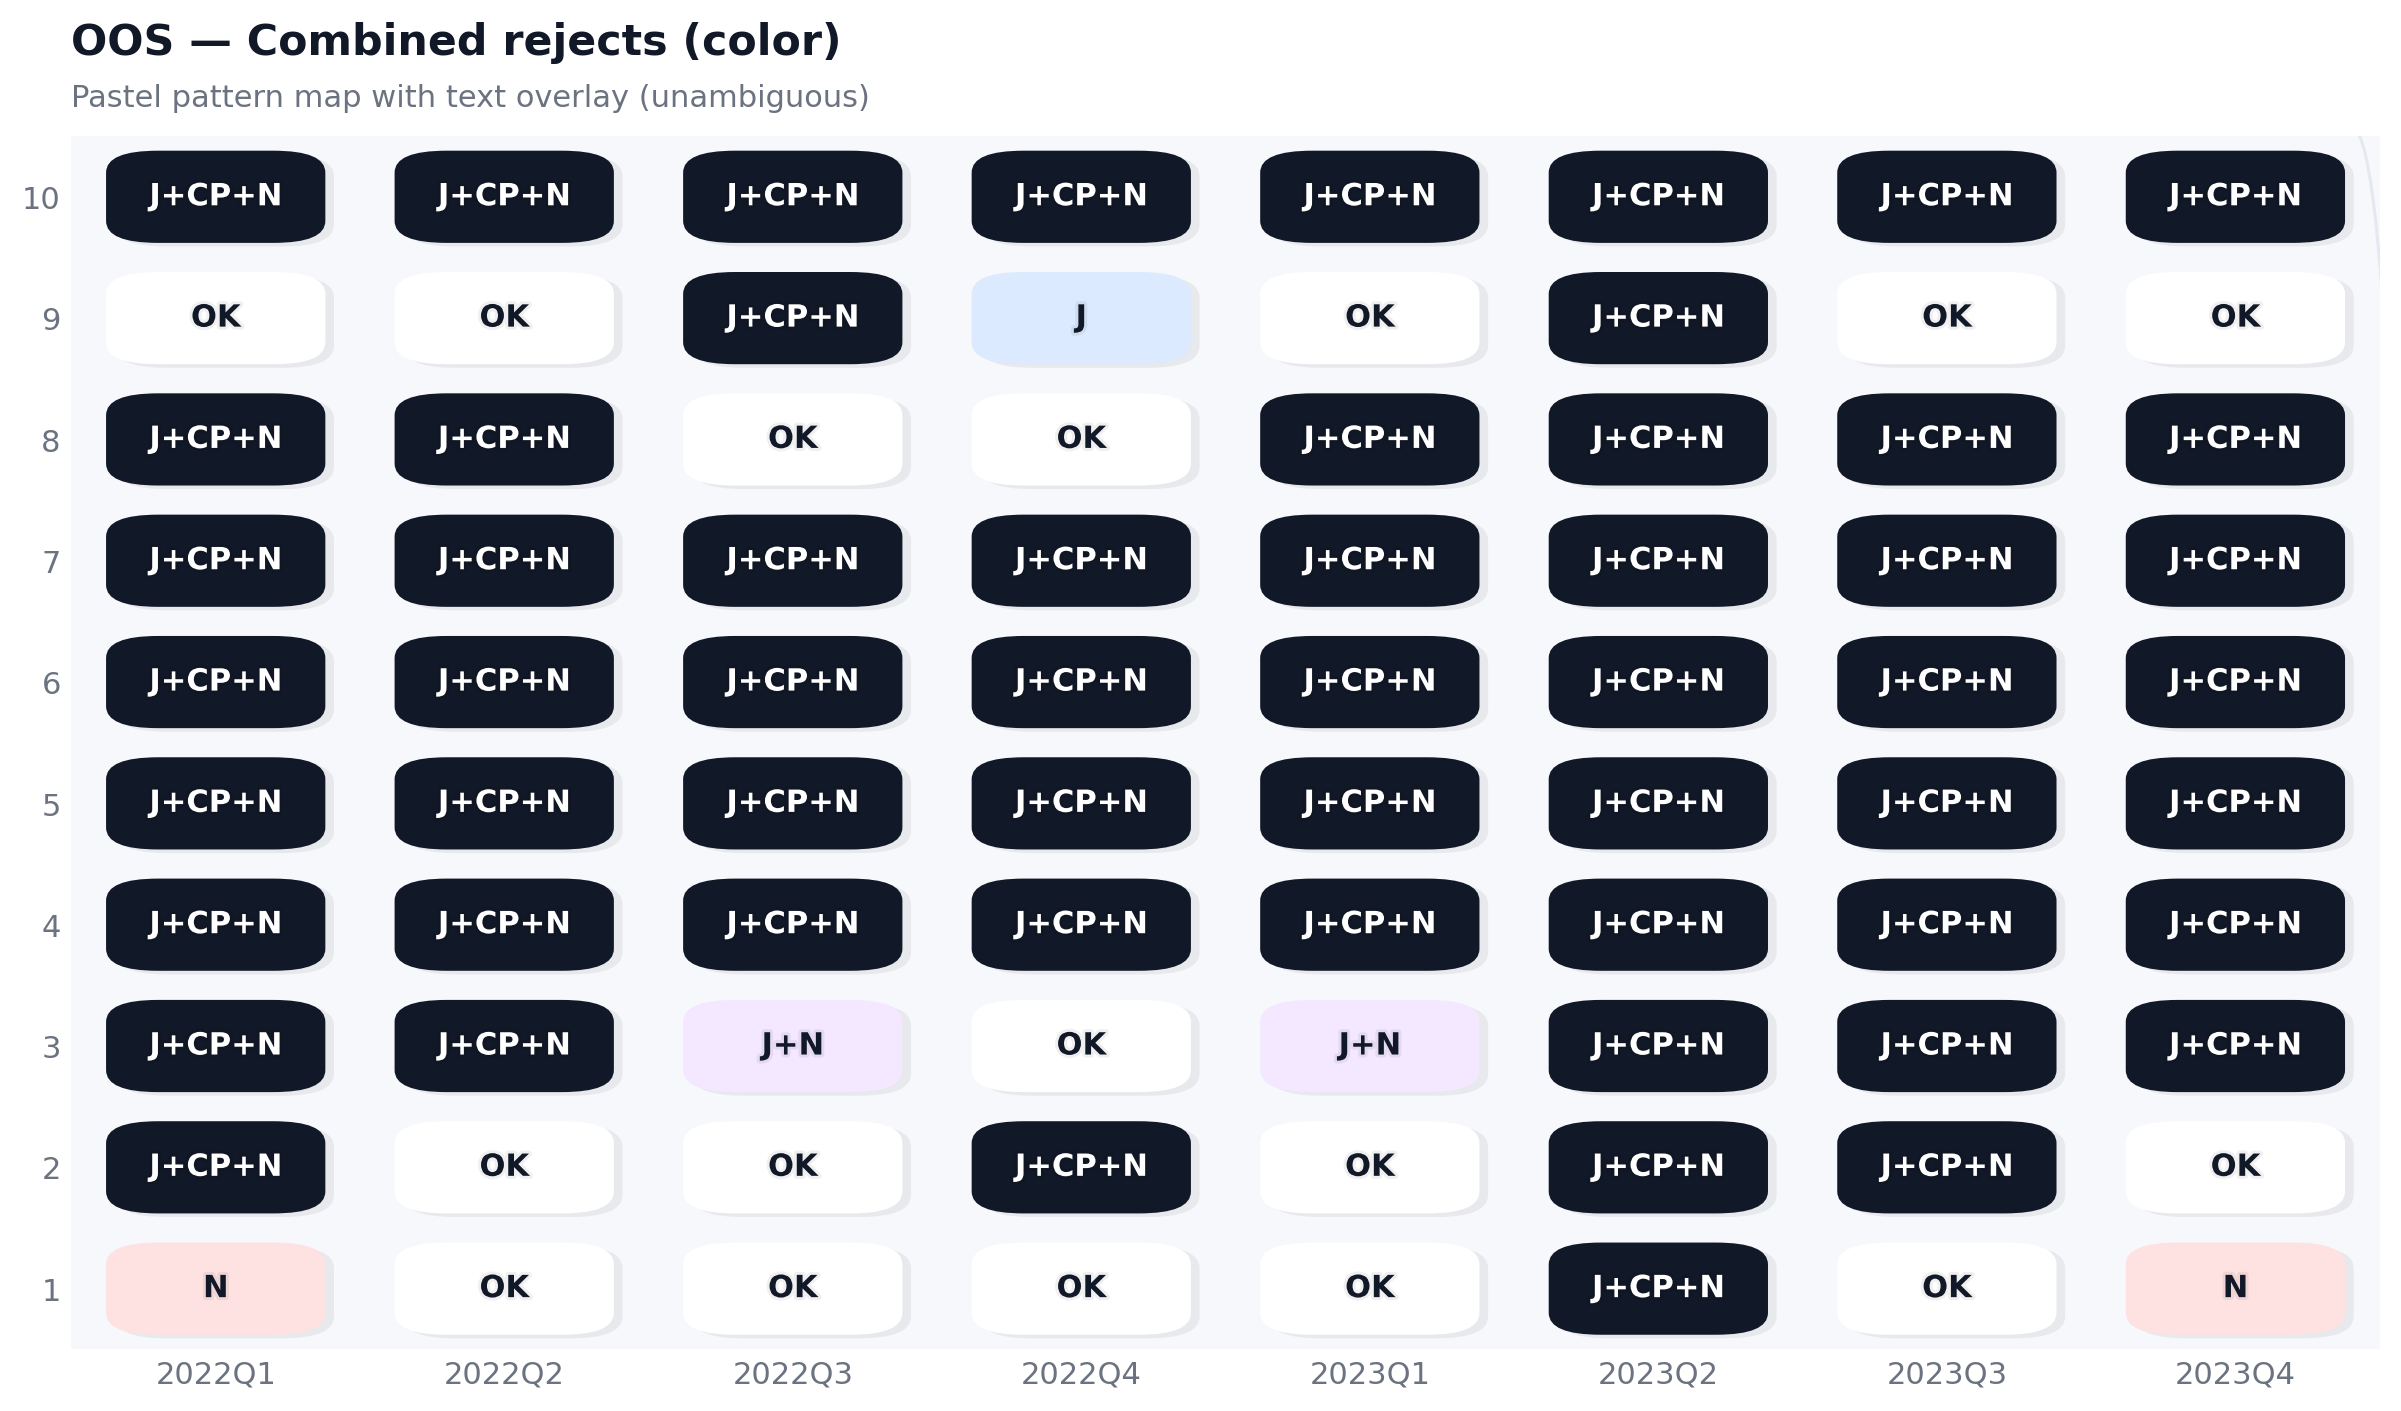

Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig3_jeffreys_binary_white_pictos.pdf
Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig3_jeffreys_binary_white_pictos.png


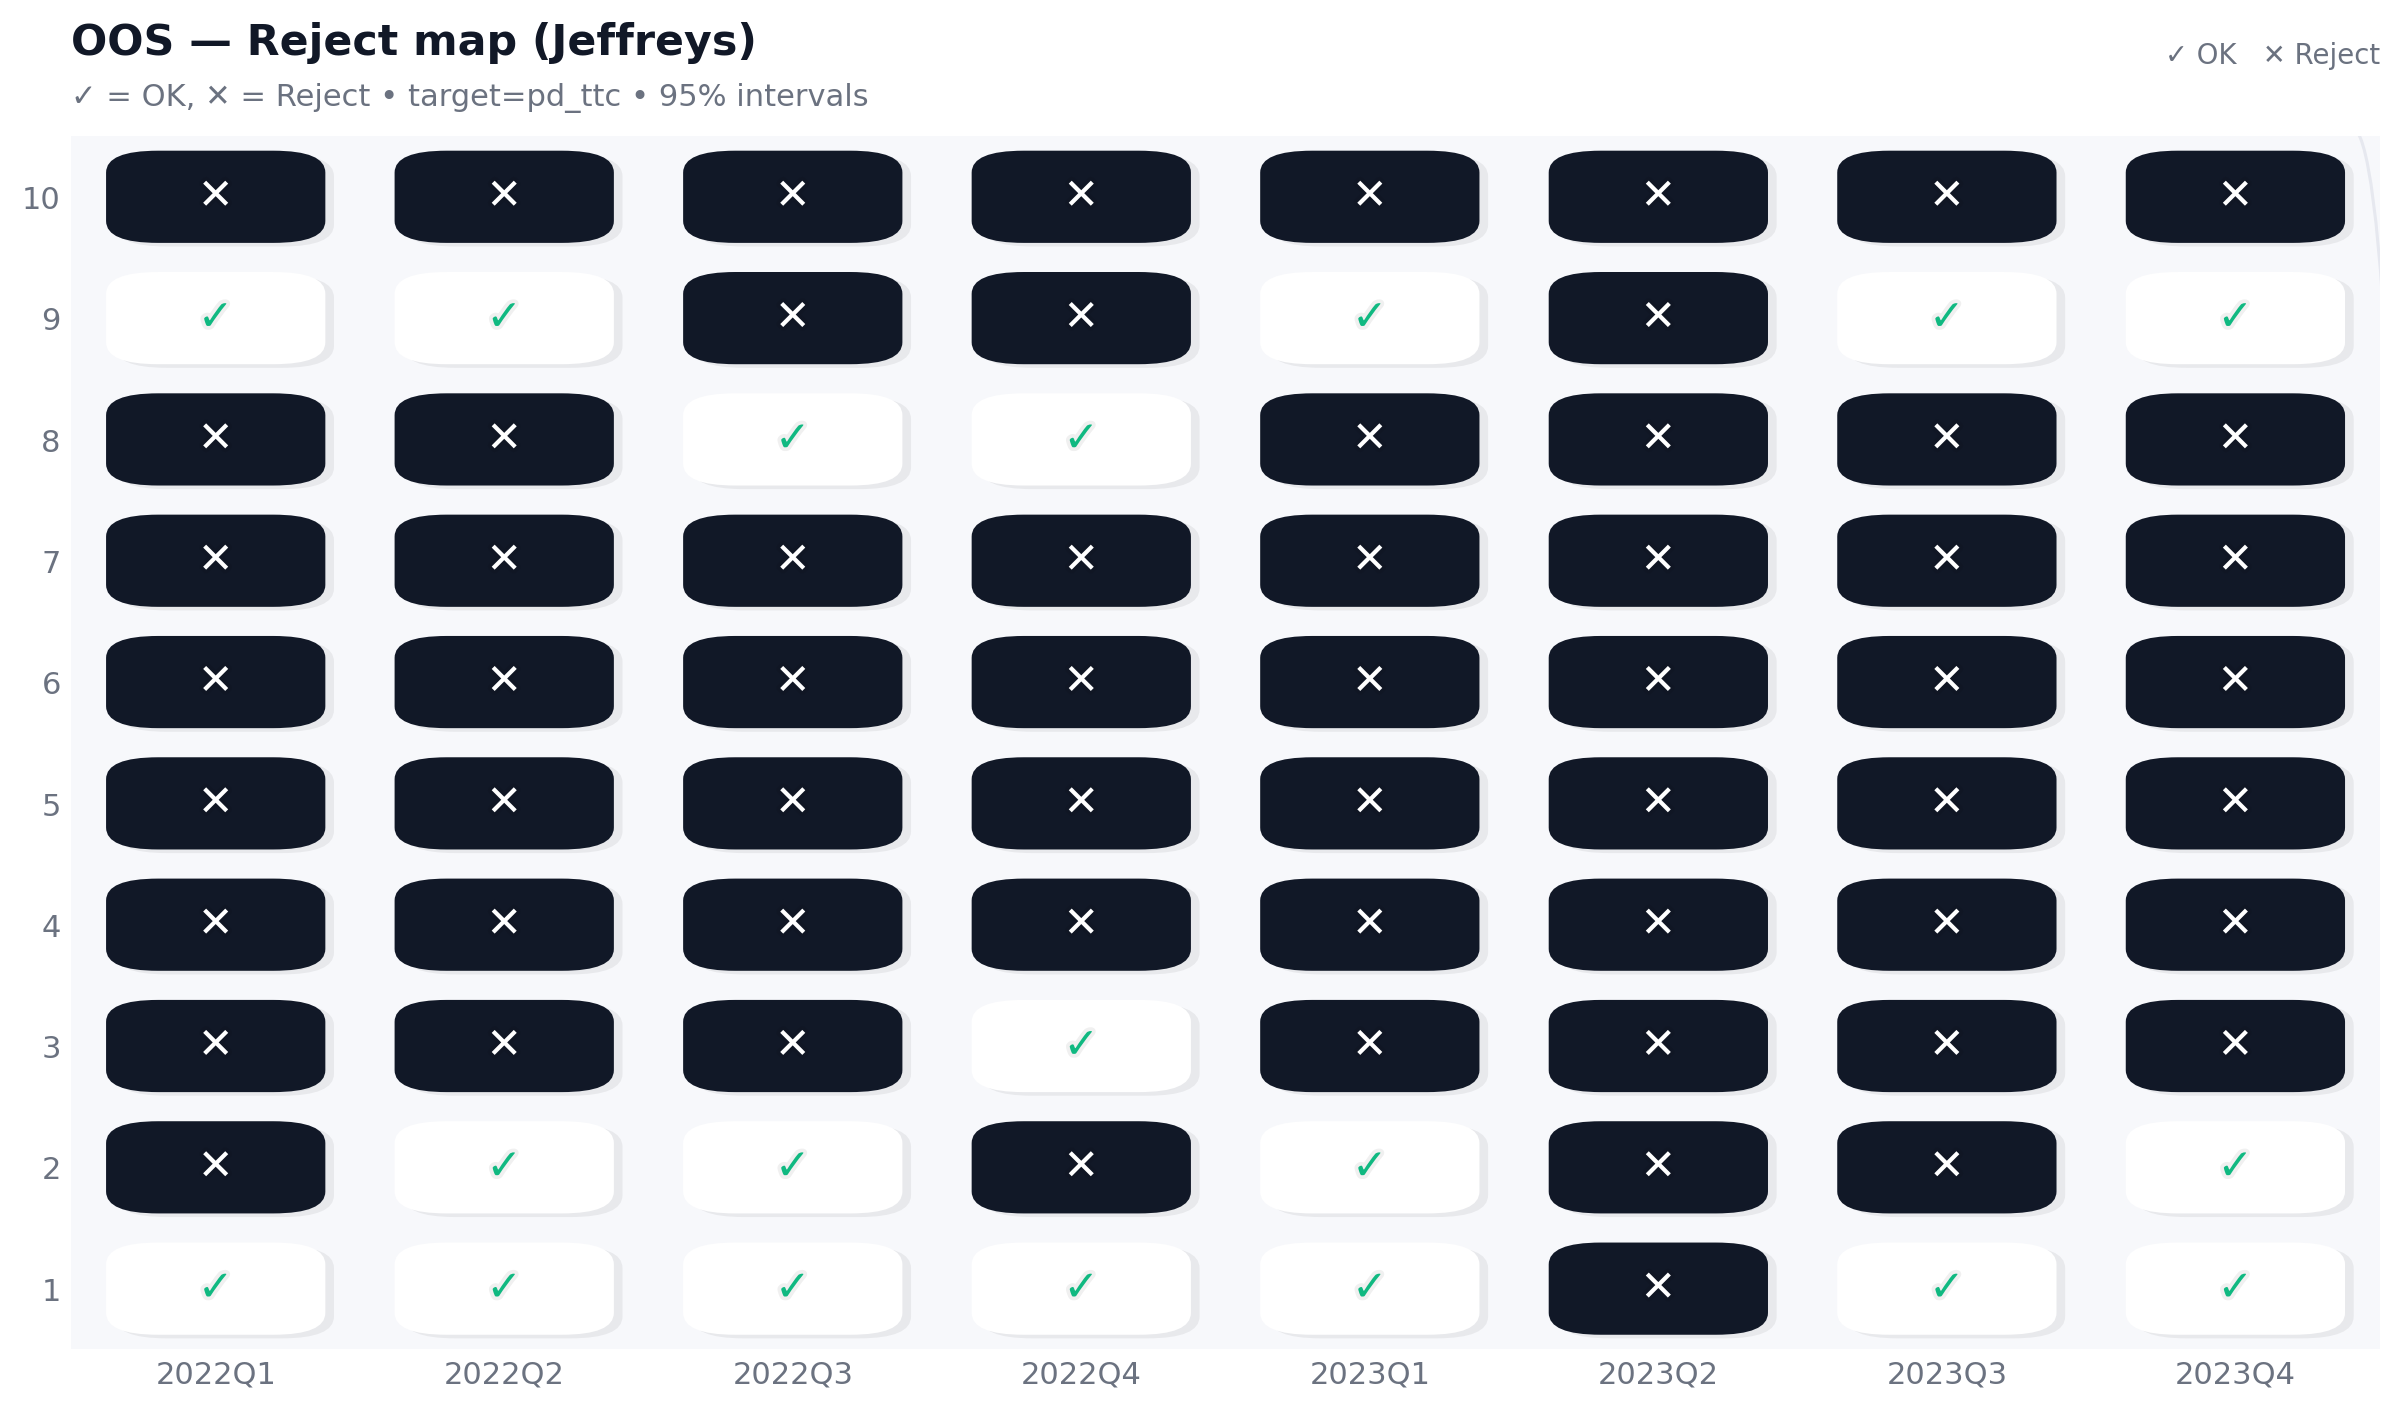

Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig4_cp_binary_white_pictos.pdf
Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig4_cp_binary_white_pictos.png


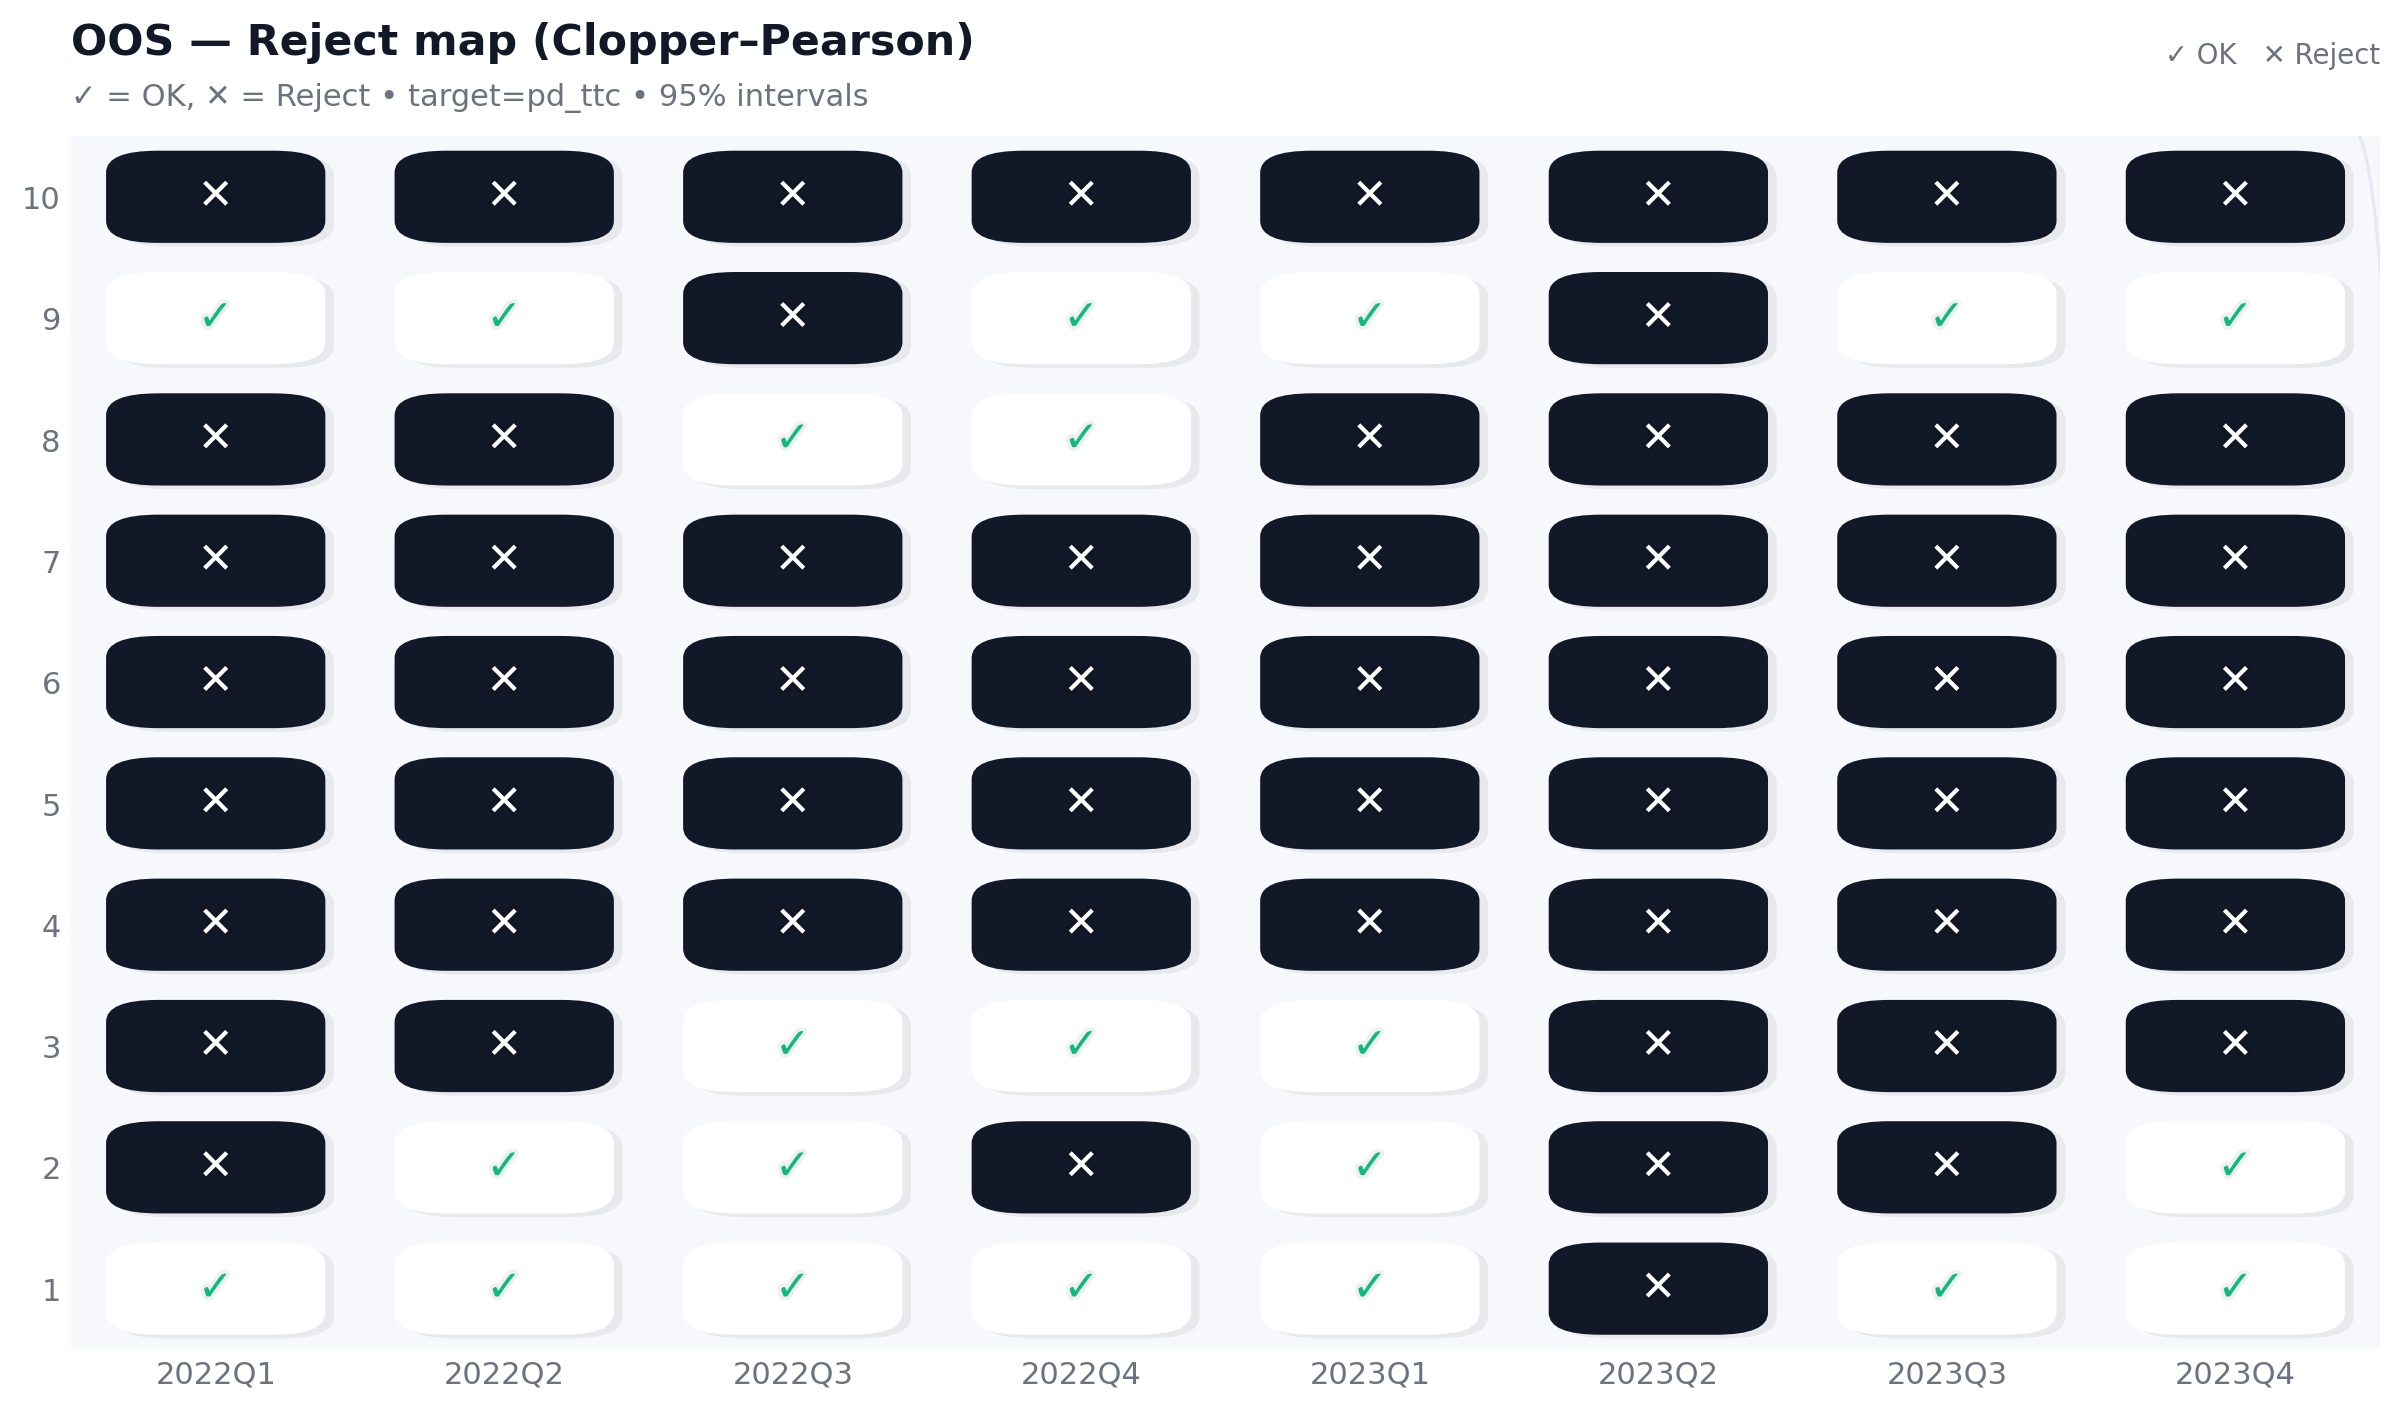

Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig5_normal_binary_white_pictos.pdf
Saved: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures/fig5_normal_binary_white_pictos.png


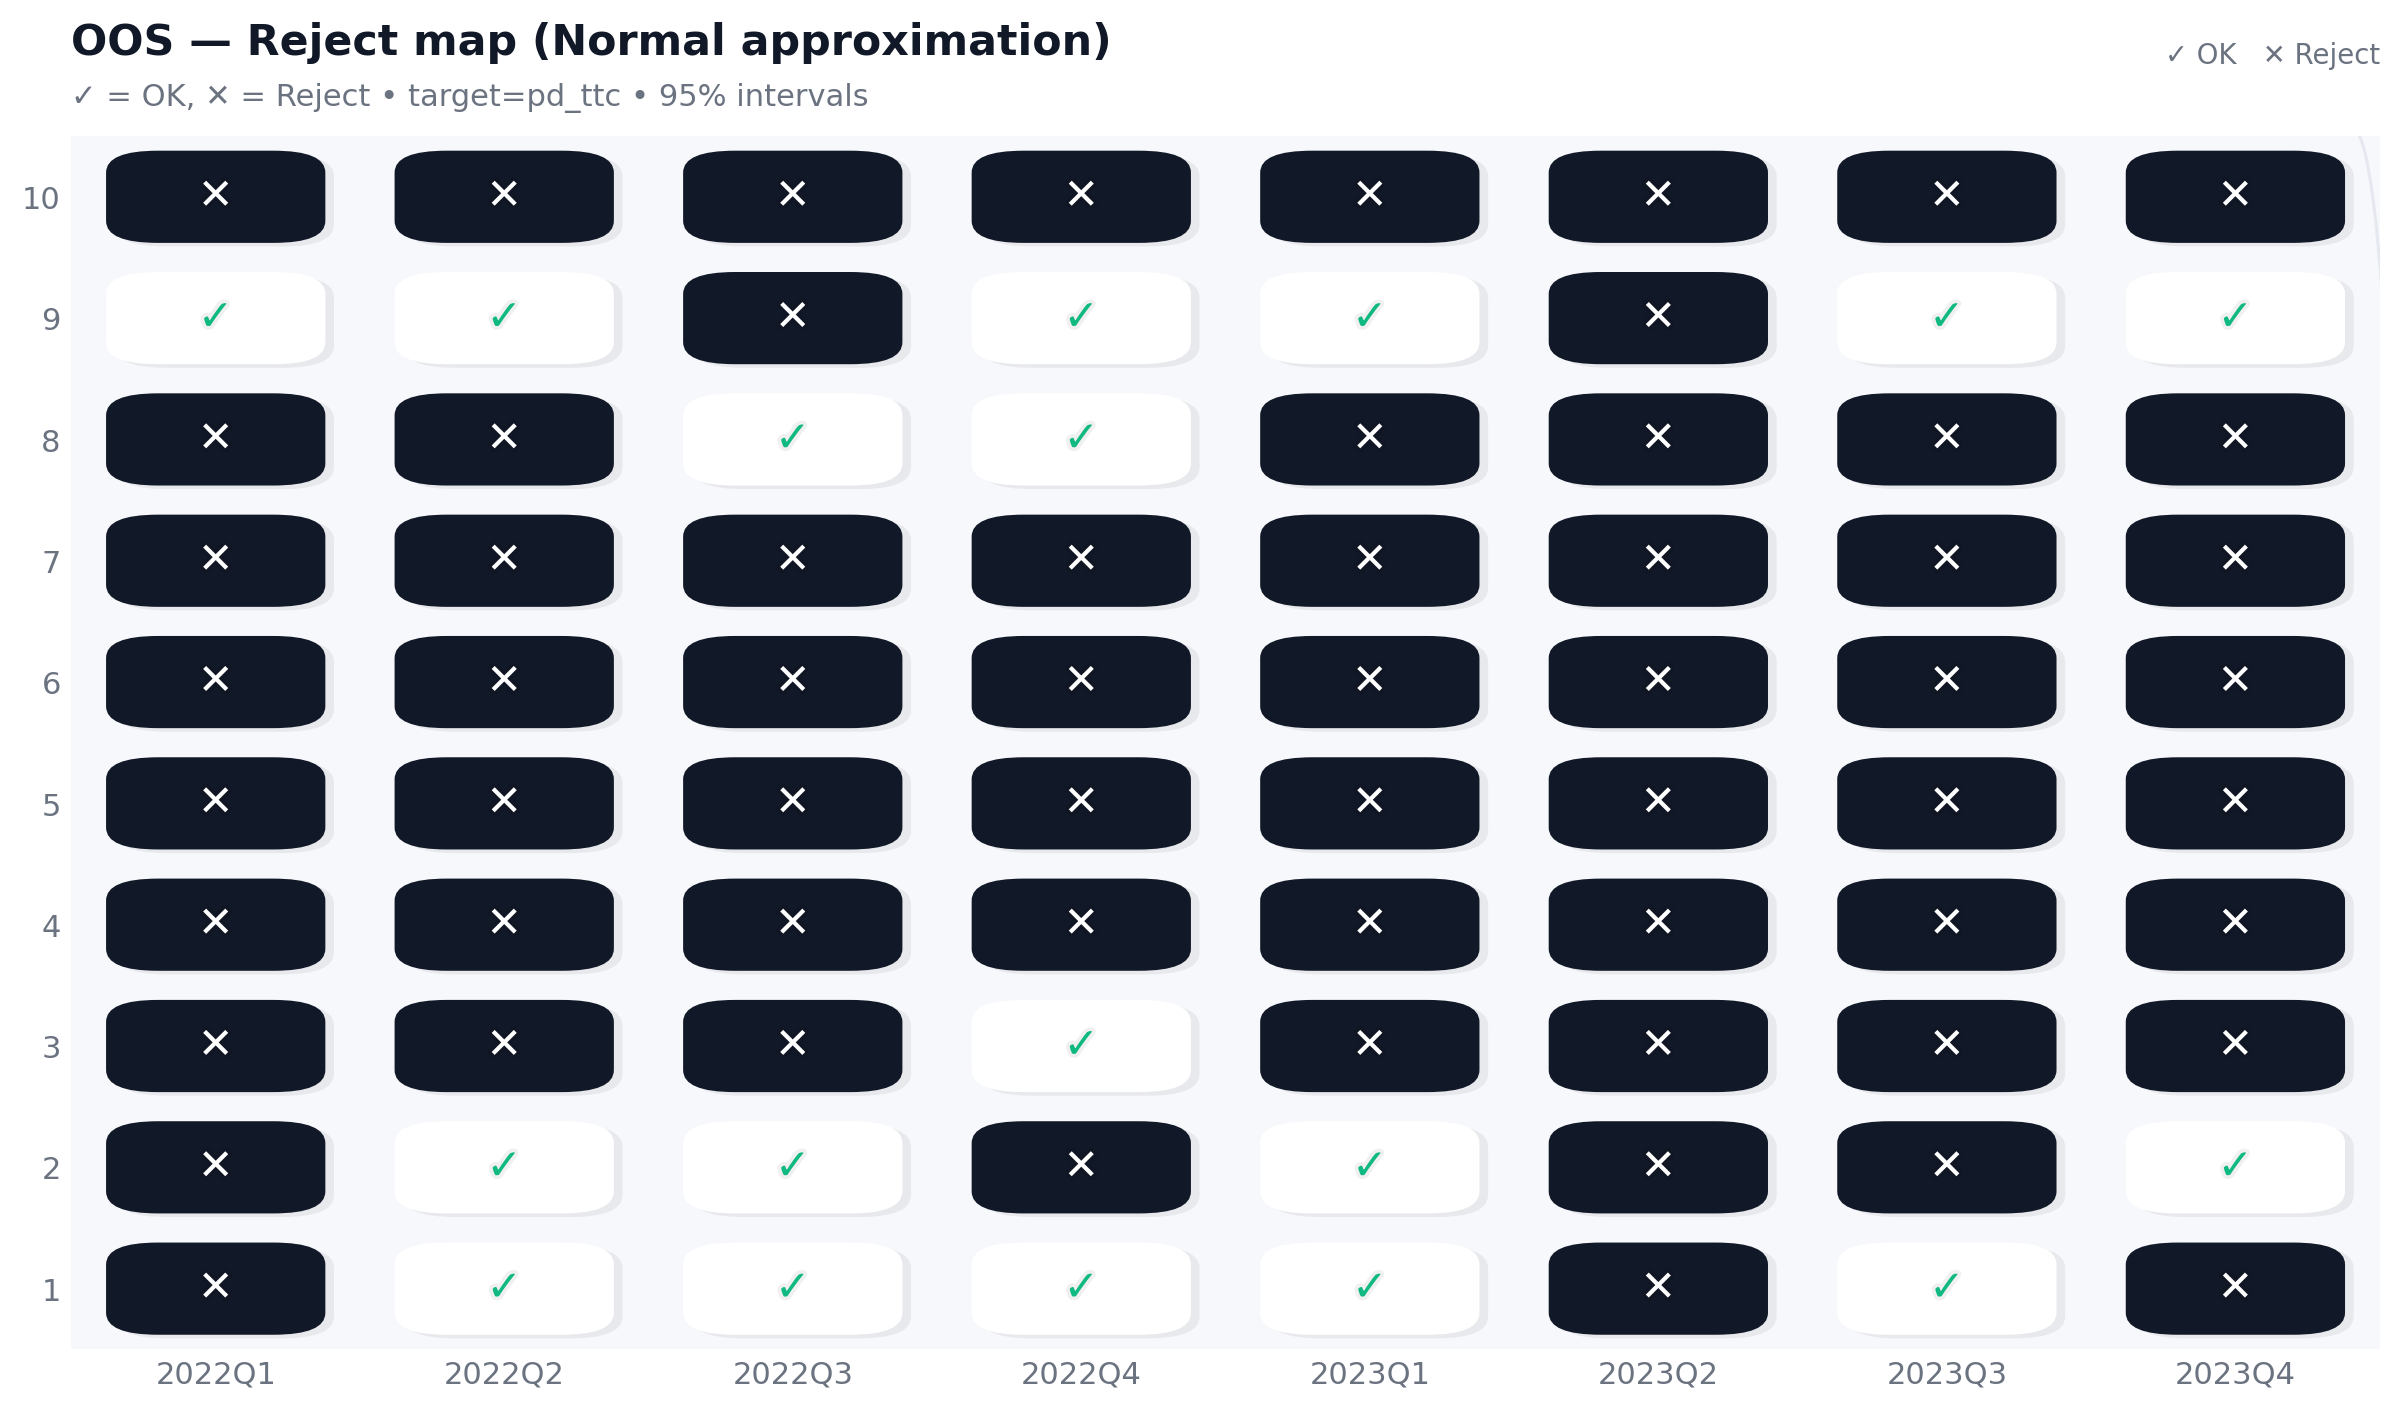


✔ Done. 5 smooth white figures with pictos saved in: /Users/yoannpull/Desktop/Bureau/1_Thesis/03_Codes/01_Jeffreys/pd_calibration/artifacts/paper_figures


In [11]:
# ============================================================
# 5 FIGURES — SMOOTH PRO (WHITE) + PICTOS (✓ / ✕) + ROUNDED TILES
# - Perfect for articles: white canvas, subtle cards, export PDF+PNG
# - Combined figures show OK / J / CP / N combos (text)
# - Binary figures use pictos only: ✓ (OK) and ✕ (Reject)
# ============================================================

from __future__ import annotations

import sys, json
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from matplotlib import patheffects

# -------------------------
# 0) Root detection
# -------------------------
def find_project_root(start: Path | None = None) -> Path:
    start = (start or Path.cwd()).resolve()
    markers = {"pyproject.toml", "Makefile", ".git"}
    for p in [start] + list(start.parents):
        if any((p / m).exists() for m in markers):
            return p
    return start

ROOT = find_project_root()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# -------------------------
# 1) Smooth white typography
# -------------------------
mpl.rcParams.update({
    "figure.dpi": 220,
    "savefig.dpi": 420,
    "font.family": "DejaVu Sans",
    "font.size": 10,
    "axes.titlesize": 14,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": False,
    "axes.spines.bottom": False,
})

# -------------------------
# 2) Project intervals
# -------------------------
from experiments.stats.intervals import jeffreys_alpha2, exact_cp, approx_normal

# -------------------------
# 3) CONFIG
# -------------------------
CONF_LEVEL = 0.95

OOS_PATH = ROOT / "data" / "processed" / "scored" / "oos_scored.parquet"
BUCKET_STATS_PATH = ROOT / "artifacts" / "model_from_binned" / "bucket_stats.json"
BUCKET_SECTION = "train"

VINTAGE_COL = "vintage"
GRADE_COL = "grade"
DEFAULT_COL = "default_12m"
PD_LOAN_COL = "pd"

TEST_TARGET = "pd_ttc"      # or "pd_hat"

SHOW_OK_TEXT = True         # for combined plots
TEXT_FONTSIZE = 10
PIC_FONTSIZE = 14           # pictos (✓ / ✕)

OUTDIR = ROOT / "artifacts" / "paper_figures"
OUTDIR.mkdir(parents=True, exist_ok=True)

assert OOS_PATH.exists(), f"OOS file not found: {OOS_PATH}"
assert BUCKET_STATS_PATH.exists(), f"bucket_stats.json not found: {BUCKET_STATS_PATH}"

# -------------------------
# 4) Helpers (data)
# -------------------------
def _safe_int_grade(x) -> int:
    try:
        return int(float(x))
    except Exception:
        return int(x)

def parse_vintage_to_period(s: pd.Series) -> pd.PeriodIndex:
    s_str = s.astype(str).str.strip()
    m = s_str.str.upper().str.replace(" ", "", regex=False).str.match(r"^\d{4}-?Q[1-4]$")
    if m.all():
        cleaned = s_str.str.upper().str.replace(" ", "", regex=False).str.replace("-", "", regex=False)
        return pd.PeriodIndex(cleaned, freq="Q")
    dt = pd.to_datetime(s_str, errors="coerce")
    if float(dt.notna().mean()) < 0.95:
        bad = s_str[dt.isna()].head(10).tolist()
        raise ValueError(f"Cannot parse vintage. Examples: {bad}")
    return dt.dt.to_period("Q")

def load_bucket_pd_map(path: Path, section: str) -> dict[int, float]:
    data = json.loads(path.read_text(encoding="utf-8"))
    if section not in data:
        raise KeyError(f"'{section}' not in bucket_stats.json. Keys: {list(data.keys())}")
    return {int(e["bucket"]): float(e["pd"]) for e in data[section]}

def build_vintage_grade_table(df: pd.DataFrame, pd_ttc_map: dict[int, float]) -> pd.DataFrame:
    cols = [VINTAGE_COL, GRADE_COL, DEFAULT_COL]
    use_pd = PD_LOAN_COL in df.columns
    if use_pd:
        cols.append(PD_LOAN_COL)

    x = df[cols].copy()
    x[GRADE_COL] = x[GRADE_COL].map(_safe_int_grade)

    if use_pd:
        agg = x.groupby([VINTAGE_COL, GRADE_COL], as_index=False).agg(
            n=(DEFAULT_COL, "count"),
            d=(DEFAULT_COL, "sum"),
            pd_hat=(PD_LOAN_COL, "mean"),
        )
    else:
        agg = x.groupby([VINTAGE_COL, GRADE_COL], as_index=False).agg(
            n=(DEFAULT_COL, "count"),
            d=(DEFAULT_COL, "sum"),
        )
        agg["pd_hat"] = np.nan

    agg["pd_obs"] = agg["d"] / agg["n"]
    agg["pd_ttc"] = agg[GRADE_COL].map(pd_ttc_map).astype(float)

    per = parse_vintage_to_period(agg[VINTAGE_COL])
    agg["_per"] = per
    agg = agg.sort_values(["_per", GRADE_COL]).drop(columns=["_per"]).reset_index(drop=True)
    return agg

def compute_rejects(df_vg: pd.DataFrame, test_target: str, conf: float) -> pd.DataFrame:
    out = df_vg.copy()
    out["p0"] = out[test_target].astype(float)

    n_arr = out["n"].to_numpy(int)
    d_arr = out["d"].to_numpy(int)
    p0_arr = out["p0"].to_numpy(float)
    ok = np.isfinite(p0_arr) & (n_arr > 0)

    rej_j = np.full(len(out), np.nan)
    rej_cp = np.full(len(out), np.nan)
    rej_n = np.full(len(out), np.nan)

    for i, (n, d) in enumerate(zip(n_arr, d_arr)):
        if not ok[i]:
            continue

        lb, ub = jeffreys_alpha2(n, d, conf)
        if np.isfinite(lb) and np.isfinite(ub):
            rej_j[i] = float(not (p0_arr[i] >= lb and p0_arr[i] <= ub))

        lb, ub = exact_cp(n, d, conf)
        if np.isfinite(lb) and np.isfinite(ub):
            rej_cp[i] = float(not (p0_arr[i] >= lb and p0_arr[i] <= ub))

        lb, ub = approx_normal(n, d, conf)
        lb = max(0.0, float(lb)); ub = min(1.0, float(ub))
        if np.isfinite(lb) and np.isfinite(ub):
            rej_n[i] = float(not (p0_arr[i] >= lb and p0_arr[i] <= ub))

    out["reject_jeffreys"] = rej_j
    out["reject_cp"] = rej_cp
    out["reject_normal"] = rej_n
    return out

def prep_pivots(df_long: pd.DataFrame):
    tmp = df_long.copy()
    tmp[VINTAGE_COL] = tmp[VINTAGE_COL].astype(str)
    tmp[GRADE_COL] = tmp[GRADE_COL].astype(int)

    per = parse_vintage_to_period(tmp[VINTAGE_COL])
    order = (
        tmp[[VINTAGE_COL]].assign(_per=per).drop_duplicates()
        .sort_values("_per")[VINTAGE_COL].astype(str).tolist()
    )
    tmp[VINTAGE_COL] = pd.Categorical(tmp[VINTAGE_COL], categories=order, ordered=True)

    matJ  = tmp.pivot(index=GRADE_COL, columns=VINTAGE_COL, values="reject_jeffreys").sort_index()
    matCP = tmp.pivot(index=GRADE_COL, columns=VINTAGE_COL, values="reject_cp").sort_index()
    matN  = tmp.pivot(index=GRADE_COL, columns=VINTAGE_COL, values="reject_normal").sort_index()

    A = matJ.to_numpy(float)
    B = matCP.to_numpy(float)
    C = matN.to_numpy(float)
    computable = np.isfinite(A) & np.isfinite(B) & np.isfinite(C)

    return matJ, matCP, matN, A, B, C, computable

def combo_label(j, cp, n, show_ok=True):
    parts = []
    if j:  parts.append("J")
    if cp: parts.append("CP")
    if n:  parts.append("N")
    if len(parts) == 0:
        return "OK" if show_ok else ""
    return "+".join(parts)

# -------------------------
# 5) Smooth white renderer (rounded tiles + subtle shadow)
# -------------------------
THEME = {
    "canvas": "#ffffff",
    "panel":  "#f7f8fb",
    "border": "#e6e8ef",
    "muted":  "#6b7280",
    "text":   "#111827",
    "nan":    "#f0f2f7",
}

def _rounded_tile(ax, x, y, w, h, fc, rounding=0.16, shadow=True):
    if shadow:
        sh = FancyBboxPatch(
            (x + 0.03, y - 0.03), w, h,
            boxstyle=f"round,pad=0.01,rounding_size={rounding}",
            linewidth=0.0, facecolor="black", alpha=0.06, zorder=1
        )
        ax.add_patch(sh)
    tile = FancyBboxPatch(
        (x, y), w, h,
        boxstyle=f"round,pad=0.01,rounding_size={rounding}",
        linewidth=0.0, facecolor=fc, zorder=2
    )
    ax.add_patch(tile)

def draw_panel(ax, nrows, ncols, xlabels, ylabels, title, subtitle=None):
    ax.set_facecolor(THEME["panel"])
    ax.figure.set_facecolor(THEME["canvas"])
    ax.set_xlim(0, ncols)
    ax.set_ylim(0, nrows)

    ax.set_xticks(np.arange(ncols) + 0.5)
    ax.set_yticks(np.arange(nrows) + 0.5)
    ax.set_xticklabels(xlabels, color=THEME["muted"])
    ax.set_yticklabels(ylabels, color=THEME["muted"])
    ax.tick_params(length=0)

    for sp in ax.spines.values():
        sp.set_visible(False)

    ax.text(0.0, 1.06, title, transform=ax.transAxes,
            ha="left", va="bottom", fontsize=14, fontweight=700, color=THEME["text"])
    if subtitle:
        ax.text(0.0, 1.02, subtitle, transform=ax.transAxes,
                ha="left", va="bottom", fontsize=10, color=THEME["muted"])

    outer = FancyBboxPatch(
        (-0.08, -0.08), ncols + 0.16, nrows + 0.16,
        boxstyle="round,pad=0.00,rounding_size=0.18",
        linewidth=1.0, edgecolor=THEME["border"],
        facecolor="none", zorder=0
    )
    ax.add_patch(outer)

def render_rounded_matrix(ax, Z, palette_fn, label_fn=None, label_color_fn=None, cell_pad=0.12, rounding=0.18):
    nrows, ncols = Z.shape
    for r in range(nrows):
        for c in range(ncols):
            v = Z[r, c]
            fc = THEME["nan"] if not np.isfinite(v) else palette_fn(v)
            x = c + cell_pad
            y = r + cell_pad
            w = 1 - 2 * cell_pad
            h = 1 - 2 * cell_pad

            _rounded_tile(ax, x, y, w, h, fc, rounding=rounding, shadow=True)

            if label_fn is not None:
                t = label_fn(r, c, v)
                if t:
                    col = label_color_fn(r, c, v, fc) if label_color_fn else THEME["text"]
                    ax.text(
                        c + 0.5, r + 0.5, t,
                        ha="center", va="center",
                        fontsize=TEXT_FONTSIZE, fontweight=700, color=col, zorder=3,
                        path_effects=[patheffects.withStroke(linewidth=2, foreground="black", alpha=0.06)]
                    )

def save_fig(fig, stem):
    pdf = OUTDIR / f"{stem}.pdf"
    png = OUTDIR / f"{stem}.png"
    fig.savefig(pdf, bbox_inches="tight")
    fig.savefig(png, bbox_inches="tight")
    print("Saved:", pdf)
    print("Saved:", png)

# -------------------------
# 6) Load + compute matrices
# -------------------------
df_oos = pd.read_parquet(OOS_PATH)
pd_ttc_map = load_bucket_pd_map(BUCKET_STATS_PATH, BUCKET_SECTION)

df_vg = build_vintage_grade_table(df_oos, pd_ttc_map=pd_ttc_map)

test_target = TEST_TARGET
if test_target not in df_vg.columns or df_vg[test_target].isna().all():
    test_target = "pd_ttc"
    print("[WARN] TEST_TARGET unavailable, fallback to pd_ttc")

df_long = compute_rejects(df_vg, test_target=test_target, conf=CONF_LEVEL)
matJ, matCP, matN, A, B, C, computable = prep_pivots(df_long)

xlabels = matJ.columns.astype(str).tolist()
ylabels = matJ.index.tolist()
nrows, ncols = A.shape

# labels for combined
labels = np.empty(A.shape, dtype=object)
labels[:] = ""
for r in range(nrows):
    for c in range(ncols):
        if computable[r, c]:
            labels[r, c] = combo_label(int(A[r, c]), int(B[r, c]), int(C[r, c]), show_ok=SHOW_OK_TEXT)

# combined code (0..7)
CODE = np.full(A.shape, np.nan)
for r in range(nrows):
    for c in range(ncols):
        if computable[r, c]:
            j, cp, n = int(A[r, c]), int(B[r, c]), int(C[r, c])
            CODE[r, c] = (1*j + 2*cp + 4*n)

# -------------------------
# 7) Palettes
# -------------------------
PATTERN = {
    0: "#ffffff",  # OK
    1: "#dbeafe",  # J
    2: "#ffedd5",  # CP
    3: "#dcfce7",  # J+CP
    4: "#fee2e2",  # N
    5: "#f3e8ff",  # J+N
    6: "#e2e8f0",  # CP+N
    7: "#111827",  # all
}

def palette_combined(v):
    return PATTERN.get(int(v), "#ffffff")

def label_color_combined(r, c, v, fc):
    if not np.isfinite(v):
        return THEME["muted"]
    return "#ffffff" if int(v) == 7 else THEME["text"]

# Binary tile colors (very clean)
BIN_TILE = {0: "#ffffff", 1: "#111827"}
def palette_binary(v):
    if not np.isfinite(v):
        return THEME["nan"]
    return BIN_TILE[int(v)]

# Pictos
PIC_OK = "✓"
PIC_BAD = "✕"

def picto_text(v):
    if not np.isfinite(v):
        return ""
    return PIC_BAD if int(v) == 1 else PIC_OK

def picto_color(v):
    if not np.isfinite(v):
        return THEME["muted"]
    return "#ffffff" if int(v) == 1 else "#10b981"  # green check on white, white cross on dark

def render_rounded_matrix_with_pictos(ax, Z, cell_pad=0.12, rounding=0.18):
    # Like render_rounded_matrix, but with ✓/✕ only
    nrows, ncols = Z.shape
    for r in range(nrows):
        for c in range(ncols):
            v = Z[r, c]
            fc = THEME["nan"] if not np.isfinite(v) else palette_binary(v)
            x = c + cell_pad
            y = r + cell_pad
            w = 1 - 2 * cell_pad
            h = 1 - 2 * cell_pad
            _rounded_tile(ax, x, y, w, h, fc, rounding=rounding, shadow=True)

            t = picto_text(v)
            if t:
                col = picto_color(v)
                ax.text(
                    c + 0.5, r + 0.5, t,
                    ha="center", va="center",
                    fontsize=PIC_FONTSIZE, fontweight=800,
                    color=col, zorder=3,
                    path_effects=[patheffects.withStroke(linewidth=2.5, foreground="black", alpha=0.06)]
                )

# -------------------------
# 8) FIGURE 1 — Combined TEXT
# -------------------------
fig, ax = plt.subplots(figsize=(10.8, 6.3))
draw_panel(
    ax, nrows, ncols, xlabels, ylabels,
    title="OOS — Rejection pattern across methods",
    subtitle=f"Cells show OK / J / CP / N combinations • target={test_target} • {int(CONF_LEVEL*100)}% intervals"
)
render_rounded_matrix(
    ax, CODE,
    palette_fn=palette_combined,
    label_fn=lambda r, c, v: labels[r, c] if labels[r, c] else "",
    label_color_fn=label_color_combined,
    cell_pad=0.13, rounding=0.18
)
ax.text(1.0, 1.055, "J=Jeffreys  CP=Clopper–Pearson  N=Normal",
        transform=ax.transAxes, ha="right", va="bottom",
        color=THEME["muted"], fontsize=9)
save_fig(fig, "fig1_combined_text_white_pictos")
plt.show()

# -------------------------
# 9) FIGURE 2 — Combined COLOR
# -------------------------
fig, ax = plt.subplots(figsize=(10.8, 6.3))
draw_panel(
    ax, nrows, ncols, xlabels, ylabels,
    title="OOS — Combined rejects (color)",
    subtitle="Pastel pattern map with text overlay (unambiguous)"
)
render_rounded_matrix(
    ax, CODE,
    palette_fn=palette_combined,
    label_fn=lambda r, c, v: labels[r, c] if labels[r, c] else "",
    label_color_fn=label_color_combined,
    cell_pad=0.13, rounding=0.18
)
save_fig(fig, "fig2_combined_color_white_pictos")
plt.show()

# -------------------------
# 10) FIGURE 3–5 — Binary per method (✓ / ✕)
# -------------------------
def plot_binary_pictos(Z, method_name, stem):
    fig, ax = plt.subplots(figsize=(10.8, 6.3))
    draw_panel(
        ax, nrows, ncols, xlabels, ylabels,
        title=f"OOS — Reject map ({method_name})",
        subtitle=f"✓ = OK, ✕ = Reject • target={test_target} • {int(CONF_LEVEL*100)}% intervals"
    )
    render_rounded_matrix_with_pictos(ax, Z, cell_pad=0.13, rounding=0.18)

    # tiny legend (minimal)
    ax.text(1.0, 1.055, "✓ OK   ✕ Reject",
            transform=ax.transAxes, ha="right", va="bottom",
            color=THEME["muted"], fontsize=9)

    save_fig(fig, stem)
    plt.show()

plot_binary_pictos(A, "Jeffreys", "fig3_jeffreys_binary_white_pictos")
plot_binary_pictos(B, "Clopper–Pearson", "fig4_cp_binary_white_pictos")
plot_binary_pictos(C, "Normal approximation", "fig5_normal_binary_white_pictos")

print("\n✔ Done. 5 smooth white figures with pictos saved in:", OUTDIR)
